# "Early Detection of Alzheimer's Disease using personalised Federated Learning and GANs"
by **Iffat Fatima-i222831** 

## Ojectives:
1. **Timely Intervention:** Identify the disease at its earliest stages to enable prompt medical and lifestyle interventions that may slow down its progression.
2. **Reduced Data Transmission:** Minimize the need for large-scale data transfer, reducing bandwidth requirements and potential security risks associated with transmitting sensitive data using federated learning via GANs.
3. **Evaluate Performance:** Quantitatively and qualitatively evaluate the proposed method’s performance in terms of accuracy, precision, recall, and F1 score.

## Dataset: 
* OASIS Brains
* Kaggle MRI Dataset
* ADNI


In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator #DataGenerator to read images and rescale images
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch

from torchvision import transforms, datasets
from torch.utils import data as torch_data
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import flatten

import math
import logging

import os
import random
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

2024-04-22 09:47:48.821969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 09:47:48.822060: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 09:47:48.935464: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [4]:
def get_training_data(args):
    data = []
    for label in args.labels:
        path = os.path.join(args.data_dir, label)
        class_num = args.labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (args.img_size, args.img_size))/255. # Reshaping images to preferred size
                data.append([resized_arr.astype(np.float32), class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [5]:
class Dataset_V2(torch_data.Dataset):
  def __init__(self, data, transforms):
    self.transform = transforms
    self.x = data[:,0]
    self.y = data[:,1]

    self.labels, self.counts = np.unique(self.y, return_counts= True)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.transform(self.x[idx]) , self.y[idx]

In [6]:
# model

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(1, 48, kernel_size=7, stride=2, padding=1)
    self.conv2 = nn.Conv2d(48, 64, kernel_size=5, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.bn1 = nn.BatchNorm2d(48)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    self.bn5 = nn.BatchNorm2d(256)

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.1)

    self.fc1 = nn.Linear(3*3*256, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.bn1(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.dropout(x) #do1
    x = self.pool(x)

    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.dropout(x) #do2
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = self.bn5(x)
    x = self.dropout(x) #do3
    x = self.pool(x)

    x = flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [7]:
class netG(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(netG, self).__init__()
        self.ReLU = nn.ReLU(True)
        # Remove Tanh activation from the last layer
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)
        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)
        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)
        # Adjust the output channels for 4 classes
        self.conv5 = nn.ConvTranspose2d(ngf * 1, 1, 4, 2, 1, bias=False)

    def forward(self, input):
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        x = self.conv5(x)
        # No activation function in the last layer for multi-class classification
        return x


In [8]:

class netD(nn.Module):
    def __init__(self, ndf, nc, nb_label):
        super(netD, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        # Adjust input channels for 3 channels
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        # Adjust output size for 4 classes
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf

    def forward(self, input):
        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)
        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)
        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s, c


In [9]:
# client

class Client():
  def __init__(self, Id, args, data=None):
    self.Id = Id
    self.data = data
    self.dataLoader = None

    self.batchSize = args.batch_size
    self.lr = args.lr
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.model = Net().to(self.device)  # Move model to the specified device


    self.model = Net().to(self.device)

    if(data is not None):
      self.dataset = self.assignDataset(dataset)

    self.augmentedData = None
    self.augmentedDataset = None
    self.augmentedDataLoader = None


  def assignData(self, data, dataType):
    generator = netG(nz=100, ngf=64, nc=3).to(self.device)  # Adjust parameters accordingly
    discriminator = netD(ndf=64, nc=1, nb_label=1).to(self.device)  # Adjust parameters accordingly
    nz = 100
    # Define the optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    # Loss function
    criterion = nn.BCELoss()
    num_epochs = 20
    if(dataType == "Original"):
      self.data = data
      self.dataset = Dataset_V2(self.data, transforms.ToTensor())
      self.dataLoader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batchSize)

    elif(dataType == "Augmented"):
      self.augmentedData = data
      self.augmentedDataset = Dataset_V2(self.augmentedData, transforms.ToTensor())
      self.augmentedDataLoader = torch.utils.data.DataLoader(self.augmentedDataset, batch_size=self.batchSize)
      for epoch in range(num_epochs):
            
              for i, data in enumerate(tqdm(self.augmentedDataLoader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                  real_images, labels = data
                  real_images = real_images.to(device)
                  labels = labels.to(device)

                  # Train Discriminator
                  discriminator.zero_grad()

                  # Real batch
                  real_output, real_labels = discriminator(real_images)
                  real_loss = criterion(real_output, torch.ones_like(real_output))
                  real_loss.backward()

                  # Fake batch
                  noise = torch.randn(real_images.size(0), nz, 1, 1, device=device)
                  fake_images = generator(noise)
                  fake_output, _ = discriminator(fake_images.detach())
                  fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
                  fake_loss.backward()

                  d_loss = real_loss + fake_loss
                  optimizer_D.step()

                  # Train Generator
                  generator.zero_grad()
                  fake_output, _ = discriminator(fake_images)
                  g_loss = criterion(fake_output, torch.ones_like(fake_output))
                  g_loss.backward()
                  optimizer_G.step()

                  if i % 100 == 0:
                      print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(self.dataLoader)}], "
                            f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}")
    print("Training finished.")


  def localTrain(self, dataType, globalModel, localEpochs, criterion):
    device = self.device
   
    self.model.load_state_dict(globalModel.state_dict())
    self.model = self.model.to(self.device)
    self.model.train()

    optimizer = torch.optim.Adadelta(self.model.parameters(), lr = self.lr)

    sampleCount = len(self.dataset) if dataType == "Original" else len(self.augmentedDataset)
    loader = self.dataLoader if dataType == "Original" else self.augmentedDataLoader
    args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    update = {}
    correct = 0

    for epoch in range(localEpochs):
      epochCorrect = 0
      epochLoss = 0.0

      for batchIdx, (x, y) in enumerate(loader):
        x, y = x.to(self.device), y.to(self.device)
        output = self.model(x)
        batchLoss = criterion(output, y)
        optimizer.zero_grad()
        batchLoss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        epochCorrect += pred.eq(y.view_as(pred)).sum().item()
        epochLoss += batchLoss.item()

      correct += epochCorrect

      print('LOCAL_EPOCH: {}  Client: {} \tLoss: {:.6f} Accuracy: {}/{} ({:.3f}%)'.format(
              epoch, self.Id, epochLoss / (len(loader)), epochCorrect, sampleCount, (100. * epochCorrect) / sampleCount))

    update["update"] = self.model.state_dict()
    update["sampleCount"] = sampleCount * localEpochs
    return update

In [10]:
class FLSimulator():
  def __init__(self, train_set, args, distribution = "IID"):
    self.num_clients = args.num_clients
    self.clients = self.create_client_devices(self.num_clients, args)
    self.train_set = train_set
    self.s = splitter(self.train_set)
    self.args = args

    if distribution == "IID":
      self.s.IID(self.clients)
    elif distribution =="Non_IID":
      self.s.Non_IID(self.clients)
    elif distribution == "quantity_skew":
      self.s.quantitySkew(self.clients)


  def create_client_devices(self, num_clients, args):
    clients = {}
    for i in range(num_clients):
      clients["VW_" + str(i)] = Client("VW_" + str(i), args)

    return clients

  def print_client_distributions(self):
    for client in self.clients:
      print(self.clients[client].dataset.counts)

  def plotDataDistribution(self):
    maxLabelCount = max(len(client.dataset.counts) for client in self.clients.values())
    values = np.zeros((len(self.clients), maxLabelCount))

    for client in self.clients:
      if len(self.clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(self.clients[client].dataset.labels)

    values = np.ones((len(self.clients), maxLabelCount))
    for idx, client in enumerate(self.clients):
      values[idx] = self.clients[client].dataset.counts

    x = ["C_" + str(i) for i in range(1,len(self.clients)+1)]

    plt.figure(figsize=(12, 6), dpi=100)

    plt.bar(x, values[:,0], width=0.3)
    plt.bar(x, values[:,1], 0.3, bottom = values[:,0])
    plt.bar(x, values[:,2], 0.3, bottom = values[:,0] + values[:,1])
    plt.bar(x, values[:,3], 0.3, bottom = values[:,0] + values[:,1] + values[:,2])

    plt.legend(self.args.labels)

    plt.xlabel("Client ID")
    plt.ylabel("# of Samples")

    plt.show()

In [11]:
test_accuracies = []
test_lossess = []

class server():
  def __init__(self, test_set, clients, args):
    self.globalModel = Net().to(device)
    self.clients = clients
    self.num_clients_round = args.num_clients_round
    self.test_set = test_set
    self.test_loader = torch_data.DataLoader(Dataset_V2(self.test_set, transforms.ToTensor()), shuffle=False)
    self.b = balancer()
    self.aggregator = FederatedAggregation()
    self.criterion = nn.CrossEntropyLoss()
    self.args = args

  def federated_train(self, num_comm_round):

    for round in range(num_comm_round):
      print("communication round: " + str(round))
      selected_clients = self.random_select_clients(self.clients, self.args.num_clients_round)
      self.b.balanceClientsDistribution(self.clients, selected_clients)

      roundUpdates = []
      for client in selected_clients:
        roundUpdates.append(self.clients[client].localTrain("Augmented", self.globalModel, args.num_local_epochs, self.criterion))
      self.aggregator.aggregate(self.globalModel, roundUpdates)
      test_loss, test_accuracy = self.test()
      test_accuracies.append(test_accuracy)
      test_lossess.append(test_lossess)

    return test_accuracies,  test_lossess



  def random_select_clients(self, clients, number):
    return random.sample(list(clients), number)

  def test(self):
    self.globalModel.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for x, y in self.test_loader:
            x, y = x.to(device), y.to(device)
            output = self.globalModel(x)
            test_loss += self.criterion(output, y).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(self.test_loader.dataset)
    test_accuracy = 100. * correct / (len(self.test_loader)* self.test_loader.batch_size)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(self.test_loader) * self.test_loader.batch_size, test_accuracy))

    return test_loss, test_accuracy

In [12]:
class FederatedAggregation():
  def __init__(self, args=None):
    self.args = args

  def aggregate(self, globalModel, clientUpdates):
    aggregatedUpdates = self.FedAvg(clientUpdates)
    globalModel.load_state_dict(aggregatedUpdates)

  def FedAvg(self, updates):
    layers = updates[0]["update"].keys()
    aggregatedUpdates = dict.fromkeys(layers)

    totalSample = 0
    for update in updates:
      for layer in layers:
        if(aggregatedUpdates[layer] is None):
          aggregatedUpdates[layer] = update["sampleCount"] * update["update"][layer]
        else:
          aggregatedUpdates[layer] += update["sampleCount"] * update["update"][layer]
      totalSample += update["sampleCount"]

    for layer in layers:
      try:
        aggregatedUpdates[layer] /= totalSample
      except:
        aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)

    return aggregatedUpdates

In [13]:
class splitter():
  def __init__(self, dataset, dirichletParams = 1):
    self.dataset = dataset
    self.dirichletParams = dirichletParams

  def IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    len_client_set = int(len_train_set / len(clients))

    for i, client in enumerate(clients):
      dataset = train_set[i*len_client_set:(i+1)*len_client_set]
      clients[client].assignData(dataset, "Original")

    return clients

  def quantitySkew(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = np.floor(np.random.dirichlet(num_clients*(self.dirichletParams,), 1)*len_train_set).astype(int).squeeze()
    count = 0
    for i, client in enumerate(clients):
      dataset = train_set[count : count + intervals[i]]
      clients[client].assignData(dataset, "Original")
      count += intervals[i]

    return clients

  def Non_IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = {}
    labels, counts = np.unique(train_set[:,1], return_counts= True)

    sample_counts = {}

    for label, count in zip(labels, counts):
      intervals[label] = (np.random.dirichlet(num_clients*(self.dirichletParams,),1)*count).astype(int).squeeze()
      intervals[label] = np.where(intervals[label] == 0, 1, intervals[label])
      sample_counts[label] = 0

    for i, client in enumerate(clients):
      dataset = np.empty_like(train_set[0:0])
      for label in labels:
        dataset = np.concatenate((dataset, train_set[train_set[:,1] == label][sample_counts[label]:sample_counts[label]+intervals[label][i]]), axis=0)
        sample_counts[label] += intervals[label][i]

      np.random.shuffle(dataset)
      clients[client].assignData(dataset, "Original")

    return clients

In [14]:
class AddGaussianNoise(object):
  def __init__(self, mean=0., std=0.015):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return (tensor + torch.randn(tensor.size())*self.std + self.mean).squeeze()

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [15]:
class augTransforms():
  def __init__(self):
    self.HFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomHorizontalFlip(p=1),transforms.ToTensor()])
    self.VFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomVerticalFlip(p=1),transforms.ToTensor()])
    self.RRotation = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomRotation(degrees = (-30,30)),transforms.ToTensor()])
    self.RCrop = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomCrop((128,128), padding=28),transforms.ToTensor()])
    self.CJitter = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3,hue=.3),transforms.ToTensor()])
    self.RInvert = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomInvert(p=1),transforms.ToTensor()])
    self.RAdjustSharpness = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAdjustSharpness(sharpness_factor=3, p=1),transforms.ToTensor()])
    self.RAutoContrast = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAutocontrast(p=1), transforms.ToTensor()])
    self.REqualize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomEqualize(p=1), transforms.ToTensor()])
    self.RAffine = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAffine(degrees=(-20,20)),transforms.ToTensor()])
    self.RPerspective = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomPerspective(distortion_scale=0.2,p=1), transforms.ToTensor()])
    self.GBlur = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.GaussianBlur((3,3), sigma=(.2,.6)), transforms.ToTensor()])
    self.RSolarize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomSolarize(230, p=1), transforms.ToTensor()])
    self.GNoise = transforms.Compose([transforms.ToTensor(), AddGaussianNoise()])

    self.augmentationTransforms = [self.HFlip, self.VFlip, self.RRotation, self.RCrop, self.CJitter, self.RInvert, self.RAdjustSharpness,
                                    self.RAutoContrast, self.REqualize, self.RAffine, self.RPerspective, self.GBlur, self.RSolarize, self.GNoise]

In [16]:
class balancer():
  def __init__(self):
     self.aug_transforms = augTransforms()

  def balanceClientsDistribution(self, clients, selected_clients):
    maxLabelCount = 0
    for client in selected_clients:
      if len(clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(clients[client].dataset.labels)
        labels = clients[client].dataset.labels

    values = np.zeros((len(selected_clients), maxLabelCount))

    for idx,client in enumerate(selected_clients):
      values[idx] = clients[client].dataset.counts

    balancedCounts = []
    for i in range(len(labels)):
      balancedCounts.append(np.max(values[:,i]).astype(int))

    for client in selected_clients:
      self.balanceDataset(clients[client], labels, balancedCounts)

  def balanceDataset(self, client, labels, counts):
    balancedDataset = np.empty_like(client.data[0:0])
    for label,count in zip(labels,counts):
      index = np.where(client.dataset.labels == label)[0][0]
      if(client.dataset.counts[index] >= count):
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label][0:count]), axis=0)
      else:
        augmentedDataset = self.augment(client.data[client.data[:,1] == label], count - client.dataset.counts[index])
        balancedDataset = np.concatenate((balancedDataset, augmentedDataset), axis=0)
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label]), axis = 0)

    np.random.shuffle(balancedDataset)
    client.assignData(balancedDataset, "Augmented")

  def augment(self, dataset, augmentationCount):
    augmentedDataset = np.empty_like(dataset[0:0])
    augmentedData = np.empty_like(dataset[0:1])
    count = 0
    datasets = [dataset]
    index = 0
    for dataset in datasets:
      for sample in dataset[index:]:
        for transform in self.aug_transforms.augmentationTransforms:
          augmentedData[0][0] = np.array(transform(sample[0]).squeeze())
          augmentedData[0][1] = sample[1]
          augmentedDataset = np.concatenate((augmentedDataset, augmentedData), axis = 0)
          count += 1
          if count == augmentationCount:
            return augmentedDataset

      index += 1
      datasets.append(augmentedDataset)

    np.random.shuffle(augmentedDataset)
    return augmentedDataset

In [17]:
class Args():
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.num_clients = 20
    self.num_clients_round = 10

    self.num_local_epochs = 20
    self.batch_size = 8
    self.lr = 0.005
    
    self.data_dir = "/kaggle/input/alzheimer-mri-dataset/Dataset"
    self.labels = ['Mild_Demented',
                   'Moderate_Demented',
                   'Non_Demented',
                   'Very_Mild_Demented']
    self.num_label = 4
    self.img_size = 128

    self.train_test_split_r = 0.8

In [18]:
args = Args()

In [19]:
data = get_training_data(args)

100%|██████████| 2240/2240 [00:13<00:00, 168.64it/s]


In [20]:
np.random.shuffle(data)
train_set, test_set = np.split(data,[int(args.train_test_split_r*len(data))])

In [21]:
fl_simulator = FLSimulator(train_set, args, "Non_IID")

Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.
Training finished.


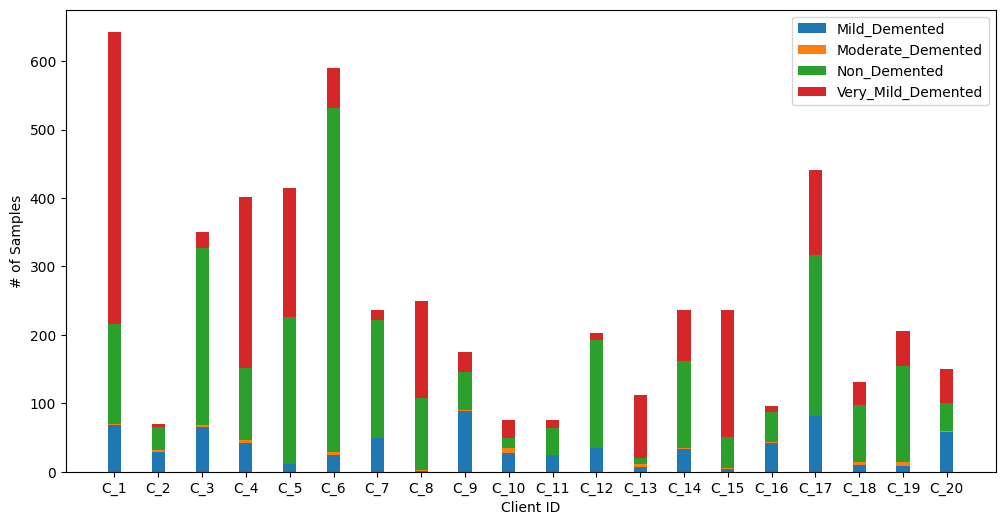

In [22]:
fl_simulator.plotDataDistribution()

In [23]:
central_server = server(test_set, fl_simulator.clients, args)

In [24]:
central_server.test()


Test set: Average loss: 1.3302, Accuracy: 658/1280 (51.41%)



(1.330152592342347, 51.40625)

In [25]:
accuracies, losses = central_server.federated_train(20)

communication round: 0


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:06, 11.04it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.4177, Generator Loss: 2.4566


Epoch 2/20:  10%|▉         | 7/73 [00:00<00:01, 59.93it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0033, Generator Loss: 7.8466


Epoch 3/20:  10%|▉         | 7/73 [00:00<00:01, 59.70it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0007, Generator Loss: 8.9057


Epoch 4/20:  16%|█▋        | 12/73 [00:00<00:01, 56.36it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0004, Generator Loss: 9.1137


Epoch 5/20:  16%|█▋        | 12/73 [00:00<00:01, 56.08it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 10.4891


Epoch 6/20:  16%|█▋        | 12/73 [00:00<00:01, 56.83it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0005, Generator Loss: 9.2496


Epoch 7/20:  16%|█▋        | 12/73 [00:00<00:01, 56.65it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0003, Generator Loss: 9.2589


Epoch 8/20:  16%|█▋        | 12/73 [00:00<00:01, 55.86it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 11.2968


Epoch 9/20:  16%|█▋        | 12/73 [00:00<00:01, 56.40it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 15.2731


Epoch 10/20:  16%|█▋        | 12/73 [00:00<00:01, 56.52it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.6922


Epoch 11/20:  16%|█▋        | 12/73 [00:00<00:01, 55.67it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 10.0115


Epoch 12/20:  16%|█▋        | 12/73 [00:00<00:01, 56.04it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.6558


Epoch 13/20:  16%|█▋        | 12/73 [00:00<00:01, 56.30it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.6227


Epoch 14/20:  16%|█▋        | 12/73 [00:00<00:01, 55.63it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.1978


Epoch 15/20:  16%|█▋        | 12/73 [00:00<00:01, 55.86it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.7515


Epoch 16/20:  16%|█▋        | 12/73 [00:00<00:01, 55.89it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.1801


Epoch 17/20:  16%|█▋        | 12/73 [00:00<00:01, 55.38it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.3949


Epoch 18/20:  16%|█▋        | 12/73 [00:00<00:01, 56.13it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 15.2397


Epoch 19/20:  16%|█▋        | 12/73 [00:00<00:01, 55.43it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 16.0707


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 56.38it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.5970


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 54.06it/s]


Training finished.


Epoch 1/20:  16%|█▋        | 12/73 [00:00<00:01, 55.87it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.5188, Generator Loss: 2.7572


Epoch 2/20:  16%|█▋        | 12/73 [00:00<00:01, 55.24it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0122, Generator Loss: 7.4389


Epoch 3/20:  16%|█▋        | 12/73 [00:00<00:01, 55.61it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0028, Generator Loss: 8.7321


Epoch 4/20:  16%|█▋        | 12/73 [00:00<00:01, 55.72it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0014, Generator Loss: 9.2907


Epoch 5/20:  16%|█▋        | 12/73 [00:00<00:01, 55.38it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0015, Generator Loss: 9.7133


Epoch 6/20:  16%|█▋        | 12/73 [00:00<00:01, 54.91it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0008, Generator Loss: 11.0085


Epoch 7/20:  16%|█▋        | 12/73 [00:00<00:01, 54.53it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 12.0461


Epoch 8/20:  16%|█▋        | 12/73 [00:00<00:01, 55.06it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 13.1257


Epoch 9/20:  16%|█▋        | 12/73 [00:00<00:01, 55.13it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 10.3135


Epoch 10/20:  16%|█▋        | 12/73 [00:00<00:01, 55.07it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 13.7756


Epoch 11/20:  16%|█▋        | 12/73 [00:00<00:01, 54.33it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 12.4904


Epoch 12/20:  16%|█▋        | 12/73 [00:00<00:01, 54.14it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 13.3261


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 57.80it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 12.7657


Epoch 14/20:  16%|█▋        | 12/73 [00:00<00:01, 54.65it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 13.4978


Epoch 15/20:  16%|█▋        | 12/73 [00:00<00:01, 54.73it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 15.4322


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 57.79it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 14.0092


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 57.78it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 13.4618


Epoch 18/20:  16%|█▋        | 12/73 [00:00<00:01, 54.02it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 14.4020


Epoch 19/20:  16%|█▋        | 12/73 [00:00<00:01, 54.34it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 12.6978


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 57.36it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 16.5585


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 52.48it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 58.22it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4000, Generator Loss: 2.5765


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 56.25it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0056, Generator Loss: 7.3725


Epoch 3/20:  16%|█▋        | 12/73 [00:00<00:01, 54.16it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0013, Generator Loss: 8.3680


Epoch 4/20:  16%|█▋        | 12/73 [00:00<00:01, 54.73it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 8.9392


Epoch 5/20:  16%|█▋        | 12/73 [00:00<00:01, 54.10it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 10.0159


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 57.10it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 11.4918


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 56.83it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.2393


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 55.99it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.4988


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 55.56it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.2882


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 55.79it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.2425


Epoch 11/20:  16%|█▋        | 12/73 [00:00<00:01, 54.16it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.6877


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 55.05it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.7222


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 55.86it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.8073


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 55.58it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.3263


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 56.37it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.1354


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 56.08it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.1221


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 56.25it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.4738


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.27it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9583


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 55.64it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.4667


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 55.02it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.4884


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.46it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 56.69it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3785, Generator Loss: 2.6917


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 55.20it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0028, Generator Loss: 7.7007


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 53.59it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0007, Generator Loss: 8.9129


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 54.31it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 9.3164


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.72it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.5771


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.34it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 10.3523


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.94it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.5653


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.14it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.3517


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 55.03it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.2117


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.29it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 9.8687


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.81it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.7234


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.60it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.2657


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.09it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.8204


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.21it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.7115


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.62it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.9580


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.15it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.6907


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 54.36it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.1832


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 54.05it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.4338


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.17it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 16.0121


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.56it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.8011


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.12it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 57.30it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.2809, Generator Loss: 2.3646


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.24it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0021, Generator Loss: 7.3870


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.21it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.4897


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.16it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.6363


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.05it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 8.9068


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 55.13it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.1483


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 55.28it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.0608


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 55.67it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8257


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 54.95it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0028


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 55.73it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.5846


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 54.73it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.0536


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 55.75it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1178


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 55.87it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.1824


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 55.60it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.1938


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 55.83it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6399


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 56.04it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.8461


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 56.17it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.6662


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.97it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.7716


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.16it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8186


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 55.89it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.4545


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.17it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 57.23it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3655, Generator Loss: 1.9574


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 56.41it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0020, Generator Loss: 7.0176


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 56.22it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.0586


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.93it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 8.8894


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 56.10it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.4037


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.48it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.0663


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 55.86it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.3348


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 55.54it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.4278


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 56.06it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.2014


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 55.73it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.3973


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 55.60it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.0009


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 55.69it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9210


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 55.41it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7368


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.27it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5321


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.88it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9065


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 55.70it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1078


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 55.78it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6428


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.89it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4033


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 55.60it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2425


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 55.01it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.2352


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.30it/s]


Training finished.


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.3670, Generator Loss: 2.4674


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 55.97it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0033, Generator Loss: 7.6439


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 55.64it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0007, Generator Loss: 8.6155


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.55it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 9.2625


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 56.00it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.2853


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 56.17it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.6996


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 52.86it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.0890


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.35it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 9.7619


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 54.70it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 16.8320


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 55.25it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.8399


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 54.17it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.2650


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.82it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 10.8719


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 55.32it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.8088


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.36it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8773


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.77it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.9552


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.74it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.1909


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 55.63it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.0645


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 54.45it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.7029


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.90it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.2684


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.75it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.9642


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.34it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 56.90it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.4327, Generator Loss: 1.9885


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 55.60it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0052, Generator Loss: 7.4072


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.72it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 8.3399


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.37it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0006, Generator Loss: 9.5398


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.80it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0005, Generator Loss: 9.7859


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 55.00it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.7051


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 55.47it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 13.3036


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.64it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.6171


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 54.51it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.2889


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.71it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.4473


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 54.44it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 15.0135


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 55.12it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.2954


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 55.31it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.3993


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 55.40it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.4952


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.86it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.2928


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 55.77it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.4422


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 55.10it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.9718


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.24it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.4655


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 55.46it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.7895


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 56.15it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 16.5348


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.38it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 57.58it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4956, Generator Loss: 2.1907


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 55.59it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0025, Generator Loss: 7.6744


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.89it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0007, Generator Loss: 8.8278


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.50it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 9.1896


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 55.82it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 10.2943


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 55.93it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 9.8375


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 55.05it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.8931


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 56.06it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.5695


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 51.18it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.1672


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 55.66it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.2122


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 55.09it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.9532


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 55.15it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 9.8002


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 54.77it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.0534


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 56.03it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 19.2304


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.93it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.9673


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 55.28it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.3515


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 55.65it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.1783


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.30it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.9751


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 55.49it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.9422


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 56.04it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.9478


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.26it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 57.04it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4437, Generator Loss: 2.2524


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 55.64it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0027, Generator Loss: 7.2431


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.66it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0010, Generator Loss: 8.3161


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 55.66it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0006, Generator Loss: 9.1223


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.89it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0004, Generator Loss: 9.1745


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.54it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 10.5059


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.79it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.6248


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 55.35it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 14.9137


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 55.00it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.2376


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.89it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.5854


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 55.28it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.9364


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.82it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.5503


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 54.62it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.3266


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.78it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.1708


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 55.42it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.6221


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 55.23it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.9889


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 55.14it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.8745


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 55.47it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.4037


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.62it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.0285


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 55.12it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.0089


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.29it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 1.155809 Accuracy: 264/577 (45.754%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.990668 Accuracy: 361/577 (62.565%)
LOCAL_EPOCH: 2  Client: VW_3 	Loss: 0.920179 Accuracy: 381/577 (66.031%)
LOCAL_EPOCH: 3  Client: VW_3 	Loss: 0.861284 Accuracy: 388/577 (67.244%)
LOCAL_EPOCH: 4  Client: VW_3 	Loss: 0.813361 Accuracy: 415/577 (71.924%)
LOCAL_EPOCH: 5  Client: VW_3 	Loss: 0.767113 Accuracy: 418/577 (72.444%)
LOCAL_EPOCH: 6  Client: VW_3 	Loss: 0.724843 Accuracy: 434/577 (75.217%)
LOCAL_EPOCH: 7  Client: VW_3 	Loss: 0.691884 Accuracy: 443/577 (76.776%)
LOCAL_EPOCH: 8  Client: VW_3 	Loss: 0.655337 Accuracy: 447/577 (77.470%)
LOCAL_EPOCH: 9  Client: VW_3 	Loss: 0.621704 Accuracy: 469/577 (81.282%)
LOCAL_EPOCH: 10  Client: VW_3 	Loss: 0.579159 Accuracy: 472/577 (81.802%)
LOCAL_EPOCH: 11  Client: VW_3 	Loss: 0.548050 Accuracy: 480/577 (83.189%)
LOCAL_EPOCH: 12  Client: VW_3 	Loss: 0.523586 Accuracy: 485/577 (84.055%)
LOCAL_EPOCH: 13  Client: VW_3

/tmp/ipykernel_26/4001254972.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)



Test set: Average loss: 0.9046, Accuracy: 734/1280 (57.34%)

communication round: 1


Epoch 1/20:  10%|█         | 10/97 [00:00<00:01, 47.37it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.5715, Generator Loss: 2.3425


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 50.52it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0015, Generator Loss: 7.8356


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.58it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0004, Generator Loss: 8.9177


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.12it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0004, Generator Loss: 8.2810


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.77it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.3227


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.7692


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 52.01it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.5303


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.63it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 9.6212


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.96it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.1185


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.25it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.1249


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.61it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 10.8543


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 51.67it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.1778


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.02it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.1904


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.60it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.8531


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.89it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.8611


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 52.84it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 12.3121


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.69it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.9772


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.02it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.4162


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.34it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 16.3393


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.75it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.9619


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.60it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.94it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3257, Generator Loss: 2.4512


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.32it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0012, Generator Loss: 7.7024


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.12it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 8.9714


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.64it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.2535


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.79it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.8854


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.42it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.8252


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.63it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.7573


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.31it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.1395


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.26it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5911


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.73it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.3980


Epoch 11/20:  11%|█▏        | 11/97 [00:00<00:01, 50.34it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.5422


Epoch 12/20:  11%|█▏        | 11/97 [00:00<00:01, 49.81it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.7827


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.65it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.3927


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.55it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.8141


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5250


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.50it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.1491


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 51.37it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.5997


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.44it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.5911


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.6241


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.72it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.9157


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.56it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 54.05it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.3892, Generator Loss: 2.6284


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 52.04it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0123, Generator Loss: 7.7769


Epoch 3/20:  11%|█▏        | 11/97 [00:00<00:01, 50.07it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0043, Generator Loss: 8.4992


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.24it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0025, Generator Loss: 11.9700


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.83it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0015, Generator Loss: 10.9056


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.72it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 10.4044


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.13it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 13.5955


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 12.2549


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.48it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 16.1570


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.54it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 10.8286


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.60it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 13.1125


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 12.5372


Epoch 13/20:  10%|█         | 10/97 [00:00<00:01, 49.73it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 13.1600


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 12.7524


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.59it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 12.7522


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.30it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 12.2884


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.73it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 18.6014


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.56it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 11.2308


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.28it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 14.7263


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.45it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 13.3855


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.65it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.63it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.5338, Generator Loss: 2.0556


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.94it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0011, Generator Loss: 7.3533


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.54it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.9548


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.14it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 9.0479


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.23it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 8.5637


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.89it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.6235


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.16it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.2040


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.96it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8112


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.55it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.5120


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.37it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.4604


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.34it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8564


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 51.16it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.7029


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.45it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.5975


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.53it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.3037


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.85it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5862


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.32it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2736


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.46it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8418


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.30it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.0606


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.56it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1743


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.57it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.5521


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.62it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.72it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3500, Generator Loss: 2.2802


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 50.55it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0027, Generator Loss: 8.1953


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.20it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 9.3925


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.33it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 8.0918


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.33it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.2526


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.32it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.5033


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.88it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.0906


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.80it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0657


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.38it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.1101


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.42it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.5509


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.82it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.0109


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.68it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.8005


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.95it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9795


Epoch 14/20:  11%|█▏        | 11/97 [00:00<00:01, 50.17it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.0871


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.04it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6304


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.10it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9056


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 51.87it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.7653


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.11it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1975


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.5268


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1351


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.63it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.31it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.4148, Generator Loss: 2.4007


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.90it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0019, Generator Loss: 7.6703


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.05it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 8.8421


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.36it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 10.3323


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.52it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 10.5579


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.34it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.4187


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.2074


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.50it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.5869


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.04it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5885


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.1748


Epoch 11/20:  10%|█         | 10/97 [00:00<00:01, 49.72it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.9998


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.76it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.9729


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.62it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.0857


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.70it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 16.3263


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.51it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.4108


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 49.96it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.9048


Epoch 17/20:  11%|█▏        | 11/97 [00:00<00:01, 49.92it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5947


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.71it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.6446


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.10it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.7975


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.62it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.4814


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.66it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.33it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.4200, Generator Loss: 2.0762


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.21it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0014, Generator Loss: 7.7383


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.50it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 8.9615


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.76it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.3575


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.05it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.2277


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.01it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.9306


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.69it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.3462


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.47it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.7236


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.4734


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.43it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.4798


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 51.35it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.8626


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.95it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.4963


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.77it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.5199


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.14it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.5396


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.89it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.3500


Epoch 16/20:  11%|█▏        | 11/97 [00:00<00:01, 49.78it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.4287


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.73it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.2333


Epoch 18/20:  10%|█         | 10/97 [00:00<00:01, 49.88it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.0044


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.72it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4343


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.05it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.1220


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.55it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.22it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.3731, Generator Loss: 2.3560


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.61it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0018, Generator Loss: 8.0836


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.09it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0008, Generator Loss: 8.3596


Epoch 4/20:  11%|█▏        | 11/97 [00:00<00:01, 50.31it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0005, Generator Loss: 9.2438


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.03it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 11.5379


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.41it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 12.4043


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.41it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.5059


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.23it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.2560


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.29it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.6370


Epoch 10/20:  11%|█▏        | 11/97 [00:00<00:01, 50.11it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1531


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 51.03it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.0584


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.67it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.5142


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.79it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.3882


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.68it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 18.1140


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.29it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.0769


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.90it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.2923


Epoch 17/20:  10%|█         | 10/97 [00:00<00:01, 49.85it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.1543


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.10it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.3546


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.03it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.7814


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.48it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 18.9508


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.55it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.97it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3629, Generator Loss: 2.3275


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0016, Generator Loss: 7.8995


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.8816


Epoch 4/20:  11%|█▏        | 11/97 [00:00<00:01, 50.21it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 9.4033


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.35it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.6813


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.77it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.0342


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.92it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8716


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.43it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.6299


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.95it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.1505


Epoch 10/20:  11%|█▏        | 11/97 [00:00<00:01, 49.76it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.3645


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.04it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.1231


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 51.32it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7686


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 54.38it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8065


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.75it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.5904


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.45it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.1704


Epoch 16/20:  10%|█         | 10/97 [00:00<00:01, 49.69it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.3349


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 51.06it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1647


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.32it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5901


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.00it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.3781


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.70it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0244


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.53it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.86it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.5297, Generator Loss: 2.1529


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.01it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 7.9047


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.14it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 8.8460


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.88it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0003, Generator Loss: 9.6858


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.52it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.6815


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.28it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 12.0127


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.63it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.5724


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.00it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.2150


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.89it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.1106


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.20it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.4136


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.66it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.1578


Epoch 12/20:  10%|█         | 10/97 [00:00<00:01, 49.79it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.9699


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 55.38it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.7982


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.17it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.2872


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.61it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8844


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.08it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.0976


Epoch 17/20:  11%|█▏        | 11/97 [00:00<00:01, 50.10it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.4732


Epoch 18/20:  11%|█▏        | 11/97 [00:00<00:01, 48.31it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.5676


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.34it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 15.7341


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.19it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.9109


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.58it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_5 	Loss: 0.731487 Accuracy: 551/776 (71.005%)
LOCAL_EPOCH: 1  Client: VW_5 	Loss: 0.610337 Accuracy: 601/776 (77.448%)
LOCAL_EPOCH: 2  Client: VW_5 	Loss: 0.527233 Accuracy: 630/776 (81.186%)
LOCAL_EPOCH: 3  Client: VW_5 	Loss: 0.474336 Accuracy: 654/776 (84.278%)
LOCAL_EPOCH: 4  Client: VW_5 	Loss: 0.424017 Accuracy: 668/776 (86.082%)
LOCAL_EPOCH: 5  Client: VW_5 	Loss: 0.378874 Accuracy: 682/776 (87.887%)
LOCAL_EPOCH: 6  Client: VW_5 	Loss: 0.337027 Accuracy: 692/776 (89.175%)
LOCAL_EPOCH: 7  Client: VW_5 	Loss: 0.298199 Accuracy: 702/776 (90.464%)
LOCAL_EPOCH: 8  Client: VW_5 	Loss: 0.265375 Accuracy: 710/776 (91.495%)
LOCAL_EPOCH: 9  Client: VW_5 	Loss: 0.238491 Accuracy: 727/776 (93.686%)
LOCAL_EPOCH: 10  Client: VW_5 	Loss: 0.214387 Accuracy: 736/776 (94.845%)
LOCAL_EPOCH: 11  Client: VW_5 	Loss: 0.200772 Accuracy: 731/776 (94.201%)
LOCAL_EPOCH: 12  Client: VW_5 	Loss: 0.171387 Accuracy: 747/776 (96.263%)
LOCAL_EPOCH: 13  Client: VW_5

Epoch 1/20:   5%|▌         | 5/97 [00:00<00:02, 42.73it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.5298, Generator Loss: 2.5536


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 50.22it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0020, Generator Loss: 7.5987


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.67it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0006, Generator Loss: 8.6913


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.1454


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.81it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 8.6448


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.32it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 9.6740


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 51.40it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 11.4847


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.1881


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.72it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.0127


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.4286


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.2221


Epoch 12/20:  11%|█▏        | 11/97 [00:00<00:01, 50.05it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.5446


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.0620


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.37it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.8618


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.20it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.1582


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.94it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.8153


Epoch 17/20:  11%|█▏        | 11/97 [00:00<00:01, 49.48it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.2828


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.05it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.6795


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.3838


Epoch 20/20:  10%|█         | 10/97 [00:00<00:01, 49.90it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.6101


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.52it/s]


Training finished.


Epoch 1/20:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.6170, Generator Loss: 2.3495


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.91it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0013, Generator Loss: 8.1655


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.79it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0007, Generator Loss: 8.9187


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.21it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.8094


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.5438


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.00it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.3050


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.77it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.2834


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.27it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.2877


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.64it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 9.8250


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.71it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.9669


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 52.03it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.4517


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.6278


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.84it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.6072


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.31it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.1130


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.39it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.3752


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.93it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.0630


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 52.07it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.2263


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.8847


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.76it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.6067


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.14it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 16.0201


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.59it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 55.79it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4101, Generator Loss: 2.2686


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.60it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0011, Generator Loss: 7.8904


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.92it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 8.9534


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.74it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 8.8612


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.93it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.6658


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.38it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.0308


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.89it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.0369


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.94it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.5476


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.02it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.6831


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.44it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.1120


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.85it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0897


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.6067


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.26it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3325


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.31it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0972


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.45it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5017


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.99it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.7110


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 51.23it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.8695


Epoch 18/20:  11%|█▏        | 11/97 [00:00<00:01, 50.40it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.9373


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.35it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.4059


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.87it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0775


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.57it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.49it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4053, Generator Loss: 2.2454


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0012, Generator Loss: 8.0540


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.02it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.2974


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.62it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 8.9127


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.51it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 9.4095


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.43it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.4640


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 51.26it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.1100


Epoch 8/20:  11%|█▏        | 11/97 [00:00<00:01, 50.75it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.3445


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.62it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7710


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.55it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0822


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.99it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.6464


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.59it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0273


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.38it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.2929


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.14it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.6167


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.26it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.1102


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.41it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.5891


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.28it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.3166


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.41it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.5792


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.82it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.6474


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.14it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 17.2046


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.57it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.10it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.5152, Generator Loss: 2.1525


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.55it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0038, Generator Loss: 7.6325


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 51.57it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0012, Generator Loss: 9.1920


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.52it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0007, Generator Loss: 9.2277


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.66it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0012, Generator Loss: 8.3664


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.27it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 11.4033


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.61it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 13.0286


Epoch 8/20:  11%|█▏        | 11/97 [00:00<00:01, 49.96it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 10.7594


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.96it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.6450


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.07it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.3665


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.85it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.7783


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.30it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.5539


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.56it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.4517


Epoch 14/20:  10%|█         | 10/97 [00:00<00:01, 49.90it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.3908


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.93it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.1811


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.16it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.6052


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 51.37it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1680


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.18it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 10.9453


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.04it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.2985


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.91it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.0459


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.64it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.70it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.5153, Generator Loss: 2.2973


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.28it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0034, Generator Loss: 7.5066


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.48it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0010, Generator Loss: 8.4721


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.67it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0006, Generator Loss: 9.4088


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.84it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0006, Generator Loss: 8.6590


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.92it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 11.1159


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.86it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.8438


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 50.94it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.9205


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.83it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.8342


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.25it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.8104


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.85it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0484


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.01it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.3241


Epoch 13/20:  11%|█▏        | 11/97 [00:00<00:01, 50.09it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.0011


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.39it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.9592


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.42it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.9132


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.45it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.6124


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.87it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.8751


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.99it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5029


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.49it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.9103


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.54it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.8448


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.42it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.24it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4174, Generator Loss: 2.3421


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.46it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0017, Generator Loss: 7.2463


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.49it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 8.4423


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.25it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 8.2912


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.5953


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.92it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.3936


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 50.84it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.7282


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.38it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.3088


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.53it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0531


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 52.00it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1529


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 51.15it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1420


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.44it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.8252


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 51.74it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7731


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.73it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0131


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.55it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4497


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6496


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.08it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0213


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.43it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5770


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.05it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4475


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.26it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.3227


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.61it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.94it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.5008, Generator Loss: 1.6519


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.45it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0017, Generator Loss: 7.4949


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.99it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0009, Generator Loss: 7.7401


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.71it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.4064


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.31it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.3954


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 51.64it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.1284


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 51.40it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.3189


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.84it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.3995


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 52.80it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.8456


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.95it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.4419


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.94it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.7835


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.45it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.3269


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.94it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 9.8977


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.54it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.8590


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 50.53it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.4987


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 50.31it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9574


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.20it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.7862


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.13it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4629


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.47it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.2892


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.61it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9556


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.59it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.52it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.5341, Generator Loss: 2.4140


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.50it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0014, Generator Loss: 7.7545


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 50.75it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0004, Generator Loss: 8.6568


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.33it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.5750


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 52.33it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.8223


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.63it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.0618


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 51.28it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.1936


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.29it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0366


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 50.73it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.9310


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.18it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.4825


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 51.21it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.7207


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.70it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5285


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 52.00it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.9325


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 51.11it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5643


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.40it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5136


Epoch 16/20:  11%|█▏        | 11/97 [00:00<00:01, 49.66it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.1410


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.25it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.2983


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 51.08it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.3486


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.22it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.6465


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 51.54it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4977


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.60it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.51it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4738, Generator Loss: 2.3327


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.21it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0019, Generator Loss: 7.8393


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 49.99it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0006, Generator Loss: 9.6223


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 50.97it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 9.3032


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 50.77it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 9.6360


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 50.60it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0008, Generator Loss: 9.2070


Epoch 7/20:  10%|█         | 10/97 [00:00<00:01, 49.76it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.2451


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 51.65it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.6945


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.01it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.7136


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 50.70it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.3661


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.01it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3789


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 50.92it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4141


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 50.85it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9986


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 50.78it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.8863


Epoch 15/20:  10%|█         | 10/97 [00:00<00:01, 49.63it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.9149


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.09it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.7116


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 50.74it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.0953


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 50.84it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.1010


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 50.98it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.2940


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 50.39it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.5475


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.56it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.724836 Accuracy: 552/776 (71.134%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.539421 Accuracy: 628/776 (80.928%)
LOCAL_EPOCH: 2  Client: VW_7 	Loss: 0.444111 Accuracy: 653/776 (84.149%)
LOCAL_EPOCH: 3  Client: VW_7 	Loss: 0.375939 Accuracy: 678/776 (87.371%)
LOCAL_EPOCH: 4  Client: VW_7 	Loss: 0.299733 Accuracy: 708/776 (91.237%)
LOCAL_EPOCH: 5  Client: VW_7 	Loss: 0.272977 Accuracy: 711/776 (91.624%)
LOCAL_EPOCH: 6  Client: VW_7 	Loss: 0.231574 Accuracy: 730/776 (94.072%)
LOCAL_EPOCH: 7  Client: VW_7 	Loss: 0.185005 Accuracy: 749/776 (96.521%)
LOCAL_EPOCH: 8  Client: VW_7 	Loss: 0.173175 Accuracy: 749/776 (96.521%)
LOCAL_EPOCH: 9  Client: VW_7 	Loss: 0.149259 Accuracy: 753/776 (97.036%)
LOCAL_EPOCH: 10  Client: VW_7 	Loss: 0.133274 Accuracy: 760/776 (97.938%)
LOCAL_EPOCH: 11  Client: VW_7 	Loss: 0.111806 Accuracy: 767/776 (98.840%)
LOCAL_EPOCH: 12  Client: VW_7 	Loss: 0.092492 Accuracy: 765/776 (98.582%)
LOCAL_EPOCH: 13  Client: VW_7

Epoch 1/20:   4%|▍         | 5/126 [00:00<00:02, 40.96it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4197, Generator Loss: 2.3577


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.97it/s]

Epoch [1/20], Step [100/44], Discriminator Loss: 0.0029, Generator Loss: 8.1108


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 55.75it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0008, Generator Loss: 8.2413


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [2/20], Step [100/44], Discriminator Loss: 0.0012, Generator Loss: 9.0256


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.27it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0005, Generator Loss: 8.3265


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.52it/s]

Epoch [3/20], Step [100/44], Discriminator Loss: 0.0006, Generator Loss: 9.9412


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 55.20it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0005, Generator Loss: 9.4022


Epoch 4/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.58it/s]

Epoch [4/20], Step [100/44], Discriminator Loss: 0.0003, Generator Loss: 9.9489


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 55.19it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 10.3900


Epoch 5/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.65it/s]

Epoch [5/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 11.5229


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.99it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.3344


Epoch 6/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.45it/s]

Epoch [6/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 11.9867


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.37it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.3841


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.91it/s]

Epoch [7/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 10.7698


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.88it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.2720


Epoch 8/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.75it/s]

Epoch [8/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.1009


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.13it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.3512


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.27it/s]

Epoch [9/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 11.8797


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.86it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.0007


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [10/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.8931


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.96it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.1710


Epoch 11/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.43it/s]

Epoch [11/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.3826


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.74it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.2937


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [12/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.9178


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.20it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.6223


Epoch 13/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.65it/s]

Epoch [13/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.2552


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.97it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 17.3762


Epoch 14/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.68it/s]

Epoch [14/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.6363


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.67it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.8076


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.03it/s]

Epoch [15/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.8664


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.97it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 15.2312


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.04it/s]

Epoch [16/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 13.7966


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.81it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.9099


Epoch 17/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.66it/s]

Epoch [17/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.7322


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.23it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.4757


Epoch 18/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.64it/s]

Epoch [18/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.5269


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.32it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.5570


Epoch 19/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.77it/s]

Epoch [19/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 13.1198


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.67it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.3894


Epoch 20/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.58it/s]

Epoch [20/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.9309


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.92it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 55.94it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.5725, Generator Loss: 2.4985


Epoch 1/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.68it/s]

Epoch [1/20], Step [100/81], Discriminator Loss: 0.0020, Generator Loss: 7.9538


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.57it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0012, Generator Loss: 8.4910


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.56it/s]

Epoch [2/20], Step [100/81], Discriminator Loss: 0.0015, Generator Loss: 7.4591


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.35it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0003, Generator Loss: 9.7432


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [3/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 11.0221


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 54.11it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.2171


Epoch 4/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.63it/s]

Epoch [4/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.1960


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.76it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 9.6426


Epoch 5/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.62it/s]

Epoch [5/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 12.0547


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.44it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.7945


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.42it/s]

Epoch [6/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.6226


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.76it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.6373


Epoch 7/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.41it/s]

Epoch [7/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.9396


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 54.65it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.0049


Epoch 8/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.49it/s]

Epoch [8/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.8853


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.98it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.4889


Epoch 9/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.61it/s]

Epoch [9/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.9630


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.51it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.1811


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.83it/s]

Epoch [10/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.8747


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.03it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.7478


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.50it/s]

Epoch [11/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.5614


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.90it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.4803


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.41it/s]

Epoch [12/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.6038


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.37it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.9384


Epoch 13/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.64it/s]

Epoch [13/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.6843


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.62it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.2556


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.82it/s]

Epoch [14/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.9599


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.41it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.8654


Epoch 15/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.67it/s]

Epoch [15/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 16.5779


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.83it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1703


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.20it/s]

Epoch [16/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.7783


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.06it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.0892


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.96it/s]

Epoch [17/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 14.9385


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.18it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.1470


Epoch 18/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.61it/s]

Epoch [18/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.1331


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.50it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.2395


Epoch 19/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.56it/s]

Epoch [19/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.6355


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.11it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.5866


Epoch 20/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.73it/s]

Epoch [20/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.5891


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.94it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.74it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3071, Generator Loss: 2.5482


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.99it/s]

Epoch [1/20], Step [100/9], Discriminator Loss: 0.0009, Generator Loss: 8.1082


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.49it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0009, Generator Loss: 8.7792


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.70it/s]

Epoch [2/20], Step [100/9], Discriminator Loss: 0.0002, Generator Loss: 9.5496


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.79it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.7772


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.91it/s]

Epoch [3/20], Step [100/9], Discriminator Loss: 0.0002, Generator Loss: 9.5353


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 54.17it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0007, Generator Loss: 8.7933


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.94it/s]

Epoch [4/20], Step [100/9], Discriminator Loss: 0.0001, Generator Loss: 10.9860


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.10it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.0455


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.67it/s]

Epoch [5/20], Step [100/9], Discriminator Loss: 0.0001, Generator Loss: 10.3961


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.10it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 9.8673


Epoch 6/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.65it/s]

Epoch [6/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 11.7515


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.0217


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.27it/s]

Epoch [7/20], Step [100/9], Discriminator Loss: 0.0001, Generator Loss: 10.9489


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.85it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.7380


Epoch 8/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.69it/s]

Epoch [8/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.2993


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.57it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.6410


Epoch 9/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.48it/s]

Epoch [9/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 14.0731


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.90it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.6703


Epoch 10/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.73it/s]

Epoch [10/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.4528


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.08it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.7236


Epoch 11/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.00it/s]

Epoch [11/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.6685


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.21it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.7673


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.39it/s]

Epoch [12/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.2605


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.43it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.6676


Epoch 13/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.43it/s]

Epoch [13/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.8852


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.22it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.6526


Epoch 14/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.50it/s]

Epoch [14/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 15.5048


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 52.57it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.3323


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.01it/s]

Epoch [15/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.3002


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.39it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0728


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.66it/s]

Epoch [16/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.9666


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.78it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.3494


Epoch 17/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.44it/s]

Epoch [17/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 14.4255


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.59it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 18.9302


Epoch 18/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.45it/s]

Epoch [18/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.4781


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.63it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.3361


Epoch 19/20:  84%|████████▍ | 106/126 [00:02<00:00, 49.42it/s]

Epoch [19/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 14.1636


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.19it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.1264


Epoch 20/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.35it/s]

Epoch [20/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 16.2153


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.99it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.73it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.3920, Generator Loss: 2.2708


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.07it/s]

Epoch [1/20], Step [100/74], Discriminator Loss: 0.0031, Generator Loss: 7.4864


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.63it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0010, Generator Loss: 8.3148


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.11it/s]

Epoch [2/20], Step [100/74], Discriminator Loss: 0.0006, Generator Loss: 8.8702


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.77it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 9.3969


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [3/20], Step [100/74], Discriminator Loss: 0.0004, Generator Loss: 8.6228


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.94it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 9.3293


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.97it/s]

Epoch [4/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 9.2417


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.04it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.8866


Epoch 5/20:  84%|████████▍ | 106/126 [00:02<00:00, 50.16it/s]

Epoch [5/20], Step [100/74], Discriminator Loss: 0.0002, Generator Loss: 10.3178


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.64it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.1499


Epoch 6/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.84it/s]

Epoch [6/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.8478


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.30it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.5411


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.93it/s]

Epoch [7/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.7261


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.66it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.5380


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.85it/s]

Epoch [8/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.4034


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.63it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.8025


Epoch 9/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.74it/s]

Epoch [9/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.4954


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.40it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.1993


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.92it/s]

Epoch [10/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.7497


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.80it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.1639


Epoch 11/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.70it/s]

Epoch [11/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.4923


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.60it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.9030


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.56it/s]

Epoch [12/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.4054


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.19it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.2729


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.53it/s]

Epoch [13/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.6716


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 54.31it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.1528


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.88it/s]

Epoch [14/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.8398


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.57it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.5272


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [15/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.5162


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.49it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.0130


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.52it/s]

Epoch [16/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.5167


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.15it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.5882


Epoch 17/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.81it/s]

Epoch [17/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 16.7797


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.94it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.8879


Epoch 18/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.54it/s]

Epoch [18/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.8205


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.70it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.4598


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.08it/s]

Epoch [19/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.7958


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.63it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.8921


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.91it/s]

Epoch [20/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.9700


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.93it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 57.77it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4555, Generator Loss: 2.6677


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.89it/s]

Epoch [1/20], Step [100/30], Discriminator Loss: 0.0011, Generator Loss: 7.5483


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.89it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0013, Generator Loss: 8.1850


Epoch 2/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.41it/s]

Epoch [2/20], Step [100/30], Discriminator Loss: 0.0003, Generator Loss: 9.3284


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.25it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.4551


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.86it/s]

Epoch [3/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 9.2400


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 54.12it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.1034


Epoch 4/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.45it/s]

Epoch [4/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.1076


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.21it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.4868


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.35it/s]

Epoch [5/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.9085


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.89it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.0667


Epoch 6/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.61it/s]

Epoch [6/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.8115


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.28it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.7031


Epoch 7/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.45it/s]

Epoch [7/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.0036


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.45it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.8400


Epoch 8/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.53it/s]

Epoch [8/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.8179


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.86it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.9931


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.89it/s]

Epoch [9/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.5088


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.00it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.2034


Epoch 10/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.54it/s]

Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.0542


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.43it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1883


Epoch 11/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.57it/s]

Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.7572


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 52.85it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.3860


Epoch 12/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.49it/s]

Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.1028


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.56it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.3957


Epoch 13/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.51it/s]

Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.7818


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 54.09it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1509


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.20it/s]

Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.3217


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.9160


Epoch 15/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.72it/s]

Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.2625


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.40it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6331


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.46it/s]

Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.5013


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.51it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1302


Epoch 17/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.65it/s]

Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.0624


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.87it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.5932


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.50it/s]

Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.3932


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.69it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.0770


Epoch 19/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.54it/s]

Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.6358


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.01it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1050


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.85it/s]

Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.1097


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.99it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 55.21it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.4087, Generator Loss: 2.5434


Epoch 1/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.62it/s]

Epoch [1/20], Step [100/14], Discriminator Loss: 0.0011, Generator Loss: 7.8492


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.94it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0006, Generator Loss: 8.3532


Epoch 2/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.73it/s]

Epoch [2/20], Step [100/14], Discriminator Loss: 0.0003, Generator Loss: 9.1163


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.94it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.4849


Epoch 3/20:  87%|████████▋ | 110/126 [00:02<00:00, 48.53it/s]

Epoch [3/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 9.6948


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.16it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0006, Generator Loss: 8.7439


Epoch 4/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.61it/s]

Epoch [4/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 10.5608


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.51it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.0904


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.85it/s]

Epoch [5/20], Step [100/14], Discriminator Loss: 0.0002, Generator Loss: 9.9096


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.68it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.5991


Epoch 6/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.68it/s]

Epoch [6/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 10.3699


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.15it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.8559


Epoch 7/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.58it/s]

Epoch [7/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 10.8435


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 54.09it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.4384


Epoch 8/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.11it/s]

Epoch [8/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 15.6584


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.50it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.8682


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.53it/s]

Epoch [9/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.2581


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 52.51it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.7422


Epoch 10/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.50it/s]

Epoch [10/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 10.9095


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.94it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.5272


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.44it/s]

Epoch [11/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.1869


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.19it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.5347


Epoch 12/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.44it/s]

Epoch [12/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.9662


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.14it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.6188


Epoch 13/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.73it/s]

Epoch [13/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 15.5623


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.90it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.9760


Epoch 14/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.71it/s]

Epoch [14/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.6460


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.99it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.2153


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.79it/s]

Epoch [15/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.5536


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.35it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1702


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.54it/s]

Epoch [16/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.1959


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.85it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.7061


Epoch 17/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.46it/s]

Epoch [17/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 19.3469


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.43it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.6967


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.18it/s]

Epoch [18/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 16.4380


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.29it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.0809


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.70it/s]

Epoch [19/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.2707


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.79it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.2099


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.78it/s]

Epoch [20/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 16.2536


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.98it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.89it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4557, Generator Loss: 1.9918


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.15it/s]

Epoch [1/20], Step [100/30], Discriminator Loss: 0.0027, Generator Loss: 7.6977


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.27it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0021, Generator Loss: 8.1537


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [2/20], Step [100/30], Discriminator Loss: 0.0009, Generator Loss: 7.9793


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.24it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0008, Generator Loss: 9.1344


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.08it/s]

Epoch [3/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 13.9334


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 54.67it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.4306


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.16it/s]

Epoch [4/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.6897


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.20it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.1830


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.52it/s]

Epoch [5/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 15.1188


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.74it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8998


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.36it/s]

Epoch [6/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.4600


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.67it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.2864


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.95it/s]

Epoch [7/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.4863


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 54.26it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.8449


Epoch 8/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.67it/s]

Epoch [8/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.4137


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.57it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.5834


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [9/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.9784


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.56it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.8713


Epoch 10/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.1767


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.44it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.1733


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.35it/s]

Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.4467


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.93it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8630


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.90it/s]

Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.9207


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.04it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6717


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.82it/s]

Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.9125


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.25it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1391


Epoch 14/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.56it/s]

Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.6925


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.24it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6675


Epoch 15/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.46it/s]

Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.2668


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.41it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9972


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.53it/s]

Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.1660


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.10it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1534


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.93it/s]

Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.7331


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.40it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9906


Epoch 18/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.74it/s]

Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 16.1248


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.81it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0579


Epoch 19/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.79it/s]

Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.8659


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.68it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.3155


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.67it/s]

Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.6881


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.93it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.57it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4103, Generator Loss: 2.1928


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.90it/s]

Epoch [1/20], Step [100/32], Discriminator Loss: 0.0011, Generator Loss: 8.1701


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.76it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0008, Generator Loss: 8.5513


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.12it/s]

Epoch [2/20], Step [100/32], Discriminator Loss: 0.0003, Generator Loss: 9.2948


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.82it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.8735


Epoch 3/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.58it/s]

Epoch [3/20], Step [100/32], Discriminator Loss: 0.0003, Generator Loss: 9.2994


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 54.37it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.7741


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.69it/s]

Epoch [4/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 11.6177


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.70it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 10.0808


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.01it/s]

Epoch [5/20], Step [100/32], Discriminator Loss: 0.0002, Generator Loss: 9.5172


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.20it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.2747


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.54it/s]

Epoch [6/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 10.7692


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.40it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 14.4636


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.86it/s]

Epoch [7/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 11.7285


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.65it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 13.3593


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.91it/s]

Epoch [8/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.6855


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.91it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.6688


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.79it/s]

Epoch [9/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.2913


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.27it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.3809


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.93it/s]

Epoch [10/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.6265


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.32it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.3755


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.70it/s]

Epoch [11/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.1253


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.19it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.5158


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.02it/s]

Epoch [12/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 14.0429


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.0087


Epoch 13/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.56it/s]

Epoch [13/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.7661


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 54.87it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.5714


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.09it/s]

Epoch [14/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.5077


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.54it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.9122


Epoch 15/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [15/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 17.0651


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.22it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.1014


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.06it/s]

Epoch [16/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.7914


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.17it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.6204


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.96it/s]

Epoch [17/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.1599


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.28it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.6570


Epoch 18/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.60it/s]

Epoch [18/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.4519


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.07it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 19.6116


Epoch 19/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.42it/s]

Epoch [19/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.4103


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 51.48it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.9588


Epoch 20/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [20/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.5038


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.90it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 57.81it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3848, Generator Loss: 2.4025


Epoch 1/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.40it/s]

Epoch [1/20], Step [100/10], Discriminator Loss: 0.0026, Generator Loss: 8.0070


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.22it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0015, Generator Loss: 8.2675


Epoch 2/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.28it/s]

Epoch [2/20], Step [100/10], Discriminator Loss: 0.0008, Generator Loss: 9.0258


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.11it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 9.3988


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.05it/s]

Epoch [3/20], Step [100/10], Discriminator Loss: 0.0006, Generator Loss: 9.4887


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.74it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 9.1825


Epoch 4/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.29it/s]

Epoch [4/20], Step [100/10], Discriminator Loss: 0.0003, Generator Loss: 10.5295


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.11it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 11.5382


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [5/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 11.8447


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.98it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 11.1708


Epoch 6/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.60it/s]

Epoch [6/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.2126


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.76it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 11.6431


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.31it/s]

Epoch [7/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 10.2302


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.57it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 16.5268


Epoch 8/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.82it/s]

Epoch [8/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 15.0964


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.93it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.7655


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.42it/s]

Epoch [9/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.2880


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.24it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.5505


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.85it/s]

Epoch [10/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.6558


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.28it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5177


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.66it/s]

Epoch [11/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.6259


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4828


Epoch 12/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.89it/s]

Epoch [12/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.4014


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.59it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1796


Epoch 13/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.48it/s]

Epoch [13/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.6760


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.78it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.6848


Epoch 14/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.62it/s]

Epoch [14/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.0727


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.93it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.8511


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.09it/s]

Epoch [15/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.3449


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 54.25it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1757


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.07it/s]

Epoch [16/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.5557


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.30it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4799


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.52it/s]

Epoch [17/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.7158


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.88it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1544


Epoch 18/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.55it/s]

Epoch [18/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.5527


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.74it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1901


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.87it/s]

Epoch [19/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.9454


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.15it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.9975


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.67it/s]

Epoch [20/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.7281


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 50.00it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 55.91it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.4450, Generator Loss: 2.3457


Epoch 1/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.70it/s]

Epoch [1/20], Step [100/52], Discriminator Loss: 0.0032, Generator Loss: 7.8676


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.13it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0011, Generator Loss: 8.2953


Epoch 2/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.58it/s]

Epoch [2/20], Step [100/52], Discriminator Loss: 0.0012, Generator Loss: 9.4806


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.23it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 10.3284


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.50it/s]

Epoch [3/20], Step [100/52], Discriminator Loss: 0.0006, Generator Loss: 11.7977


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.98it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.8209


Epoch 4/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.49it/s]

Epoch [4/20], Step [100/52], Discriminator Loss: 0.0005, Generator Loss: 11.3215


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.83it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 13.0489


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.50it/s]

Epoch [5/20], Step [100/52], Discriminator Loss: 0.0002, Generator Loss: 17.0659


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.67it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.2277


Epoch 6/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.67it/s]

Epoch [6/20], Step [100/52], Discriminator Loss: 0.0003, Generator Loss: 9.6615


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.99it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.0005


Epoch 7/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.61it/s]

Epoch [7/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.3727


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 54.48it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4856


Epoch 8/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.56it/s]

Epoch [8/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.5750


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.41it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.4650


Epoch 9/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.33it/s]

Epoch [9/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.1898


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.13it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.3289


Epoch 10/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.44it/s]

Epoch [10/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.5103


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.2485


Epoch 11/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [11/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.0430


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.26it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.6635


Epoch 12/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.63it/s]

Epoch [12/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.0611


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.79it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.0006


Epoch 13/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.37it/s]

Epoch [13/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.4056


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.82it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0780


Epoch 14/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.71it/s]

Epoch [14/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 14.8852


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 54.17it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.7940


Epoch 15/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.66it/s]

Epoch [15/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.4378


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.50it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5634


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.95it/s]

Epoch [16/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.0466


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.77it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.1629


Epoch 17/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.48it/s]

Epoch [17/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.4616


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.77it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8735


Epoch 18/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.55it/s]

Epoch [18/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.9445


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.20it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 17.4088


Epoch 19/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.68it/s]

Epoch [19/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 16.0911


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.91it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.8179


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.89it/s]

Epoch [20/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.5290


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 50.05it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_2 	Loss: 0.865710 Accuracy: 657/1003 (65.503%)
LOCAL_EPOCH: 1  Client: VW_2 	Loss: 0.592493 Accuracy: 764/1003 (76.171%)
LOCAL_EPOCH: 2  Client: VW_2 	Loss: 0.488631 Accuracy: 827/1003 (82.453%)
LOCAL_EPOCH: 3  Client: VW_2 	Loss: 0.418823 Accuracy: 837/1003 (83.450%)
LOCAL_EPOCH: 4  Client: VW_2 	Loss: 0.356853 Accuracy: 871/1003 (86.839%)
LOCAL_EPOCH: 5  Client: VW_2 	Loss: 0.293649 Accuracy: 908/1003 (90.528%)
LOCAL_EPOCH: 6  Client: VW_2 	Loss: 0.253100 Accuracy: 925/1003 (92.223%)
LOCAL_EPOCH: 7  Client: VW_2 	Loss: 0.217326 Accuracy: 942/1003 (93.918%)
LOCAL_EPOCH: 8  Client: VW_2 	Loss: 0.186564 Accuracy: 961/1003 (95.813%)
LOCAL_EPOCH: 9  Client: VW_2 	Loss: 0.160317 Accuracy: 960/1003 (95.713%)
LOCAL_EPOCH: 10  Client: VW_2 	Loss: 0.139450 Accuracy: 970/1003 (96.710%)
LOCAL_EPOCH: 11  Client: VW_2 	Loss: 0.119692 Accuracy: 978/1003 (97.507%)
LOCAL_EPOCH: 12  Client: VW_2 	Loss: 0.108571 Accuracy: 976/1003 (97.308%)
LOCAL_EPOCH: 13 

Epoch 1/20:   5%|▌         | 5/93 [00:00<00:02, 40.45it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.4621, Generator Loss: 1.9265


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 55.01it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0011, Generator Loss: 7.7219


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 55.39it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 9.0864


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 54.55it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.5816


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.86it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.0809


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 55.60it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.6381


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 55.87it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 10.8673


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 54.56it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.1812


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 54.60it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.5204


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 53.71it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.3077


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.49it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 16.1060


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 55.53it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.9982


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 54.86it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.2681


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.34it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.6405


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 53.59it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.2451


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 55.17it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 17.9729


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.56it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.0783


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.96it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.3543


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.54it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.0992


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.33it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.7554


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.20it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 55.78it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4828, Generator Loss: 1.8103


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 54.39it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0013, Generator Loss: 7.5985


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 53.85it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.2219


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.25it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.1601


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 53.47it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.3098


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 54.28it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3936


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 54.16it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.7037


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 54.59it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.5682


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 55.48it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 10.1633


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 55.16it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 10.9467


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.48it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8753


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 55.50it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.5122


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 54.53it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2562


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 53.67it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.9332


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 54.41it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7789


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 53.86it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3074


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 55.45it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.2674


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.80it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.6174


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 55.43it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3117


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.74it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2699


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.10it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 56.28it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4648, Generator Loss: 2.2099


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 52.61it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0020, Generator Loss: 7.9335


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 54.86it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 8.6668


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 54.63it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 9.9204


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.61it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.6577


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 55.14it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.1438


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 55.66it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.1533


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 54.60it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.4630


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 54.88it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.6464


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 55.58it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.2238


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.64it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.7271


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 55.24it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6452


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 54.97it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.0513


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.63it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8856


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 54.49it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.1443


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 55.89it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 18.0769


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.87it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4571


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.40it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.4400


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.47it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.5412


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.55it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.4889


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.3088, Generator Loss: 2.5295


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 52.20it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0031, Generator Loss: 7.5190


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 55.83it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0007, Generator Loss: 8.7493


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.86it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0007, Generator Loss: 9.1745


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 53.84it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0005, Generator Loss: 8.9616


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 55.91it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.8938


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 54.79it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 16.4010


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 54.81it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.5615


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 54.78it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 16.0513


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 55.45it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1796


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 55.16it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2626


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.81it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.3400


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 53.78it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1240


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.62it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5345


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 52.79it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5127


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 55.67it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.2738


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 53.54it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.5587


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.35it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.8633


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.80it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.6470


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 56.09it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.4996


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.08it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 56.51it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4166, Generator Loss: 2.3149


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 53.58it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0074, Generator Loss: 7.9431


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 55.24it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0026, Generator Loss: 9.3044


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.03it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0013, Generator Loss: 9.1490


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.32it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0009, Generator Loss: 9.6501


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 54.26it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0008, Generator Loss: 11.1634


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 53.66it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 10.7937


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 55.60it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 12.7488


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 55.27it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 11.1629


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 53.95it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 13.0982


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.01it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.1659


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.71it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 13.0836


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 55.31it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.3868


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.44it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 12.6506


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 54.68it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.9873


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 54.70it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.2896


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.37it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.7848


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.10it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 14.0452


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 55.01it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 16.3356


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 53.83it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.8153


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 55.99it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.3949, Generator Loss: 2.3245


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 55.42it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0014, Generator Loss: 7.5070


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 54.32it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0005, Generator Loss: 8.6957


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.36it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.8175


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.63it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.7769


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 53.77it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.5137


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 54.67it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.9842


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 55.40it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8572


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 53.92it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 10.9134


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 54.39it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.6992


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.87it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.1338


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.68it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 16.8586


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 54.53it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.5997


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 55.32it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 16.4889


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 55.17it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.9347


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 54.80it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.5327


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 55.38it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.4580


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.52it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.9449


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.42it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.9523


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.93it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.5188


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.06it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 57.31it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.3940, Generator Loss: 2.5493


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 53.47it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0012, Generator Loss: 7.9493


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 55.17it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 8.8500


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.23it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.8743


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 51.69it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0004, Generator Loss: 9.0788


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 55.51it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.6903


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 55.30it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.6214


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 54.69it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4990


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 55.27it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.3474


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 54.85it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4310


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.38it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.4752


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.70it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.7188


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 54.54it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.8392


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.66it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0350


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 55.35it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.7023


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 55.42it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.2088


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.85it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.5205


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 54.76it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 17.3374


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.64it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.1739


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.56it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.3364


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 49.77it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 56.88it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.5193, Generator Loss: 2.5189


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 53.21it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0016, Generator Loss: 8.2963


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 54.20it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 9.1276


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 54.82it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.5206


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 55.28it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.5269


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 54.77it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.2310


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 55.31it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.4626


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 55.41it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.3880


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 55.82it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.7784


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 55.07it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.7382


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.52it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.7118


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.48it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.1072


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 55.25it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.5135


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 55.23it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.1108


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 54.74it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.6502


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 54.91it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.6387


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 52.99it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.3059


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 54.62it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.1475


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.52it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.5798


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 54.57it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.6762


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.08it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 57.39it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3477, Generator Loss: 2.5465


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 52.67it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0011, Generator Loss: 7.8259


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 54.20it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 8.8580


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.59it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.6137


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.90it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.8027


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 54.67it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.0797


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 53.69it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.8906


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 55.40it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.1796


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 55.60it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2913


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 54.65it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.2133


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.06it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0863


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 54.81it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.2736


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 55.66it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 16.9318


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 54.96it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0530


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 52.44it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.6269


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 54.66it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1270


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.53it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.4395


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.16it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.0086


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 53.72it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4437


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 55.13it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1926


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.09it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/93 [00:00<00:01, 56.59it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4577, Generator Loss: 2.0651


Epoch 2/20:   6%|▋         | 6/93 [00:00<00:01, 53.11it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0014, Generator Loss: 7.8337


Epoch 3/20:   6%|▋         | 6/93 [00:00<00:01, 54.70it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 9.0048


Epoch 4/20:   6%|▋         | 6/93 [00:00<00:01, 55.07it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 10.3201


Epoch 5/20:   6%|▋         | 6/93 [00:00<00:01, 54.31it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.5598


Epoch 6/20:   6%|▋         | 6/93 [00:00<00:01, 54.84it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 14.1417


Epoch 7/20:   6%|▋         | 6/93 [00:00<00:01, 55.42it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.8814


Epoch 8/20:   6%|▋         | 6/93 [00:00<00:01, 55.15it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.1430


Epoch 9/20:   6%|▋         | 6/93 [00:00<00:01, 54.56it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.6889


Epoch 10/20:   6%|▋         | 6/93 [00:00<00:01, 54.01it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.5583


Epoch 11/20:   6%|▋         | 6/93 [00:00<00:01, 54.57it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.4500


Epoch 12/20:   6%|▋         | 6/93 [00:00<00:01, 53.98it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.2672


Epoch 13/20:   6%|▋         | 6/93 [00:00<00:01, 53.39it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.1034


Epoch 14/20:   6%|▋         | 6/93 [00:00<00:01, 53.65it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.4112


Epoch 15/20:   6%|▋         | 6/93 [00:00<00:01, 55.98it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.1900


Epoch 16/20:   6%|▋         | 6/93 [00:00<00:01, 55.32it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.5661


Epoch 17/20:   6%|▋         | 6/93 [00:00<00:01, 54.12it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.5872


Epoch 18/20:   6%|▋         | 6/93 [00:00<00:01, 55.18it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.2819


Epoch 19/20:   6%|▋         | 6/93 [00:00<00:01, 54.59it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0659


Epoch 20/20:   6%|▋         | 6/93 [00:00<00:01, 53.88it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.5300


Epoch 20/20: 100%|██████████| 93/93 [00:01<00:00, 50.05it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_8 	Loss: 0.938117 Accuracy: 480/737 (65.129%)
LOCAL_EPOCH: 1  Client: VW_8 	Loss: 0.598026 Accuracy: 564/737 (76.526%)
LOCAL_EPOCH: 2  Client: VW_8 	Loss: 0.513996 Accuracy: 597/737 (81.004%)
LOCAL_EPOCH: 3  Client: VW_8 	Loss: 0.437097 Accuracy: 625/737 (84.803%)
LOCAL_EPOCH: 4  Client: VW_8 	Loss: 0.346733 Accuracy: 648/737 (87.924%)
LOCAL_EPOCH: 5  Client: VW_8 	Loss: 0.318905 Accuracy: 656/737 (89.009%)
LOCAL_EPOCH: 6  Client: VW_8 	Loss: 0.255614 Accuracy: 682/737 (92.537%)
LOCAL_EPOCH: 7  Client: VW_8 	Loss: 0.206751 Accuracy: 697/737 (94.573%)
LOCAL_EPOCH: 8  Client: VW_8 	Loss: 0.180036 Accuracy: 706/737 (95.794%)
LOCAL_EPOCH: 9  Client: VW_8 	Loss: 0.156611 Accuracy: 711/737 (96.472%)
LOCAL_EPOCH: 10  Client: VW_8 	Loss: 0.137196 Accuracy: 715/737 (97.015%)
LOCAL_EPOCH: 11  Client: VW_8 	Loss: 0.126050 Accuracy: 717/737 (97.286%)
LOCAL_EPOCH: 12  Client: VW_8 	Loss: 0.118835 Accuracy: 721/737 (97.829%)
LOCAL_EPOCH: 13  Client: VW_8

Epoch 1/20:  15%|█▍        | 10/68 [00:00<00:01, 44.52it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3574, Generator Loss: 2.4358


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.22it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0063, Generator Loss: 7.5879


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.65it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0018, Generator Loss: 8.2563


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.19it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0009, Generator Loss: 9.1062


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.35it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 9.3441


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 53.95it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.3826


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 53.97it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.0979


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.83it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.2418


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 54.61it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.1930


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.72it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.3223


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.07it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.5578


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.62it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.0523


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 53.59it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8417


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.58it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6197


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 53.89it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6080


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.63it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4418


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.18it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0526


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.57it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6644


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.45it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.7096


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 53.14it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.9389


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.21it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 55.87it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4385, Generator Loss: 2.6995


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 52.66it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0019, Generator Loss: 7.7040


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.52it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 8.6863


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 53.42it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.6220


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.88it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 9.7668


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 53.70it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.5313


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.18it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.6751


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.67it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.4635


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 54.45it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.1868


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.01it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.3961


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.38it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.6523


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.12it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.4698


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 53.95it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.2282


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.48it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 10.6722


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.37it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.1035


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.35it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.3776


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.00it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9488


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.67it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.6253


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.28it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.6729


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.58it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.4617


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.41it/s]


Training finished.


Epoch 1/20:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.3408, Generator Loss: 2.1927


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.58it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0018, Generator Loss: 7.4735


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.36it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.3338


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.75it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 9.0825


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 53.70it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 8.2475


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 53.13it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.4095


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 53.55it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.1756


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.14it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 12.4324


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.75it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.2422


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.66it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.2964


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.74it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.5376


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.89it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8196


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.59it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.7350


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.90it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.3503


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.84it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.0725


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.05it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.0952


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.77it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.7596


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.71it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.5275


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.54it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.6384


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.02it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.9407


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.35it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 56.78it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.4257, Generator Loss: 2.3901


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 53.92it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0038, Generator Loss: 7.2712


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.33it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0008, Generator Loss: 8.6550


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.36it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 8.8754


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.94it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 9.2916


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 53.27it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 8.5390


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 53.91it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.8410


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.27it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.9509


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.63it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.2994


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 51.41it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.5083


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.00it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.7710


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.42it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.8289


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.11it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 9.6316


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 53.81it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.3676


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 53.73it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 10.7152


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.10it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.3700


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.26it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.9060


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.30it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.6972


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.12it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.0344


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 53.99it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5747


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.39it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 55.83it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.3959, Generator Loss: 2.4396


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.49it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0102, Generator Loss: 7.6028


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 53.39it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0024, Generator Loss: 8.3572


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.76it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0010, Generator Loss: 9.3782


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.41it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0008, Generator Loss: 8.8617


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 54.01it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 9.4410


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.55it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 10.2823


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.37it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 9.7680


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.57it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 10.5588


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.01it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 12.5915


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.93it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 12.0392


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.23it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 11.9466


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 52.15it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.8811


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 53.66it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.4659


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.25it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.3568


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 53.72it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.0133


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 53.92it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.8030


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.14it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.5024


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.57it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.7843


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 53.97it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.6705


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.41it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 56.03it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.3335, Generator Loss: 2.5227


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.58it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0048, Generator Loss: 7.3378


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 53.34it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0013, Generator Loss: 8.5349


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.64it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0006, Generator Loss: 9.2382


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 55.20it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.9815


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 54.09it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.3999


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.63it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.4139


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 55.18it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.7843


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.75it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.0208


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 53.98it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.5599


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.24it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.0753


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 53.81it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9932


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.05it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.9611


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.99it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2793


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.23it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7237


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 53.65it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3520


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 53.64it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.4567


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 53.70it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.6886


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.06it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.8018


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.27it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.4501


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.35it/s]


Training finished.


Epoch 1/20:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.3018, Generator Loss: 2.1990


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.55it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0022, Generator Loss: 7.5350


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.57it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0006, Generator Loss: 8.3842


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 53.94it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 8.9874


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.27it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0008, Generator Loss: 8.6599


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 53.73it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.5912


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.07it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 13.3327


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.90it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 9.2019


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.82it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.5790


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 53.66it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.1811


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 53.74it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.8183


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.56it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.8910


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.53it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.7513


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 53.60it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.8918


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.73it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.8080


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.21it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.6170


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 53.80it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.0575


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.28it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.4547


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 53.59it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.4535


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.26it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.7974


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.40it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 56.68it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.3983, Generator Loss: 2.3582


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.20it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0058, Generator Loss: 7.0859


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.67it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0013, Generator Loss: 8.2728


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.04it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0008, Generator Loss: 8.8252


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 55.17it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0009, Generator Loss: 8.6293


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 54.04it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0013, Generator Loss: 8.4342


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.55it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0006, Generator Loss: 9.0922


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 53.87it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.1726


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 53.74it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.3329


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.43it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.4072


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 53.56it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.7058


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 54.61it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.6962


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.43it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.9037


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.87it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.7611


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.84it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.2103


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.59it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.1310


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.61it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 17.4862


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 53.93it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.2202


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.78it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.4708


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 53.30it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.7519


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.40it/s]


Training finished.


Epoch 1/20:   0%|          | 0/68 [00:00<?, ?it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.2993, Generator Loss: 2.1384


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.47it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0066, Generator Loss: 7.2511


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 53.86it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0020, Generator Loss: 7.9603


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 54.36it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0010, Generator Loss: 8.5359


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.93it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0011, Generator Loss: 8.6788


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 54.26it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0008, Generator Loss: 8.0286


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 53.76it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0004, Generator Loss: 10.6847


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.14it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 9.9009


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 54.45it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.0537


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.12it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.9823


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 54.60it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.8888


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 53.94it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.4357


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 53.63it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 13.3177


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.05it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.4851


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 53.89it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.2320


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.10it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.9674


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 54.34it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.0450


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 54.03it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.7656


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.66it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.2005


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.20it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.3774


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.40it/s]


Training finished.


Epoch 1/20:   9%|▉         | 6/68 [00:00<00:01, 56.26it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3385, Generator Loss: 2.2688


Epoch 2/20:   9%|▉         | 6/68 [00:00<00:01, 54.20it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0172, Generator Loss: 7.3405


Epoch 3/20:   9%|▉         | 6/68 [00:00<00:01, 54.80it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0069, Generator Loss: 8.1349


Epoch 4/20:   9%|▉         | 6/68 [00:00<00:01, 53.63it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0040, Generator Loss: 9.1615


Epoch 5/20:   9%|▉         | 6/68 [00:00<00:01, 54.25it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0032, Generator Loss: 9.9122


Epoch 6/20:   9%|▉         | 6/68 [00:00<00:01, 54.30it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0019, Generator Loss: 10.6576


Epoch 7/20:   9%|▉         | 6/68 [00:00<00:01, 54.14it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0016, Generator Loss: 9.7133


Epoch 8/20:   9%|▉         | 6/68 [00:00<00:01, 54.28it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0010, Generator Loss: 9.5423


Epoch 9/20:   9%|▉         | 6/68 [00:00<00:01, 54.00it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0008, Generator Loss: 9.9011


Epoch 10/20:   9%|▉         | 6/68 [00:00<00:01, 54.48it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0008, Generator Loss: 11.5102


Epoch 11/20:   9%|▉         | 6/68 [00:00<00:01, 53.88it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0005, Generator Loss: 11.5190


Epoch 12/20:   9%|▉         | 6/68 [00:00<00:01, 53.39it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0006, Generator Loss: 12.7193


Epoch 13/20:   9%|▉         | 6/68 [00:00<00:01, 54.62it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0004, Generator Loss: 9.9099


Epoch 14/20:   9%|▉         | 6/68 [00:00<00:01, 54.50it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 13.1433


Epoch 15/20:   9%|▉         | 6/68 [00:00<00:01, 54.44it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 12.9307


Epoch 16/20:   9%|▉         | 6/68 [00:00<00:01, 54.62it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 12.4132


Epoch 17/20:   9%|▉         | 6/68 [00:00<00:01, 53.58it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 11.2667


Epoch 18/20:   9%|▉         | 6/68 [00:00<00:01, 53.74it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 12.9022


Epoch 19/20:   9%|▉         | 6/68 [00:00<00:01, 54.04it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 10.8356


Epoch 20/20:   9%|▉         | 6/68 [00:00<00:01, 54.51it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 13.4618


Epoch 20/20: 100%|██████████| 68/68 [00:01<00:00, 50.37it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_6 	Loss: 0.681775 Accuracy: 401/539 (74.397%)
LOCAL_EPOCH: 1  Client: VW_6 	Loss: 0.489056 Accuracy: 440/539 (81.633%)
LOCAL_EPOCH: 2  Client: VW_6 	Loss: 0.398407 Accuracy: 456/539 (84.601%)
LOCAL_EPOCH: 3  Client: VW_6 	Loss: 0.329614 Accuracy: 471/539 (87.384%)
LOCAL_EPOCH: 4  Client: VW_6 	Loss: 0.267269 Accuracy: 489/539 (90.724%)
LOCAL_EPOCH: 5  Client: VW_6 	Loss: 0.217519 Accuracy: 500/539 (92.764%)
LOCAL_EPOCH: 6  Client: VW_6 	Loss: 0.200443 Accuracy: 509/539 (94.434%)
LOCAL_EPOCH: 7  Client: VW_6 	Loss: 0.186251 Accuracy: 505/539 (93.692%)
LOCAL_EPOCH: 8  Client: VW_6 	Loss: 0.151582 Accuracy: 516/539 (95.733%)
LOCAL_EPOCH: 9  Client: VW_6 	Loss: 0.141541 Accuracy: 515/539 (95.547%)
LOCAL_EPOCH: 10  Client: VW_6 	Loss: 0.102938 Accuracy: 525/539 (97.403%)
LOCAL_EPOCH: 11  Client: VW_6 	Loss: 0.097594 Accuracy: 521/539 (96.660%)
LOCAL_EPOCH: 12  Client: VW_6 	Loss: 0.086565 Accuracy: 530/539 (98.330%)
LOCAL_EPOCH: 13  Client: VW_6

Epoch 1/20:   4%|▍         | 5/128 [00:00<00:03, 40.33it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4948, Generator Loss: 2.2566


Epoch 1/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.11it/s]

Epoch [1/20], Step [100/32], Discriminator Loss: 0.0046, Generator Loss: 8.1809


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 56.94it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0023, Generator Loss: 8.4880


Epoch 2/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.08it/s]

Epoch [2/20], Step [100/32], Discriminator Loss: 0.0020, Generator Loss: 8.4575


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 51.18it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0008, Generator Loss: 9.9332


Epoch 3/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.38it/s]

Epoch [3/20], Step [100/32], Discriminator Loss: 0.0008, Generator Loss: 9.2295


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 51.23it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 10.1795


Epoch 4/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.98it/s]

Epoch [4/20], Step [100/32], Discriminator Loss: 0.0003, Generator Loss: 10.6646


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0004, Generator Loss: 11.3463


Epoch 5/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.68it/s]

Epoch [5/20], Step [100/32], Discriminator Loss: 0.0002, Generator Loss: 12.6673


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 51.10it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 11.9536


Epoch 6/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.89it/s]

Epoch [6/20], Step [100/32], Discriminator Loss: 0.0002, Generator Loss: 11.1284


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 52.03it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 14.2873


Epoch 7/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.78it/s]

Epoch [7/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 14.0982


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.75it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.3542


Epoch 8/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.09it/s]

Epoch [8/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 10.3502


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.22it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.0814


Epoch 9/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.84it/s]

Epoch [9/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 12.8268


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.64it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.9361


Epoch 10/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.39it/s]

Epoch [10/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 12.8634


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.48it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.0791


Epoch 11/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.39it/s]

Epoch [11/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.6370


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 50.89it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.5649


Epoch 12/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.44it/s]

Epoch [12/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 16.7172


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.23it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.8603


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.04it/s]

Epoch [13/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.6759


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 51.52it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.6487


Epoch 14/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.62it/s]

Epoch [14/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.4700


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 51.54it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.7585


Epoch 15/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.45it/s]

Epoch [15/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.1363


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 50.34it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.9788


Epoch 16/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.65it/s]

Epoch [16/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.5794


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 51.36it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.0032


Epoch 17/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.10it/s]

Epoch [17/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 16.2263


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.01it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.1680


Epoch 18/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.59it/s]

Epoch [18/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.5489


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.71it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.9335


Epoch 19/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.81it/s]

Epoch [19/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.7276


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 52.21it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.1922


Epoch 20/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.98it/s]

Epoch [20/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 14.3810


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.58it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 56.21it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4810, Generator Loss: 2.1507


Epoch 1/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.99it/s]

Epoch [1/20], Step [100/19], Discriminator Loss: 0.0018, Generator Loss: 7.9400


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 50.65it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0013, Generator Loss: 8.4176


Epoch 2/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.80it/s]

Epoch [2/20], Step [100/19], Discriminator Loss: 0.0006, Generator Loss: 8.4824


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 50.67it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 8.5069


Epoch 3/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.54it/s]

Epoch [3/20], Step [100/19], Discriminator Loss: 0.0002, Generator Loss: 9.6486


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.82it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.5914


Epoch 4/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.54it/s]

Epoch [4/20], Step [100/19], Discriminator Loss: 0.0002, Generator Loss: 9.6502


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 49.78it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.4678


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.84it/s]

Epoch [5/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 10.1588


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 50.90it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7155


Epoch 6/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.56it/s]

Epoch [6/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.6098


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 51.05it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.0441


Epoch 7/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.99it/s]

Epoch [7/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 11.6549


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.47it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.0892


Epoch 8/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.30it/s]

Epoch [8/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.2001


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 50.34it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.3485


Epoch 9/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.84it/s]

Epoch [9/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.3357


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 51.41it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.1221


Epoch 10/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.52it/s]

Epoch [10/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.2260


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.12it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.2555


Epoch 11/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.45it/s]

Epoch [11/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.9371


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 51.48it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.8932


Epoch 12/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.68it/s]

Epoch [12/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.1517


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.47it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.5602


Epoch 13/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.46it/s]

Epoch [13/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.4325


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 51.22it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.5040


Epoch 14/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.87it/s]

Epoch [14/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.5672


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 51.04it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.9212


Epoch 15/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.35it/s]

Epoch [15/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.7921


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.2508


Epoch 16/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.65it/s]

Epoch [16/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.3441


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 50.72it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.9952


Epoch 17/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.39it/s]

Epoch [17/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.7034


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 50.90it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.8154


Epoch 18/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.04it/s]

Epoch [18/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 16.0005


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.89it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.2538


Epoch 19/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.48it/s]

Epoch [19/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 16.9372


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 50.37it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.8006


Epoch 20/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.32it/s]

Epoch [20/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.5132


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.60it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 57.25it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4166, Generator Loss: 2.4697


Epoch 1/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.01it/s]

Epoch [1/20], Step [100/30], Discriminator Loss: 0.0015, Generator Loss: 8.2175


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.57it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0011, Generator Loss: 8.2823


Epoch 2/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.55it/s]

Epoch [2/20], Step [100/30], Discriminator Loss: 0.0009, Generator Loss: 7.9384


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 50.60it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.0890


Epoch 3/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.91it/s]

Epoch [3/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 9.2255


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 51.19it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.0071


Epoch 4/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.69it/s]

Epoch [4/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 11.8112


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.73it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.6534


Epoch 5/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.50it/s]

Epoch [5/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 9.7734


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 51.52it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6228


Epoch 6/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.44it/s]

Epoch [6/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.9266


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 50.65it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.9232


Epoch 7/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.58it/s]

Epoch [7/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 11.1560


Epoch 8/20:   9%|▊         | 11/128 [00:00<00:02, 50.06it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3317


Epoch 8/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.71it/s]

Epoch [8/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.7504


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.64it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.7742


Epoch 9/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.72it/s]

Epoch [9/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.7979


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 51.05it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.5138


Epoch 10/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.53it/s]

Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 10.7590


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 52.74it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9389


Epoch 11/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.93it/s]

Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.6938


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 50.40it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4621


Epoch 12/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.57it/s]

Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.0750


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.32it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.1107


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.81it/s]

Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.6019


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.36it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.2478


Epoch 14/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.79it/s]

Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 18.0239


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 50.56it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1244


Epoch 15/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.53it/s]

Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.1014


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 50.17it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6060


Epoch 16/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.72it/s]

Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.3396


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.8276


Epoch 17/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.10it/s]

Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.0147


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 50.54it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7655


Epoch 18/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.38it/s]

Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.4167


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.42it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.5406


Epoch 19/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.74it/s]

Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.7044


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 50.57it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9721


Epoch 20/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.56it/s]

Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.7506


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.47it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 56.48it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3913, Generator Loss: 2.2077


Epoch 1/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.06it/s]

Epoch [1/20], Step [100/10], Discriminator Loss: 0.0011, Generator Loss: 7.6926


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.43it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0011, Generator Loss: 8.2173


Epoch 2/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.69it/s]

Epoch [2/20], Step [100/10], Discriminator Loss: 0.0003, Generator Loss: 9.7872


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 52.01it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 11.0858


Epoch 3/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.50it/s]

Epoch [3/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 9.8325


Epoch 4/20:   9%|▊         | 11/128 [00:00<00:02, 50.03it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.0156


Epoch 4/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.53it/s]

Epoch [4/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.2903


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 8.9462


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.92it/s]

Epoch [5/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.8840


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 50.64it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.6400


Epoch 6/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.77it/s]

Epoch [6/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 12.2930


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 50.51it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3811


Epoch 7/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.91it/s]

Epoch [7/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.1395


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.71it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2605


Epoch 8/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.45it/s]

Epoch [8/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.5418


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 50.13it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.5225


Epoch 9/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.64it/s]

Epoch [9/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.2571


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.92it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6609


Epoch 10/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.86it/s]

Epoch [10/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.3562


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.84it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0055


Epoch 11/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.46it/s]

Epoch [11/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.8361


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 51.99it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.6846


Epoch 12/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.98it/s]

Epoch [12/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.9791


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.17it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.2732


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.84it/s]

Epoch [13/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 15.3353


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.79it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.6405


Epoch 14/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.44it/s]

Epoch [14/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.5721


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 51.82it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.1384


Epoch 15/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.61it/s]

Epoch [15/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.5804


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 51.29it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.5059


Epoch 16/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.73it/s]

Epoch [16/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.3683


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 52.53it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1419


Epoch 17/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.22it/s]

Epoch [17/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.7974


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 50.66it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.1843


Epoch 18/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.80it/s]

Epoch [18/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.5753


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.2688


Epoch 19/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.41it/s]

Epoch [19/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.9358


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 51.54it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5014


Epoch 20/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.83it/s]

Epoch [20/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 16.8667


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.60it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 56.18it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.3519, Generator Loss: 2.2160


Epoch 1/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.41it/s]

Epoch [1/20], Step [100/52], Discriminator Loss: 0.0021, Generator Loss: 7.9613


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.15it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0011, Generator Loss: 8.6120


Epoch 2/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.51it/s]

Epoch [2/20], Step [100/52], Discriminator Loss: 0.0010, Generator Loss: 9.3757


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 51.14it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 9.3087


Epoch 3/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.47it/s]

Epoch [3/20], Step [100/52], Discriminator Loss: 0.0003, Generator Loss: 13.8706


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.43it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 8.4480


Epoch 4/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.01it/s]

Epoch [4/20], Step [100/52], Discriminator Loss: 0.0003, Generator Loss: 11.8338


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.14it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.1400


Epoch 5/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.34it/s]

Epoch [5/20], Step [100/52], Discriminator Loss: 0.0002, Generator Loss: 12.4813


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 51.31it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 9.9693


Epoch 6/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.78it/s]

Epoch [6/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.8272


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 51.68it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.8184


Epoch 7/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.64it/s]

Epoch [7/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 12.0218


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 51.26it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.0233


Epoch 8/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.56it/s]

Epoch [8/20], Step [100/52], Discriminator Loss: 0.0002, Generator Loss: 12.5073


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 50.99it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.8773


Epoch 9/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.49it/s]

Epoch [9/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 14.2190


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.78it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.3014


Epoch 10/20:  86%|████████▌ | 110/128 [00:02<00:00, 48.93it/s]

Epoch [10/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.9724


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.13it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 16.0500


Epoch 11/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.06it/s]

Epoch [11/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.3427


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 51.41it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.6350


Epoch 12/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.06it/s]

Epoch [12/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 12.8787


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.05it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4372


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.16it/s]

Epoch [13/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 13.4488


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.36it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.3721


Epoch 14/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.67it/s]

Epoch [14/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.5324


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0760


Epoch 15/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.90it/s]

Epoch [15/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 16.8836


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 51.45it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0747


Epoch 16/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.03it/s]

Epoch [16/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.5838


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 51.28it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 17.4289


Epoch 17/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.79it/s]

Epoch [17/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 14.1517


Epoch 18/20:   9%|▊         | 11/128 [00:00<00:02, 49.87it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.7284


Epoch 18/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.19it/s]

Epoch [18/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 18.4635


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 50.71it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.7580


Epoch 19/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.58it/s]

Epoch [19/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.0649


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 50.93it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8353


Epoch 20/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.88it/s]

Epoch [20/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 16.8225


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.50it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 57.16it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.4688, Generator Loss: 2.2011


Epoch 1/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.71it/s]

Epoch [1/20], Step [100/81], Discriminator Loss: 0.0035, Generator Loss: 7.2560


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.77it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0018, Generator Loss: 7.6949


Epoch 2/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.66it/s]

Epoch [2/20], Step [100/81], Discriminator Loss: 0.0008, Generator Loss: 8.6950


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 52.35it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0006, Generator Loss: 8.9266


Epoch 3/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.51it/s]

Epoch [3/20], Step [100/81], Discriminator Loss: 0.0003, Generator Loss: 9.4758


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.6447


Epoch 4/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.28it/s]

Epoch [4/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 11.2594


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.02it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.9425


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.95it/s]

Epoch [5/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 10.1309


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 50.38it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 10.9184


Epoch 6/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.56it/s]

Epoch [6/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.5345


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 51.75it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.1265


Epoch 7/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.01it/s]

Epoch [7/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.3531


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 51.55it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.1409


Epoch 8/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.58it/s]

Epoch [8/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.8811


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 50.51it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5745


Epoch 9/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.67it/s]

Epoch [9/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 12.4127


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.32it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.8943


Epoch 10/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.72it/s]

Epoch [10/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 14.1081


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 50.77it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2172


Epoch 11/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.74it/s]

Epoch [11/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.4180


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 51.91it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.5566


Epoch 12/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.66it/s]

Epoch [12/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 10.7474


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 50.91it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.8051


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.83it/s]

Epoch [13/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.5907


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.4658


Epoch 14/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.45it/s]

Epoch [14/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.9329


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 50.49it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2754


Epoch 15/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.57it/s]

Epoch [15/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.4261


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 51.04it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2892


Epoch 16/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.65it/s]

Epoch [16/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.8325


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 50.87it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.3122


Epoch 17/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.25it/s]

Epoch [17/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.3769


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.41it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.0961


Epoch 18/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.26it/s]

Epoch [18/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.9345


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 50.96it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.4144


Epoch 19/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.97it/s]

Epoch [19/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.1269


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 50.69it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.2012


Epoch 20/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.85it/s]

Epoch [20/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.5859


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.60it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 54.47it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.5529, Generator Loss: 2.3995


Epoch 1/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.08it/s]

Epoch [1/20], Step [100/56], Discriminator Loss: 0.0045, Generator Loss: 7.8457


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 50.43it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0038, Generator Loss: 8.4963


Epoch 2/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.06it/s]

Epoch [2/20], Step [100/56], Discriminator Loss: 0.0030, Generator Loss: 7.2724


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 50.24it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0012, Generator Loss: 8.6415


Epoch 3/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.70it/s]

Epoch [3/20], Step [100/56], Discriminator Loss: 0.0010, Generator Loss: 11.5695


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.60it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 10.1713


Epoch 4/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.56it/s]

Epoch [4/20], Step [100/56], Discriminator Loss: 0.0008, Generator Loss: 11.6339


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.58it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 12.3362


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.79it/s]

Epoch [5/20], Step [100/56], Discriminator Loss: 0.0004, Generator Loss: 11.1000


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 50.82it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.6990


Epoch 6/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.25it/s]

Epoch [6/20], Step [100/56], Discriminator Loss: 0.0003, Generator Loss: 11.6745


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 50.83it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.8929


Epoch 7/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.40it/s]

Epoch [7/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 12.2126


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.41it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.3826


Epoch 8/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.64it/s]

Epoch [8/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 12.5520


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.05it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.9363


Epoch 9/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.79it/s]

Epoch [9/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 11.8833


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.88it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 13.2711


Epoch 10/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.61it/s]

Epoch [10/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 13.5344


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.73it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7455


Epoch 11/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.62it/s]

Epoch [11/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 12.2458


Epoch 12/20:   9%|▊         | 11/128 [00:00<00:02, 49.45it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.7178


Epoch 12/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.29it/s]

Epoch [12/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 12.4380


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.60it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.0151


Epoch 13/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.47it/s]

Epoch [13/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 12.4701


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.97it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.9723


Epoch 14/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.21it/s]

Epoch [14/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 12.4430


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.7039


Epoch 15/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.07it/s]

Epoch [15/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 14.0409


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 51.37it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8864


Epoch 16/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.90it/s]

Epoch [16/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.3332


Epoch 17/20:   9%|▊         | 11/128 [00:00<00:02, 50.27it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7662


Epoch 17/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.49it/s]

Epoch [17/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 15.0587


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.22it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.5308


Epoch 18/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.57it/s]

Epoch [18/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 15.0633


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.39it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.8522


Epoch 19/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.61it/s]

Epoch [19/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 14.6991


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 51.26it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 17.5966


Epoch 20/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.35it/s]

Epoch [20/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 14.9766


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.59it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 56.11it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.2741, Generator Loss: 2.4716


Epoch 1/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.91it/s]

Epoch [1/20], Step [100/74], Discriminator Loss: 0.0014, Generator Loss: 7.8228


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.11it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0033, Generator Loss: 8.2095


Epoch 2/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.45it/s]

Epoch [2/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 9.0670


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 51.08it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0009, Generator Loss: 8.9062


Epoch 3/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.07it/s]

Epoch [3/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 8.9318


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.60it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 10.2345


Epoch 4/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.74it/s]

Epoch [4/20], Step [100/74], Discriminator Loss: 0.0002, Generator Loss: 9.7920


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 50.29it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 12.3127


Epoch 5/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.52it/s]

Epoch [5/20], Step [100/74], Discriminator Loss: 0.0002, Generator Loss: 9.6921


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 51.81it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 11.5315


Epoch 6/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.47it/s]

Epoch [6/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 11.0007


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 50.49it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.5417


Epoch 7/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.10it/s]

Epoch [7/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.0747


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.90it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.1272


Epoch 8/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.82it/s]

Epoch [8/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 11.3511


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.30it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.6138


Epoch 9/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.56it/s]

Epoch [9/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.3367


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 50.52it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.2653


Epoch 10/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.23it/s]

Epoch [10/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.6851


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.07it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.3924


Epoch 11/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.29it/s]

Epoch [11/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 16.9887


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 50.81it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.1010


Epoch 12/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.43it/s]

Epoch [12/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 15.7742


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.50it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.1571


Epoch 13/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.50it/s]

Epoch [13/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.5228


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.20it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.1749


Epoch 14/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.56it/s]

Epoch [14/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 17.1905


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 51.28it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.7277


Epoch 15/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.99it/s]

Epoch [15/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.7559


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 50.41it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.9825


Epoch 16/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.00it/s]

Epoch [16/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.2260


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 51.04it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.0378


Epoch 17/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.60it/s]

Epoch [17/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.5432


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.28it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.3399


Epoch 18/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.72it/s]

Epoch [18/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.7207


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.12it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 16.1880


Epoch 19/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.62it/s]

Epoch [19/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 15.3724


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 50.79it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 16.2743


Epoch 20/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.64it/s]

Epoch [20/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.8564


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.59it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 55.94it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.3442, Generator Loss: 2.7076


Epoch 1/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.01it/s]

Epoch [1/20], Step [100/14], Discriminator Loss: 0.0013, Generator Loss: 8.1334


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 50.92it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0014, Generator Loss: 8.3622


Epoch 2/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.31it/s]

Epoch [2/20], Step [100/14], Discriminator Loss: 0.0003, Generator Loss: 9.0103


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 50.94it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0004, Generator Loss: 9.4746


Epoch 3/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.85it/s]

Epoch [3/20], Step [100/14], Discriminator Loss: 0.0010, Generator Loss: 8.4636


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 50.46it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.8471


Epoch 4/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.90it/s]

Epoch [4/20], Step [100/14], Discriminator Loss: 0.0007, Generator Loss: 8.5289


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 11.2698


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.95it/s]

Epoch [5/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 14.6990


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 51.00it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.5782


Epoch 6/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.57it/s]

Epoch [6/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.0388


Epoch 7/20:   9%|▊         | 11/128 [00:00<00:02, 50.05it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.4400


Epoch 7/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.33it/s]

Epoch [7/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.1874


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 50.80it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 17.3573


Epoch 8/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.32it/s]

Epoch [8/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.6732


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.34it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.2073


Epoch 9/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.06it/s]

Epoch [9/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.1943


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 51.26it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.8406


Epoch 10/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.96it/s]

Epoch [10/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 10.9613


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 51.55it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.4717


Epoch 11/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.82it/s]

Epoch [11/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.2620


Epoch 12/20:   8%|▊         | 10/128 [00:00<00:02, 49.39it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 16.4544


Epoch 12/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.62it/s]

Epoch [12/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.4006


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 51.45it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1123


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.95it/s]

Epoch [13/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 15.3644


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 52.00it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.7897


Epoch 14/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.90it/s]

Epoch [14/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.2346


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 50.44it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.4497


Epoch 15/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.40it/s]

Epoch [15/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.2479


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 50.78it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.1617


Epoch 16/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.52it/s]

Epoch [16/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.7989


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 50.10it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.0513


Epoch 17/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.49it/s]

Epoch [17/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 15.2871


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.95it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.7910


Epoch 18/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.52it/s]

Epoch [18/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 16.7181


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.13it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.9973


Epoch 19/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.36it/s]

Epoch [19/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.5736


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 51.75it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.7937


Epoch 20/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.69it/s]

Epoch [20/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.0584


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.54it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/128 [00:00<00:02, 56.52it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.5563, Generator Loss: 2.2875


Epoch 1/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.86it/s]

Epoch [1/20], Step [100/22], Discriminator Loss: 0.0026, Generator Loss: 7.9095


Epoch 2/20:   5%|▍         | 6/128 [00:00<00:02, 51.00it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0011, Generator Loss: 8.1914


Epoch 2/20:  86%|████████▌ | 110/128 [00:02<00:00, 48.30it/s]

Epoch [2/20], Step [100/22], Discriminator Loss: 0.0004, Generator Loss: 9.1051


Epoch 3/20:   5%|▍         | 6/128 [00:00<00:02, 50.69it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0006, Generator Loss: 9.2909


Epoch 3/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.69it/s]

Epoch [3/20], Step [100/22], Discriminator Loss: 0.0007, Generator Loss: 8.4496


Epoch 4/20:   5%|▍         | 6/128 [00:00<00:02, 51.63it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 10.3487


Epoch 4/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.99it/s]

Epoch [4/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 11.1080


Epoch 5/20:   5%|▍         | 6/128 [00:00<00:02, 51.44it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.0203


Epoch 5/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.98it/s]

Epoch [5/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 12.0990


Epoch 6/20:   5%|▍         | 6/128 [00:00<00:02, 52.31it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 14.7372


Epoch 6/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.53it/s]

Epoch [6/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.6624


Epoch 7/20:   5%|▍         | 6/128 [00:00<00:02, 50.92it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.9499


Epoch 7/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.80it/s]

Epoch [7/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 11.1957


Epoch 8/20:   5%|▍         | 6/128 [00:00<00:02, 51.28it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.4390


Epoch 8/20:  87%|████████▋ | 111/128 [00:02<00:00, 49.65it/s]

Epoch [8/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.1332


Epoch 9/20:   5%|▍         | 6/128 [00:00<00:02, 51.45it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.9053


Epoch 9/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.44it/s]

Epoch [9/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.4557


Epoch 10/20:   5%|▍         | 6/128 [00:00<00:02, 51.66it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 16.4903


Epoch 10/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.65it/s]

Epoch [10/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.0500


Epoch 11/20:   5%|▍         | 6/128 [00:00<00:02, 50.94it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.8121


Epoch 11/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.38it/s]

Epoch [11/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 11.5994


Epoch 12/20:   5%|▍         | 6/128 [00:00<00:02, 51.95it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.4478


Epoch 12/20:  85%|████████▌ | 109/128 [00:02<00:00, 49.61it/s]

Epoch [12/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 11.6988


Epoch 13/20:   5%|▍         | 6/128 [00:00<00:02, 50.70it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.9390


Epoch 13/20:  84%|████████▎ | 107/128 [00:02<00:00, 50.00it/s]

Epoch [13/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.2166


Epoch 14/20:   5%|▍         | 6/128 [00:00<00:02, 50.43it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.2740


Epoch 14/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.37it/s]

Epoch [14/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.2434


Epoch 15/20:   5%|▍         | 6/128 [00:00<00:02, 50.42it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.9696


Epoch 15/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.61it/s]

Epoch [15/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 15.8727


Epoch 16/20:   5%|▍         | 6/128 [00:00<00:02, 51.25it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.6619


Epoch 16/20:  84%|████████▍ | 108/128 [00:02<00:00, 49.71it/s]

Epoch [16/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.4748


Epoch 17/20:   5%|▍         | 6/128 [00:00<00:02, 50.83it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.9661


Epoch 17/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.62it/s]

Epoch [17/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.9143


Epoch 18/20:   5%|▍         | 6/128 [00:00<00:02, 51.76it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.8661


Epoch 18/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.66it/s]

Epoch [18/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.5874


Epoch 19/20:   5%|▍         | 6/128 [00:00<00:02, 51.17it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.2441


Epoch 19/20:  86%|████████▌ | 110/128 [00:02<00:00, 49.60it/s]

Epoch [19/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.4459


Epoch 20/20:   5%|▍         | 6/128 [00:00<00:02, 51.11it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5192


Epoch 20/20:  84%|████████▎ | 107/128 [00:02<00:00, 49.42it/s]

Epoch [20/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.1116


Epoch 20/20: 100%|██████████| 128/128 [00:02<00:00, 49.55it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.666959 Accuracy: 777/1023 (75.953%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.498713 Accuracy: 820/1023 (80.156%)
LOCAL_EPOCH: 2  Client: VW_7 	Loss: 0.349037 Accuracy: 890/1023 (86.999%)
LOCAL_EPOCH: 3  Client: VW_7 	Loss: 0.279756 Accuracy: 917/1023 (89.638%)
LOCAL_EPOCH: 4  Client: VW_7 	Loss: 0.226128 Accuracy: 942/1023 (92.082%)
LOCAL_EPOCH: 5  Client: VW_7 	Loss: 0.187667 Accuracy: 952/1023 (93.060%)
LOCAL_EPOCH: 6  Client: VW_7 	Loss: 0.177026 Accuracy: 958/1023 (93.646%)
LOCAL_EPOCH: 7  Client: VW_7 	Loss: 0.149461 Accuracy: 973/1023 (95.112%)
LOCAL_EPOCH: 8  Client: VW_7 	Loss: 0.124764 Accuracy: 992/1023 (96.970%)
LOCAL_EPOCH: 9  Client: VW_7 	Loss: 0.106028 Accuracy: 996/1023 (97.361%)
LOCAL_EPOCH: 10  Client: VW_7 	Loss: 0.095381 Accuracy: 993/1023 (97.067%)
LOCAL_EPOCH: 11  Client: VW_7 	Loss: 0.091019 Accuracy: 994/1023 (97.165%)
LOCAL_EPOCH: 12  Client: VW_7 	Loss: 0.065716 Accuracy: 1008/1023 (98.534%)
LOCAL_EPOCH: 13

Epoch 1/20:   6%|▌         | 5/90 [00:00<00:01, 43.98it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4996, Generator Loss: 2.1600


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 56.76it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0051, Generator Loss: 8.0078


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 52.97it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0012, Generator Loss: 9.1386


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.66it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0010, Generator Loss: 8.5801


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.16it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 10.7283


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 51.56it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.3667


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.09it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 11.3119


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.31it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 11.2044


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 51.78it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 14.6595


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 52.51it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.8165


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 53.27it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.3871


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.60it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 15.1558


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.19it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.6873


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.80it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.7158


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.70it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.9435


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 52.07it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.5403


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 52.91it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.5607


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 52.92it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 13.1738


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 54.31it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7239


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 53.56it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.4665


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 56.81it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.5452, Generator Loss: 2.4939


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 51.75it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0016, Generator Loss: 7.8109


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 51.80it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.9665


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 54.35it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.3384


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 52.35it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.4708


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 54.27it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 8.6300


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.52it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 8.6724


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.57it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4008


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 53.17it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.7519


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 54.34it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.7136


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 54.01it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3918


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.78it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5819


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.64it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7034


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.27it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.4699


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.62it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1660


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 53.41it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.3873


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 54.14it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7251


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.79it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.8145


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 52.09it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8928


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 52.88it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9559


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.07it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 56.75it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4093, Generator Loss: 2.4416


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 50.67it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0015, Generator Loss: 7.6924


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.71it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0005, Generator Loss: 8.8425


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 54.04it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0005, Generator Loss: 8.9490


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 52.99it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 10.3727


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 52.77it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.9217


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 51.51it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.7026


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 52.26it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.5060


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 52.03it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.7976


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 54.21it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.7780


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 53.45it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.1963


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 53.07it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.3291


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 54.34it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.8194


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 51.26it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.2181


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 52.64it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.5975


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 53.56it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.2274


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 53.21it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.0062


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.71it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.2568


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 53.36it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.1136


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 53.33it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.5375


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.20it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 56.49it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.3414, Generator Loss: 2.4709


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 51.59it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0012, Generator Loss: 7.7458


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.30it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0004, Generator Loss: 8.3931


Epoch 4/20:  12%|█▏        | 11/90 [00:00<00:01, 51.73it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 10.2983


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.96it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0010, Generator Loss: 8.5367


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 52.21it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.6747


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.29it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.5079


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.09it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.9243


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 52.14it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.6906


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 52.85it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.4779


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 53.14it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.2178


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.92it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.7900


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.10it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.2580


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.24it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.8225


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.49it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.4313


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 53.11it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.6229


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 53.83it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.8816


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.12it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.1887


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 53.26it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.9947


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 52.97it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.5601


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 56.87it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3977, Generator Loss: 2.4910


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 50.69it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0024, Generator Loss: 7.9818


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.44it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 9.3084


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.19it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 9.4631


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.86it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 9.8353


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 51.94it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 10.8726


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 51.77it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.2118


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.76it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 11.3373


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 53.07it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.9636


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 53.17it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.7154


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 52.91it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.5075


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 53.61it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1510


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 54.17it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.9402


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.84it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.5426


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.98it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.2313


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 53.70it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2052


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 53.37it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.7109


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.08it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.5770


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 52.67it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.5822


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 52.09it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0170


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.19it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 55.70it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4100, Generator Loss: 2.5100


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 52.28it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0046, Generator Loss: 7.3106


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.66it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0012, Generator Loss: 8.7197


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 54.35it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0007, Generator Loss: 8.4919


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.21it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.2266


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 53.51it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.3227


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.89it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.7978


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.31it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.0829


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 54.31it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.0603


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 53.46it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.5952


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 54.56it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.3508


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.42it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0308


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 54.17it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.2830


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.40it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.3588


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.05it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0510


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 53.00it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0511


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 54.26it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0594


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.43it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4210


Epoch 19/20:  12%|█▏        | 11/90 [00:00<00:01, 49.93it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3012


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 53.57it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.8962


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.11it/s]


Training finished.


Epoch 1/20:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.3698, Generator Loss: 2.0363


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 51.18it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0010, Generator Loss: 7.7145


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.23it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 9.1082


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.36it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 9.4602


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 52.86it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.7695


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 52.67it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.4213


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 54.02it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 10.7230


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 52.86it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.6213


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 53.36it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.4891


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 53.30it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.5679


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 54.07it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 10.4572


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 53.20it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.5962


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.89it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.7133


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.29it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.9123


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 52.72it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.7731


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 54.14it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.1143


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 54.45it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.5580


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.40it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.6364


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 53.75it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.8459


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 53.50it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.8614


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.20it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 57.52it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.4828, Generator Loss: 2.6079


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 52.45it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0033, Generator Loss: 7.3012


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 53.04it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0009, Generator Loss: 9.1241


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.42it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 9.3002


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.05it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0008, Generator Loss: 8.9457


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 53.29it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 9.9411


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 54.50it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.3484


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.13it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.0049


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 52.61it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.4419


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 53.46it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.9477


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 53.31it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.7118


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.58it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.7692


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.01it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.4740


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 54.20it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.2261


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.36it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.5293


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 51.05it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.7017


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 52.69it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.4924


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 54.29it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.3686


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 53.75it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.4770


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 52.72it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8889


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 56.98it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4475, Generator Loss: 2.5318


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 52.75it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0017, Generator Loss: 7.8994


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 54.44it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 8.7214


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.46it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 9.2955


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 52.18it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.1016


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 54.34it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.0293


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.51it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.8667


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 53.50it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.1035


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 53.30it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2913


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 53.90it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2267


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 53.30it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 11.5218


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 53.00it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.0560


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.77it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8781


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 52.79it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.5945


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 53.43it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 16.5269


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 52.98it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.7730


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 52.76it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9541


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.55it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8699


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 54.23it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.3548


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 52.94it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.1065


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.07it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/90 [00:00<00:01, 57.94it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4537, Generator Loss: 2.0604


Epoch 2/20:   7%|▋         | 6/90 [00:00<00:01, 51.37it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0017, Generator Loss: 7.3963


Epoch 3/20:   7%|▋         | 6/90 [00:00<00:01, 54.01it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0005, Generator Loss: 8.3825


Epoch 4/20:   7%|▋         | 6/90 [00:00<00:01, 53.56it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 8.8625


Epoch 5/20:   7%|▋         | 6/90 [00:00<00:01, 53.04it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.2324


Epoch 6/20:   7%|▋         | 6/90 [00:00<00:01, 53.09it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0005, Generator Loss: 8.5004


Epoch 7/20:   7%|▋         | 6/90 [00:00<00:01, 53.48it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.1690


Epoch 8/20:   7%|▋         | 6/90 [00:00<00:01, 54.00it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.4834


Epoch 9/20:   7%|▋         | 6/90 [00:00<00:01, 54.27it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.7989


Epoch 10/20:   7%|▋         | 6/90 [00:00<00:01, 52.78it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.3324


Epoch 11/20:   7%|▋         | 6/90 [00:00<00:01, 54.56it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.2772


Epoch 12/20:   7%|▋         | 6/90 [00:00<00:01, 52.41it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.4831


Epoch 13/20:   7%|▋         | 6/90 [00:00<00:01, 53.41it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.3313


Epoch 14/20:   7%|▋         | 6/90 [00:00<00:01, 53.54it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.7053


Epoch 15/20:   7%|▋         | 6/90 [00:00<00:01, 52.14it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9409


Epoch 16/20:   7%|▋         | 6/90 [00:00<00:01, 51.75it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9858


Epoch 17/20:   7%|▋         | 6/90 [00:00<00:01, 53.77it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.3287


Epoch 18/20:   7%|▋         | 6/90 [00:00<00:01, 53.98it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.0584


Epoch 19/20:   7%|▋         | 6/90 [00:00<00:01, 53.62it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.5847


Epoch 20/20:   7%|▋         | 6/90 [00:00<00:01, 53.48it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.3332


Epoch 20/20: 100%|██████████| 90/90 [00:01<00:00, 50.28it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_11 	Loss: 0.615625 Accuracy: 570/717 (79.498%)
LOCAL_EPOCH: 1  Client: VW_11 	Loss: 0.431704 Accuracy: 602/717 (83.961%)
LOCAL_EPOCH: 2  Client: VW_11 	Loss: 0.367343 Accuracy: 621/717 (86.611%)
LOCAL_EPOCH: 3  Client: VW_11 	Loss: 0.261297 Accuracy: 651/717 (90.795%)
LOCAL_EPOCH: 4  Client: VW_11 	Loss: 0.205122 Accuracy: 661/717 (92.190%)
LOCAL_EPOCH: 5  Client: VW_11 	Loss: 0.211421 Accuracy: 662/717 (92.329%)
LOCAL_EPOCH: 6  Client: VW_11 	Loss: 0.155442 Accuracy: 678/717 (94.561%)
LOCAL_EPOCH: 7  Client: VW_11 	Loss: 0.122209 Accuracy: 689/717 (96.095%)
LOCAL_EPOCH: 8  Client: VW_11 	Loss: 0.108177 Accuracy: 695/717 (96.932%)
LOCAL_EPOCH: 9  Client: VW_11 	Loss: 0.087751 Accuracy: 701/717 (97.768%)
LOCAL_EPOCH: 10  Client: VW_11 	Loss: 0.094928 Accuracy: 697/717 (97.211%)
LOCAL_EPOCH: 11  Client: VW_11 	Loss: 0.070241 Accuracy: 706/717 (98.466%)
LOCAL_EPOCH: 12  Client: VW_11 	Loss: 0.060877 Accuracy: 706/717 (98.466%)
LOCAL_EPOCH: 13 

Epoch 1/20:   5%|▌         | 5/98 [00:00<00:02, 40.88it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.4553, Generator Loss: 2.1895


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 55.77it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0015, Generator Loss: 7.8614


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 54.80it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0004, Generator Loss: 8.7217


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.70it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.3490


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.87it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.8802


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 52.65it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0004, Generator Loss: 8.7060


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 53.44it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.2861


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.53it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.8501


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.05it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.9472


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 53.98it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.3213


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 53.75it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.1844


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.28it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.6691


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 53.82it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.6824


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.08it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.7277


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 53.95it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.5863


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.11it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.6899


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.39it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.8931


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 53.92it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.0497


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 53.67it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.7874


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 55.42it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.9116


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.12it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 56.39it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.5238, Generator Loss: 1.9872


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 53.92it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0016, Generator Loss: 7.4392


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 52.96it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 8.6781


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 52.93it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.1566


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.84it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.8342


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 54.19it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.2325


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.67it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 9.8826


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.71it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.0302


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.48it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.2188


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.56it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.4623


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.14it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.1343


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.06it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.4239


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 53.67it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4858


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 55.04it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.3164


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 55.16it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.1959


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.11it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3506


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.56it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.6546


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 55.08it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9659


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.33it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.8981


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.90it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.8513


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.06it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 56.31it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4019, Generator Loss: 2.1761


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 54.56it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0042, Generator Loss: 7.8820


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 54.36it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0009, Generator Loss: 8.9794


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.63it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.7236


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.97it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.5330


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 55.21it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.9136


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 55.57it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.1906


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.74it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.0787


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.50it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.8601


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 55.27it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7505


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.86it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.2970


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 55.13it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9731


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 54.65it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5149


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.90it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.3554


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 54.22it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7996


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 53.84it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.8378


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.04it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.3714


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.20it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.5546


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 55.17it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1513


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.07it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.8188


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.13it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 57.01it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.4049, Generator Loss: 2.5316


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 55.09it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0041, Generator Loss: 7.9579


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 54.80it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0020, Generator Loss: 9.1185


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.84it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0013, Generator Loss: 9.6910


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.34it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0007, Generator Loss: 9.8915


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 55.05it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0005, Generator Loss: 9.6604


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.57it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 13.8146


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 53.95it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 10.5501


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 52.30it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 12.0916


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 53.82it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 11.2701


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.03it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 16.4060


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.27it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 14.3267


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 54.62it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.4331


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.13it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.1495


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 55.02it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.2064


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.39it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 16.0546


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.09it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.9572


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 53.79it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 16.0898


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.23it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 18.8848


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.18it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.0314


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.07it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 58.02it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.5869, Generator Loss: 2.1640


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 55.05it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0012, Generator Loss: 8.0177


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 53.45it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.7292


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.87it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.4900


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.50it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.3677


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 55.10it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.1619


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.03it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.9215


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.86it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.1566


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.22it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5175


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 53.47it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.2567


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 53.43it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9241


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.42it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.0317


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 53.40it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7650


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.32it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.3636


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 54.85it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.2808


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.35it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0531


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.13it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1755


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.21it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6095


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.65it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7907


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.53it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0498


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.01it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 56.84it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3288, Generator Loss: 2.6275


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 54.90it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0013, Generator Loss: 8.1447


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 53.68it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0010, Generator Loss: 8.2896


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.42it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 8.8241


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 55.10it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.0179


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 55.04it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.6094


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 53.02it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.4444


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 52.55it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.0791


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 55.23it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.6267


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.46it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.6651


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 53.93it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.8972


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.58it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.6365


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 55.09it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1555


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.46it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.8129


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 54.18it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.8533


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.02it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.6554


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.39it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.7233


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.40it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.9908


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.04it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4569


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.13it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.9840


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.10it/s]


Training finished.


Epoch 1/20:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.3257, Generator Loss: 2.2198


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 54.04it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0018, Generator Loss: 8.0382


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 55.12it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0005, Generator Loss: 8.9194


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.30it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0003, Generator Loss: 9.3188


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.13it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0003, Generator Loss: 9.4329


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 54.68it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.7500


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.25it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 12.1660


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.64it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.9385


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.08it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.5066


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.52it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.4777


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.10it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1852


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 53.90it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.1112


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 54.45it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.0115


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 53.59it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.8461


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 55.15it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5707


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.42it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.8038


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.19it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.0806


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.27it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1507


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.51it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.9465


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.14it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.5059


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.04it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 56.11it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.4494, Generator Loss: 2.3521


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 54.35it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0016, Generator Loss: 7.8777


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 54.19it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 8.8376


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.47it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 8.6133


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.33it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.3599


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 53.79it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.3852


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.46it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.3062


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.59it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.4914


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.50it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.3591


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.24it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 10.2429


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.61it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.2762


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 54.58it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.4940


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 54.23it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.3332


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.01it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.3865


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 54.48it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.4326


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 53.83it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.5773


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 54.94it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5240


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 53.29it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.0570


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 53.88it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8202


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 53.89it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.6602


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.19it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 56.35it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.3683, Generator Loss: 2.0916


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 54.82it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0018, Generator Loss: 7.8057


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 53.93it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0005, Generator Loss: 8.9529


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.01it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0007, Generator Loss: 8.7591


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 54.56it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.8506


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 54.42it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.6622


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 55.28it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.0251


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.89it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.5332


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 55.10it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.9914


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.74it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.9876


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.27it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5666


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 55.10it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.2853


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 54.45it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.7749


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 54.14it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 16.9095


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 54.23it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.8149


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.58it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.8607


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 53.47it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.4465


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.13it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.3862


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 55.12it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 15.2449


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.22it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.8281


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.22it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/98 [00:00<00:01, 54.41it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4086, Generator Loss: 2.0515


Epoch 2/20:   6%|▌         | 6/98 [00:00<00:01, 53.96it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0013, Generator Loss: 7.5580


Epoch 3/20:   6%|▌         | 6/98 [00:00<00:01, 54.93it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0005, Generator Loss: 8.4847


Epoch 4/20:   6%|▌         | 6/98 [00:00<00:01, 54.82it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 8.9339


Epoch 5/20:   6%|▌         | 6/98 [00:00<00:01, 55.22it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 9.4034


Epoch 6/20:   6%|▌         | 6/98 [00:00<00:01, 55.05it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.1560


Epoch 7/20:   6%|▌         | 6/98 [00:00<00:01, 54.30it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.3559


Epoch 8/20:   6%|▌         | 6/98 [00:00<00:01, 54.30it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.2838


Epoch 9/20:   6%|▌         | 6/98 [00:00<00:01, 54.27it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.5827


Epoch 10/20:   6%|▌         | 6/98 [00:00<00:01, 54.28it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.6983


Epoch 11/20:   6%|▌         | 6/98 [00:00<00:01, 54.38it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.6113


Epoch 12/20:   6%|▌         | 6/98 [00:00<00:01, 53.61it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.2905


Epoch 13/20:   6%|▌         | 6/98 [00:00<00:01, 53.81it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 10.3832


Epoch 14/20:   6%|▌         | 6/98 [00:00<00:01, 53.51it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.5613


Epoch 15/20:   6%|▌         | 6/98 [00:00<00:01, 53.64it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.5282


Epoch 16/20:   6%|▌         | 6/98 [00:00<00:01, 54.31it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.4638


Epoch 17/20:   6%|▌         | 6/98 [00:00<00:01, 55.25it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.4539


Epoch 18/20:   6%|▌         | 6/98 [00:00<00:01, 54.67it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.4299


Epoch 19/20:   6%|▌         | 6/98 [00:00<00:01, 54.58it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.4922


Epoch 20/20:   6%|▌         | 6/98 [00:00<00:01, 54.36it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.2879


Epoch 20/20: 100%|██████████| 98/98 [00:01<00:00, 50.09it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_1 	Loss: 0.605712 Accuracy: 608/778 (78.149%)
LOCAL_EPOCH: 1  Client: VW_1 	Loss: 0.327664 Accuracy: 687/778 (88.303%)
LOCAL_EPOCH: 2  Client: VW_1 	Loss: 0.239025 Accuracy: 709/778 (91.131%)
LOCAL_EPOCH: 3  Client: VW_1 	Loss: 0.187844 Accuracy: 724/778 (93.059%)
LOCAL_EPOCH: 4  Client: VW_1 	Loss: 0.133155 Accuracy: 740/778 (95.116%)
LOCAL_EPOCH: 5  Client: VW_1 	Loss: 0.123923 Accuracy: 746/778 (95.887%)
LOCAL_EPOCH: 6  Client: VW_1 	Loss: 0.107117 Accuracy: 748/778 (96.144%)
LOCAL_EPOCH: 7  Client: VW_1 	Loss: 0.081297 Accuracy: 758/778 (97.429%)
LOCAL_EPOCH: 8  Client: VW_1 	Loss: 0.065377 Accuracy: 762/778 (97.943%)
LOCAL_EPOCH: 9  Client: VW_1 	Loss: 0.053403 Accuracy: 767/778 (98.586%)
LOCAL_EPOCH: 10  Client: VW_1 	Loss: 0.047033 Accuracy: 769/778 (98.843%)
LOCAL_EPOCH: 11  Client: VW_1 	Loss: 0.037140 Accuracy: 771/778 (99.100%)
LOCAL_EPOCH: 12  Client: VW_1 	Loss: 0.037813 Accuracy: 770/778 (98.972%)
LOCAL_EPOCH: 13  Client: VW_1

Epoch 1/20:   5%|▌         | 5/94 [00:00<00:02, 41.10it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4536, Generator Loss: 2.5300


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 55.76it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0020, Generator Loss: 7.5184


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.23it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 9.1216


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 51.10it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 8.4435


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 52.06it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.0234


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 51.21it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.9177


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 52.14it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 9.9096


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 52.25it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.7294


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.36it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.4241


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 52.32it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4490


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.16it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.5482


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 51.50it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2478


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 53.36it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4197


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 52.52it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.4825


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 52.23it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1431


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.48it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8039


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 53.19it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.0828


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 53.15it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.6905


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 51.59it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.7600


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 52.42it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.7678


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.66it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 55.66it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.4017, Generator Loss: 2.2827


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.89it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0026, Generator Loss: 7.3666


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.21it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 8.6351


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 51.42it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 9.3364


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 51.43it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 8.6841


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 50.91it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.4116


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 50.96it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.6097


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.45it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.0767


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.84it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.2359


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 51.60it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.1355


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.20it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.5556


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 51.25it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.8948


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 51.59it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2829


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 50.72it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.1150


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 51.74it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.8023


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 52.21it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.5884


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 52.25it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.6661


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 52.03it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.4248


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 53.80it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.6772


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 52.36it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 15.3599


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 56.73it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3447, Generator Loss: 2.3735


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.42it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0061, Generator Loss: 7.3552


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.37it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0018, Generator Loss: 8.7511


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 52.69it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0009, Generator Loss: 9.5573


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 52.32it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 9.7214


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 52.68it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 10.5785


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 51.80it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 11.7715


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 52.22it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 11.0342


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.73it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 13.0729


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 52.81it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 11.9484


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.60it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 16.6661


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 55.25it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.0199


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 51.23it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.8371


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 51.78it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 13.4098


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 51.12it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.8538


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 52.05it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.9906


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 52.07it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.4834


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 51.36it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 15.4599


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 52.14it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.7687


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 53.61it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.0571


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 50.10it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 56.77it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.4175, Generator Loss: 2.1895


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.68it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0025, Generator Loss: 7.7452


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 50.48it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0010, Generator Loss: 8.8645


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 51.47it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0008, Generator Loss: 8.6804


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 51.73it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0004, Generator Loss: 9.9189


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 52.63it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 12.5633


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 52.43it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 10.4111


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.88it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 13.2420


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 52.11it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 12.3371


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 51.45it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.2869


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 52.04it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.0169


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 52.77it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.4361


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 51.43it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.2382


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 51.68it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.0741


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 52.18it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.3226


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 53.65it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.6652


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 51.98it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.4955


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 52.55it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.7609


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 51.95it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.7697


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 54.44it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.4327


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 55.75it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4155, Generator Loss: 2.4655


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.07it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0012, Generator Loss: 7.7923


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 52.44it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.6894


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 52.28it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.4259


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 51.13it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.0898


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 52.12it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.1051


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 52.16it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.9546


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 53.17it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.4799


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.42it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.7972


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 52.31it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9298


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.61it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.3115


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 52.09it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.6041


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 52.80it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0171


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 51.12it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3028


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 53.08it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.4737


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.15it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6108


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 50.20it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4171


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 53.25it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9955


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 51.85it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9691


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 51.35it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.7799


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.57it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 56.62it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4561, Generator Loss: 2.3302


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.49it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0052, Generator Loss: 7.5551


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.33it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0015, Generator Loss: 8.6623


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 51.91it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0011, Generator Loss: 9.4865


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 51.93it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 10.9080


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 51.66it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 12.0844


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 51.45it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 8.5979


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.36it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.4658


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.99it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 12.3359


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 53.37it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.6803


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.59it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.4366


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 53.15it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.6899


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 52.17it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3490


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 52.62it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.7869


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 52.88it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.5388


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.77it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.0730


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 52.54it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.2618


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 51.75it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.2271


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 53.09it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.0994


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 51.81it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.8816


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.56it/s]


Training finished.


Epoch 1/20:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.3910, Generator Loss: 2.3316


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 52.46it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0015, Generator Loss: 7.7911


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.65it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0005, Generator Loss: 8.6135


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 52.60it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0010, Generator Loss: 8.0446


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 52.87it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.7889


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 52.76it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.6272


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 52.68it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.6675


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.65it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.7194


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 53.46it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.6438


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 51.22it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.0642


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 53.87it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.9124


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 52.07it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.8776


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 52.81it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.5305


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 51.69it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.9484


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 53.24it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.0114


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 52.43it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.8953


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 52.13it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.9800


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 51.93it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.0256


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 51.26it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.4793


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 53.48it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.4845


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 50.08it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 53.32it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.2932, Generator Loss: 2.2763


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 51.47it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0025, Generator Loss: 7.9516


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 52.10it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0007, Generator Loss: 9.0720


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 52.80it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 8.9402


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 52.89it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.9270


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 51.56it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.4894


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 52.31it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.3941


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.80it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 13.2560


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 52.08it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.9882


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 52.49it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.9991


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 52.13it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.4526


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 52.82it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.8139


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 51.07it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.0560


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 52.78it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.1179


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 52.01it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.7119


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.35it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.9184


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 53.57it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.2713


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 52.27it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.9359


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 51.49it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.3376


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 53.46it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.5940


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.56it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 57.51it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.3928, Generator Loss: 1.9440


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 50.57it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0013, Generator Loss: 7.7180


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 51.91it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 8.6912


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 52.49it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0005, Generator Loss: 8.5251


Epoch 5/20:  12%|█▏        | 11/94 [00:00<00:01, 50.30it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 8.5271


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 52.52it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.7411


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 53.16it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.8888


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.42it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.7208


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 52.57it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.7640


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 52.30it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.9281


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.56it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9330


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 50.90it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.1069


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 53.91it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9406


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 52.08it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.9758


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 53.39it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.0271


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.42it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.9148


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 51.91it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.3974


Epoch 18/20:   6%|▋         | 6/94 [00:00<00:01, 51.03it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.5816


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 53.73it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.2446


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 51.27it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.8711


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.68it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/94 [00:00<00:01, 57.14it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3920, Generator Loss: 2.5070


Epoch 2/20:   6%|▋         | 6/94 [00:00<00:01, 50.67it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0025, Generator Loss: 7.6611


Epoch 3/20:   6%|▋         | 6/94 [00:00<00:01, 48.40it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 9.0127


Epoch 4/20:   6%|▋         | 6/94 [00:00<00:01, 53.52it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0010, Generator Loss: 8.2057


Epoch 5/20:   6%|▋         | 6/94 [00:00<00:01, 51.61it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 8.0842


Epoch 6/20:   6%|▋         | 6/94 [00:00<00:01, 51.58it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.7633


Epoch 7/20:   6%|▋         | 6/94 [00:00<00:01, 51.58it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.7311


Epoch 8/20:   6%|▋         | 6/94 [00:00<00:01, 51.44it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.6106


Epoch 9/20:   6%|▋         | 6/94 [00:00<00:01, 51.15it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2495


Epoch 10/20:   6%|▋         | 6/94 [00:00<00:01, 51.61it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.2853


Epoch 11/20:   6%|▋         | 6/94 [00:00<00:01, 51.16it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.2272


Epoch 12/20:   6%|▋         | 6/94 [00:00<00:01, 51.85it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4074


Epoch 13/20:   6%|▋         | 6/94 [00:00<00:01, 52.58it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.6241


Epoch 14/20:   6%|▋         | 6/94 [00:00<00:01, 52.52it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4522


Epoch 15/20:   6%|▋         | 6/94 [00:00<00:01, 51.46it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8986


Epoch 16/20:   6%|▋         | 6/94 [00:00<00:01, 51.28it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6288


Epoch 17/20:   6%|▋         | 6/94 [00:00<00:01, 51.55it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.9559


Epoch 18/20:  12%|█▏        | 11/94 [00:00<00:01, 50.52it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8668


Epoch 19/20:   6%|▋         | 6/94 [00:00<00:01, 52.34it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.0558


Epoch 20/20:   6%|▋         | 6/94 [00:00<00:01, 52.02it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0689


Epoch 20/20: 100%|██████████| 94/94 [00:01<00:00, 49.63it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_9 	Loss: 0.923103 Accuracy: 536/750 (71.467%)
LOCAL_EPOCH: 1  Client: VW_9 	Loss: 0.619874 Accuracy: 585/750 (78.000%)
LOCAL_EPOCH: 2  Client: VW_9 	Loss: 0.475609 Accuracy: 610/750 (81.333%)
LOCAL_EPOCH: 3  Client: VW_9 	Loss: 0.368285 Accuracy: 647/750 (86.267%)
LOCAL_EPOCH: 4  Client: VW_9 	Loss: 0.318160 Accuracy: 662/750 (88.267%)
LOCAL_EPOCH: 5  Client: VW_9 	Loss: 0.275737 Accuracy: 681/750 (90.800%)
LOCAL_EPOCH: 6  Client: VW_9 	Loss: 0.212094 Accuracy: 695/750 (92.667%)
LOCAL_EPOCH: 7  Client: VW_9 	Loss: 0.176885 Accuracy: 702/750 (93.600%)
LOCAL_EPOCH: 8  Client: VW_9 	Loss: 0.143959 Accuracy: 715/750 (95.333%)
LOCAL_EPOCH: 9  Client: VW_9 	Loss: 0.139807 Accuracy: 714/750 (95.200%)
LOCAL_EPOCH: 10  Client: VW_9 	Loss: 0.121761 Accuracy: 711/750 (94.800%)
LOCAL_EPOCH: 11  Client: VW_9 	Loss: 0.084930 Accuracy: 734/750 (97.867%)
LOCAL_EPOCH: 12  Client: VW_9 	Loss: 0.075581 Accuracy: 730/750 (97.333%)
LOCAL_EPOCH: 13  Client: VW_9

Epoch 1/20:   7%|▋         | 5/76 [00:00<00:01, 44.27it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.2822, Generator Loss: 2.7056


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 53.80it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0017, Generator Loss: 7.6321


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 53.63it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0006, Generator Loss: 8.6110


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 54.03it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 9.6171


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 54.28it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0007, Generator Loss: 9.0489


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.96it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 10.5338


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 53.83it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.9970


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.20it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.1081


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.86it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.6807


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.72it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.7899


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 53.67it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.3315


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 54.14it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.2825


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.53it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.7648


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 53.73it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.1284


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 53.47it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.6775


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 52.75it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.0668


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 52.74it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.7339


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.56it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.8878


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 53.93it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.2315


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.50it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.9758


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.25it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 55.68it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.3823, Generator Loss: 2.0574


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 54.01it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0015, Generator Loss: 7.3411


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.80it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 8.0522


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 53.96it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 8.9022


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 54.58it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.8128


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.50it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.1171


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 53.51it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.1677


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.12it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.9893


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.81it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.5910


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.09it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.3359


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.64it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8449


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 54.66it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.3243


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.34it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.9531


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.07it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7790


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.80it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.0143


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.05it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.4751


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 53.22it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9133


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 52.81it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.6500


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 53.87it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.8121


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 53.93it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.1294


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.23it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 56.35it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4245, Generator Loss: 2.3355


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 55.17it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0050, Generator Loss: 7.0818


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.43it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0009, Generator Loss: 8.3004


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 55.05it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 9.1957


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.87it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 9.4765


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.14it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.8789


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 54.72it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.2956


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.72it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1287


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.94it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.4573


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 55.16it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1117


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.78it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.2826


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 54.00it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.6040


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.66it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0294


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.34it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.2871


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 52.98it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.5972


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.20it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0925


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 54.07it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5213


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 53.15it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.3237


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 53.51it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.5089


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 52.83it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.3783


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.28it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 56.65it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.4181, Generator Loss: 2.3294


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 54.88it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0058, Generator Loss: 7.4836


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.09it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0014, Generator Loss: 8.5181


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 54.04it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0007, Generator Loss: 8.8917


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.63it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 9.2095


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.18it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.1196


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 55.04it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 9.3625


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.15it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.6300


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.39it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 12.5935


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 53.75it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.4569


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.25it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 13.0490


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 54.17it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.9962


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 53.83it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.9529


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.46it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.3323


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.16it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.0567


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 53.70it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.8700


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 54.08it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.0561


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.26it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 10.4592


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.18it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 15.0563


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.49it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 16.6092


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 55.47it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4246, Generator Loss: 2.1586


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 53.78it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0076, Generator Loss: 7.4709


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 53.65it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0026, Generator Loss: 8.4957


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 54.96it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0012, Generator Loss: 9.4676


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.65it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0015, Generator Loss: 9.1937


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.18it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0010, Generator Loss: 9.6582


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 53.82it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 11.1451


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.87it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.6924


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.90it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 15.9026


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.48it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 12.1596


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.05it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.5104


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 54.59it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 12.6633


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.21it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 13.4223


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.72it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 15.0706


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.27it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 13.5059


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 53.88it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.6933


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 53.70it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 14.1461


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 53.73it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.1168


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.45it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.3280


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.16it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.4579


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.33it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 56.56it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.4147, Generator Loss: 1.9847


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 54.03it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0025, Generator Loss: 7.6231


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.80it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0007, Generator Loss: 8.6345


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 53.39it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 9.9477


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 54.37it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 9.3707


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.24it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.3025


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 53.78it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.1443


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.12it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.1795


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.84it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 9.7444


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 51.52it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.7244


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.01it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.3771


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 53.74it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.1842


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 53.73it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.6971


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.79it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 10.9084


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.24it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.5202


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.35it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 15.2789


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 54.44it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.1372


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.17it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.3055


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.18it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.1404


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.21it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.1845


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.29it/s]


Training finished.


Epoch 1/20:   0%|          | 0/76 [00:00<?, ?it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.4796, Generator Loss: 2.3683


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 54.58it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0034, Generator Loss: 7.3646


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 53.03it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0008, Generator Loss: 8.4769


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 54.45it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 9.2199


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.31it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.5713


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.05it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.4976


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 53.97it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.4073


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.62it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7781


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 54.32it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9069


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.57it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.2852


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 53.43it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.9900


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 53.51it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9708


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 53.74it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.6341


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 53.69it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.1723


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 53.64it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.1953


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.80it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.0920


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 54.23it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.6432


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.17it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.8571


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 53.88it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.2676


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.41it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.9920


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.21it/s]


Training finished.


Epoch 1/20:  16%|█▌        | 12/76 [00:00<00:01, 54.17it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.5396, Generator Loss: 2.2966


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 54.12it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0029, Generator Loss: 7.0812


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 53.93it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 8.6449


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 54.62it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.1444


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.70it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.2075


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.13it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.2393


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 54.99it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.4021


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 53.73it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.5069


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 54.00it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.8382


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.33it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.4287


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 53.43it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.2758


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 53.82it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.2164


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.45it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9755


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.42it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.0263


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.42it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.8062


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 53.92it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.0964


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 53.49it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.9589


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.15it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.5711


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.21it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.9541


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.35it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7783


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.33it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 57.63it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.4052, Generator Loss: 2.3345


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 53.96it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0036, Generator Loss: 7.4959


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.13it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0010, Generator Loss: 8.7195


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 55.08it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0004, Generator Loss: 9.0188


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 53.98it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0003, Generator Loss: 9.8797


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 53.92it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0006, Generator Loss: 8.6197


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 54.46it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 11.5221


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 54.17it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 10.4205


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 53.38it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 12.2705


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 53.55it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.9056


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 53.03it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 10.6100


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 53.32it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.2074


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 54.79it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.3846


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.05it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.4006


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 53.98it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.7088


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.08it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.0847


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 55.05it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.6096


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.06it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.6301


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.64it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.3327


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.61it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.9584


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.18it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/76 [00:00<00:01, 56.22it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3293, Generator Loss: 2.3655


Epoch 2/20:   8%|▊         | 6/76 [00:00<00:01, 55.01it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0015, Generator Loss: 7.7766


Epoch 3/20:   8%|▊         | 6/76 [00:00<00:01, 54.35it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 8.6276


Epoch 4/20:   8%|▊         | 6/76 [00:00<00:01, 55.08it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.3263


Epoch 5/20:   8%|▊         | 6/76 [00:00<00:01, 54.26it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.5105


Epoch 6/20:   8%|▊         | 6/76 [00:00<00:01, 54.13it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.7562


Epoch 7/20:   8%|▊         | 6/76 [00:00<00:01, 54.15it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 9.0103


Epoch 8/20:   8%|▊         | 6/76 [00:00<00:01, 55.54it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3981


Epoch 9/20:   8%|▊         | 6/76 [00:00<00:01, 54.06it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.6471


Epoch 10/20:   8%|▊         | 6/76 [00:00<00:01, 54.82it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4488


Epoch 11/20:   8%|▊         | 6/76 [00:00<00:01, 54.06it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8654


Epoch 12/20:   8%|▊         | 6/76 [00:00<00:01, 53.96it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.1545


Epoch 13/20:   8%|▊         | 6/76 [00:00<00:01, 53.90it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.8536


Epoch 14/20:   8%|▊         | 6/76 [00:00<00:01, 54.37it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8691


Epoch 15/20:   8%|▊         | 6/76 [00:00<00:01, 54.03it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1305


Epoch 16/20:   8%|▊         | 6/76 [00:00<00:01, 54.00it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3104


Epoch 17/20:   8%|▊         | 6/76 [00:00<00:01, 55.17it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3575


Epoch 18/20:   8%|▊         | 6/76 [00:00<00:01, 54.84it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.5971


Epoch 19/20:   8%|▊         | 6/76 [00:00<00:01, 54.58it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.8986


Epoch 20/20:   8%|▊         | 6/76 [00:00<00:01, 54.01it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.5314


Epoch 20/20: 100%|██████████| 76/76 [00:01<00:00, 50.34it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_2 	Loss: 0.471592 Accuracy: 506/603 (83.914%)
LOCAL_EPOCH: 1  Client: VW_2 	Loss: 0.313115 Accuracy: 535/603 (88.723%)
LOCAL_EPOCH: 2  Client: VW_2 	Loss: 0.232579 Accuracy: 558/603 (92.537%)
LOCAL_EPOCH: 3  Client: VW_2 	Loss: 0.200274 Accuracy: 558/603 (92.537%)
LOCAL_EPOCH: 4  Client: VW_2 	Loss: 0.161265 Accuracy: 576/603 (95.522%)
LOCAL_EPOCH: 5  Client: VW_2 	Loss: 0.127220 Accuracy: 577/603 (95.688%)
LOCAL_EPOCH: 6  Client: VW_2 	Loss: 0.114240 Accuracy: 583/603 (96.683%)
LOCAL_EPOCH: 7  Client: VW_2 	Loss: 0.117650 Accuracy: 573/603 (95.025%)
LOCAL_EPOCH: 8  Client: VW_2 	Loss: 0.086351 Accuracy: 588/603 (97.512%)
LOCAL_EPOCH: 9  Client: VW_2 	Loss: 0.088307 Accuracy: 583/603 (96.683%)
LOCAL_EPOCH: 10  Client: VW_2 	Loss: 0.060561 Accuracy: 590/603 (97.844%)
LOCAL_EPOCH: 11  Client: VW_2 	Loss: 0.058603 Accuracy: 595/603 (98.673%)
LOCAL_EPOCH: 12  Client: VW_2 	Loss: 0.052266 Accuracy: 591/603 (98.010%)
LOCAL_EPOCH: 13  Client: VW_2

Epoch 1/20:   5%|▍         | 5/106 [00:00<00:02, 41.43it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.5325, Generator Loss: 2.6970


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 48.93it/s]


Epoch [1/20], Step [100/30], Discriminator Loss: 0.0045, Generator Loss: 7.6653


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0020, Generator Loss: 7.7060


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [2/20], Step [100/30], Discriminator Loss: 0.0020, Generator Loss: 8.2035


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0010, Generator Loss: 9.2644


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 49.65it/s]


Epoch [3/20], Step [100/30], Discriminator Loss: 0.0006, Generator Loss: 9.9236


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.1308


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [4/20], Step [100/30], Discriminator Loss: 0.0004, Generator Loss: 9.8114


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.3915


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [5/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 10.7157


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.6502


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [6/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 10.6458


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.2985


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [7/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.6492


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9009


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [8/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 13.5529


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6133


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [9/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 12.6744


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.7759


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.8824


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7435


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.01it/s]


Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.8825


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8412


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.2027


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1750


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.6548


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5826


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.9628


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.5376


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.0603


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1002


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.6497


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.6056


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 49.60it/s]


Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.1161


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9847


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]


Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.2450


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8691


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 49.66it/s]


Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.0419


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.9955


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.12it/s]


Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.6294
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.48it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.2986, Generator Loss: 2.2692


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.91it/s]


Epoch [1/20], Step [100/19], Discriminator Loss: 0.0014, Generator Loss: 7.8180


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0014, Generator Loss: 7.8431


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.14it/s]


Epoch [2/20], Step [100/19], Discriminator Loss: 0.0004, Generator Loss: 9.0546


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 8.8962


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [3/20], Step [100/19], Discriminator Loss: 0.0003, Generator Loss: 9.9150


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 8.6733


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [4/20], Step [100/19], Discriminator Loss: 0.0005, Generator Loss: 8.4369


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.3538


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [5/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 11.5921


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.4976


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 49.66it/s]


Epoch [6/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 11.3551


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 12.6145


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [7/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.8329


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9542


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.18it/s]


Epoch [8/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 10.1077


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.2160


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [9/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.9345


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.8027


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [10/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 11.8085


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.7580


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [11/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.4217


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9876


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [12/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.8497


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.2495


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [13/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.2254


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9828


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [14/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.5801


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.7075


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [15/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.1710


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.9467


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [16/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.9255


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.6252


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.13it/s]


Epoch [17/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.4239


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.3358


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [18/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.5529


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7600


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [19/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.5100


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.1677


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]

Epoch [20/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.8668
Training finished.



Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.09it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.4720, Generator Loss: 2.3025


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.81it/s]


Epoch [1/20], Step [100/74], Discriminator Loss: 0.0017, Generator Loss: 7.7708


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0108, Generator Loss: 7.9465


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 49.94it/s]


Epoch [2/20], Step [100/74], Discriminator Loss: 0.0005, Generator Loss: 9.0969


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0026, Generator Loss: 9.3338


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [3/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 9.3237


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0017, Generator Loss: 9.7332


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [4/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 10.5191


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0011, Generator Loss: 9.1322


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]


Epoch [5/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 10.9308


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0006, Generator Loss: 10.3678


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [6/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 9.1388


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0004, Generator Loss: 11.7672


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [7/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 11.1240


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 12.5811


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [8/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.2259


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 12.5535


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [9/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 11.7864


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 11.7130


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [10/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 10.2271


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 13.7407


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [11/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.9284


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 13.0221


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [12/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.5622


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.5356


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]


Epoch [13/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 10.8161


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.2735


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 49.58it/s]


Epoch [14/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 11.9494


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.9217


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.14it/s]


Epoch [15/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.4420


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.3707


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [16/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.9117


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.0311


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [17/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.1982


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.3174


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 49.59it/s]


Epoch [18/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.7535


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.1168


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 50.15it/s]


Epoch [19/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.1466


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.2096


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [20/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.8014
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.90it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.4601, Generator Loss: 2.3202


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 50.12it/s]


Epoch [1/20], Step [100/51], Discriminator Loss: 0.0018, Generator Loss: 7.8051


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0016, Generator Loss: 8.1072


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [2/20], Step [100/51], Discriminator Loss: 0.0004, Generator Loss: 8.7634


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0005, Generator Loss: 8.6687


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [3/20], Step [100/51], Discriminator Loss: 0.0004, Generator Loss: 9.3614


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0005, Generator Loss: 8.8903


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [4/20], Step [100/51], Discriminator Loss: 0.0002, Generator Loss: 10.8303


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0004, Generator Loss: 12.3663


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.14it/s]


Epoch [5/20], Step [100/51], Discriminator Loss: 0.0002, Generator Loss: 10.3245


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.8075


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [6/20], Step [100/51], Discriminator Loss: 0.0001, Generator Loss: 11.4771


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 12.2991


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [7/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 11.8264


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.8220


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [8/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 12.1667


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.4891


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [9/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 11.1166


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.3467


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 49.55it/s]


Epoch [10/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 10.6241


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.1728


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [11/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 14.2144


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.1016


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [12/20], Step [100/51], Discriminator Loss: 0.0001, Generator Loss: 11.4189


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.3727


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [13/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.2803


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.8098


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [14/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 14.4165


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.4477


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [15/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.6991


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.2861


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 49.99it/s]


Epoch [16/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.1272


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 15.4226


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [17/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.9395


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.9257


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.01it/s]


Epoch [18/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.8489


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.7739


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 49.62it/s]


Epoch [19/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.2459


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 16.0555


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 49.60it/s]

Epoch [20/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 14.5240
Training finished.



Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.61it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.3166, Generator Loss: 2.5267


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.86it/s]


Epoch [1/20], Step [100/26], Discriminator Loss: 0.0063, Generator Loss: 7.7616


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0011, Generator Loss: 7.8741


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 49.67it/s]


Epoch [2/20], Step [100/26], Discriminator Loss: 0.0016, Generator Loss: 9.4201


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.1808


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [3/20], Step [100/26], Discriminator Loss: 0.0010, Generator Loss: 10.8145


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.5084


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [4/20], Step [100/26], Discriminator Loss: 0.0006, Generator Loss: 10.5329


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.3188


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.13it/s]


Epoch [5/20], Step [100/26], Discriminator Loss: 0.0004, Generator Loss: 10.9035


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.9707


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [6/20], Step [100/26], Discriminator Loss: 0.0003, Generator Loss: 14.7310


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.0284


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 49.57it/s]


Epoch [7/20], Step [100/26], Discriminator Loss: 0.0002, Generator Loss: 11.0079


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.4855


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [8/20], Step [100/26], Discriminator Loss: 0.0002, Generator Loss: 11.1552


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.9500


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 49.67it/s]


Epoch [9/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 12.6545


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3309


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [10/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 12.4101


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 16.0396


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 49.66it/s]


Epoch [11/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 12.3657


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.5399


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [12/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 12.5331


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3569


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [13/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 13.1242


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.1607


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [14/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 13.1480


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.2523


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [15/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.3318


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3235


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [16/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.7522


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.6232


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [17/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.4201


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.2270


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]


Epoch [18/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.4440


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.8971


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 49.62it/s]


Epoch [19/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 16.2720


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.8907


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [20/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.0862
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 57.80it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.4358, Generator Loss: 2.1837


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [1/20], Step [100/14], Discriminator Loss: 0.0013, Generator Loss: 7.8462


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0059, Generator Loss: 7.7639


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [2/20], Step [100/14], Discriminator Loss: 0.0005, Generator Loss: 8.6723


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0019, Generator Loss: 8.6748


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [3/20], Step [100/14], Discriminator Loss: 0.0004, Generator Loss: 9.4086


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0014, Generator Loss: 9.5888


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [4/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 11.7991


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0007, Generator Loss: 10.1432


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.12it/s]


Epoch [5/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 10.1763


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0005, Generator Loss: 13.9128


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [6/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 10.0146


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0005, Generator Loss: 8.7532


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [7/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.2619


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 11.7128


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [8/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.8159


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 13.4434


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [9/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.1607


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 12.4509


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [10/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.6217


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.2657


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [11/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.1879


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.6899


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [12/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.7970


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.5391


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [13/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.0189


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.5290


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 49.63it/s]


Epoch [14/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.1364


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.7928


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [15/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.2938


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.0221


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [16/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.9906


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 14.1597


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [17/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.4396


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.2058


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [18/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.8787


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.0894


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [19/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.6764


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.3717


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [20/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.7459
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.42it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.3334, Generator Loss: 2.4531


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [1/20], Step [100/22], Discriminator Loss: 0.0019, Generator Loss: 7.5507


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0011, Generator Loss: 7.8313


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [2/20], Step [100/22], Discriminator Loss: 0.0006, Generator Loss: 8.5449


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 9.1188


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 49.68it/s]


Epoch [3/20], Step [100/22], Discriminator Loss: 0.0003, Generator Loss: 9.4374


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.2555


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [4/20], Step [100/22], Discriminator Loss: 0.0003, Generator Loss: 9.3011


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 9.1156


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [5/20], Step [100/22], Discriminator Loss: 0.0011, Generator Loss: 8.2838


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.9596


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [6/20], Step [100/22], Discriminator Loss: 0.0002, Generator Loss: 10.4035


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 8.8791


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [7/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 9.9425


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.1401


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [8/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.3790


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.7320


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [9/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 16.8290


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.3507


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 49.65it/s]


Epoch [10/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.6783


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.1766


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 49.63it/s]


Epoch [11/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.0078


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 15.2662


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 49.63it/s]


Epoch [12/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.7760


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.8007


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [13/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.8714


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.0882


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [14/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 11.6482


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.3403


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [15/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.8353


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.4286


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 49.57it/s]


Epoch [16/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.6500


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.2567


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.02it/s]


Epoch [17/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.7309


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.6947


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [18/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.4577


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.2297


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [19/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.0462


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.2763


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [20/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.3635
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 57.12it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.4007, Generator Loss: 2.3129


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.92it/s]


Epoch [1/20], Step [100/56], Discriminator Loss: 0.0028, Generator Loss: 7.5711


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0013, Generator Loss: 7.5638


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [2/20], Step [100/56], Discriminator Loss: 0.0006, Generator Loss: 8.8165


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 8.9181


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 49.68it/s]


Epoch [3/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 9.3197


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.3873


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.15it/s]


Epoch [4/20], Step [100/56], Discriminator Loss: 0.0003, Generator Loss: 9.6327


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.4671


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [5/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 12.2135


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.7711


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 49.64it/s]


Epoch [6/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 9.9564


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.5154


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [7/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 11.5839


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.3593


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.12it/s]


Epoch [8/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.7472


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9257


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [9/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 11.8909


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.0212


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [10/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 11.8833


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9008


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [11/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.7883


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.1674


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [12/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.8139


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.3804


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [13/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.1820


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8138


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [14/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 16.1392


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4632


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [15/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.9877


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.8248


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [16/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.8006


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.2967


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.11it/s]


Epoch [17/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.1768


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4187


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [18/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 14.3819


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 17.4329


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [19/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.3960


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 16.8599


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [20/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 15.7369
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 56.70it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.5329, Generator Loss: 2.4006


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 50.01it/s]


Epoch [1/20], Step [100/10], Discriminator Loss: 0.0049, Generator Loss: 7.7270


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0013, Generator Loss: 7.8027


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [2/20], Step [100/10], Discriminator Loss: 0.0014, Generator Loss: 8.8427


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 8.8038


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.14it/s]


Epoch [3/20], Step [100/10], Discriminator Loss: 0.0009, Generator Loss: 9.6913


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 9.5515


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [4/20], Step [100/10], Discriminator Loss: 0.0006, Generator Loss: 10.5092


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.4529


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [5/20], Step [100/10], Discriminator Loss: 0.0004, Generator Loss: 11.3791


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.3043


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [6/20], Step [100/10], Discriminator Loss: 0.0003, Generator Loss: 12.8405


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.4954


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [7/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 11.6065


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.5283


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [8/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 11.7421


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.7128


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [9/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 12.0635


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.4068


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 49.97it/s]


Epoch [10/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.4142


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4362


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 49.99it/s]


Epoch [11/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.6753


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5230


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 49.74it/s]


Epoch [12/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 13.4086


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.9420


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.05it/s]


Epoch [13/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 13.8523


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5275


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [14/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 14.7600


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3477


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [15/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.9104


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0422


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]


Epoch [16/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.4879


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 16.1117


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [17/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.3974


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.4231


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 49.92it/s]


Epoch [18/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 16.0651


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.5138


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 49.72it/s]


Epoch [19/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.4054


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.1508


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [20/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.3570
Training finished.


Epoch 1/20:   6%|▌         | 6/106 [00:00<00:01, 57.38it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3339, Generator Loss: 2.2567


Epoch 1/20: 100%|██████████| 106/106 [00:02<00:00, 49.99it/s]


Epoch [1/20], Step [100/30], Discriminator Loss: 0.0016, Generator Loss: 7.4609


Epoch 2/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0020, Generator Loss: 7.6713


Epoch 2/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [2/20], Step [100/30], Discriminator Loss: 0.0004, Generator Loss: 8.8922


Epoch 3/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 8.7984


Epoch 3/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [3/20], Step [100/30], Discriminator Loss: 0.0002, Generator Loss: 9.7220


Epoch 4/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.6829


Epoch 4/20: 100%|██████████| 106/106 [00:02<00:00, 50.06it/s]


Epoch [4/20], Step [100/30], Discriminator Loss: 0.0003, Generator Loss: 9.2979


Epoch 5/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 9.4832


Epoch 5/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [5/20], Step [100/30], Discriminator Loss: 0.0003, Generator Loss: 9.2686


Epoch 6/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8875


Epoch 6/20: 100%|██████████| 106/106 [00:02<00:00, 50.01it/s]


Epoch [6/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.3749


Epoch 7/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3901


Epoch 7/20: 100%|██████████| 106/106 [00:02<00:00, 50.10it/s]


Epoch [7/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.3015


Epoch 8/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.8766


Epoch 8/20: 100%|██████████| 106/106 [00:02<00:00, 50.08it/s]


Epoch [8/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.1510


Epoch 9/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.3336


Epoch 9/20: 100%|██████████| 106/106 [00:02<00:00, 50.13it/s]


Epoch [9/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.1707


Epoch 10/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8059


Epoch 10/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 11.9958


Epoch 11/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8513


Epoch 11/20: 100%|██████████| 106/106 [00:02<00:00, 50.09it/s]


Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.9996


Epoch 12/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.6789


Epoch 12/20: 100%|██████████| 106/106 [00:02<00:00, 50.07it/s]


Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.6865


Epoch 13/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8640


Epoch 13/20: 100%|██████████| 106/106 [00:02<00:00, 50.12it/s]


Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.5564


Epoch 14/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.2599


Epoch 14/20: 100%|██████████| 106/106 [00:02<00:00, 50.04it/s]


Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.8790


Epoch 15/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1179


Epoch 15/20: 100%|██████████| 106/106 [00:02<00:00, 49.96it/s]


Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.1770


Epoch 16/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.5134


Epoch 16/20: 100%|██████████| 106/106 [00:02<00:00, 49.60it/s]


Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.7815


Epoch 17/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0121


Epoch 17/20: 100%|██████████| 106/106 [00:02<00:00, 49.98it/s]


Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.1068


Epoch 18/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7424


Epoch 18/20: 100%|██████████| 106/106 [00:02<00:00, 50.00it/s]


Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.0646


Epoch 19/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0621


Epoch 19/20: 100%|██████████| 106/106 [00:02<00:00, 50.01it/s]


Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.0568


Epoch 20/20:   0%|          | 0/106 [00:00<?, ?it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1546


Epoch 20/20: 100%|██████████| 106/106 [00:02<00:00, 50.03it/s]

Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.6969
Training finished.


LOCAL_EPOCH: 0  Client: VW_6 	Loss: 0.456287 Accuracy: 714/845 (84.497%)
LOCAL_EPOCH: 1  Client: VW_6 	Loss: 0.306664 Accuracy: 749/845 (88.639%)
LOCAL_EPOCH: 2  Client: VW_6 	Loss: 0.246923 Accuracy: 766/845 (90.651%)
LOCAL_EPOCH: 3  Client: VW_6 	Loss: 0.181162 Accuracy: 790/845 (93.491%)
LOCAL_EPOCH: 4  Client: VW_6 	Loss: 0.160777 Accuracy: 797/845 (94.320%)
LOCAL_EPOCH: 5  Client: VW_6 	Loss: 0.121984 Accuracy: 807/845 (95.503%)
LOCAL_EPOCH: 6  Client: VW_6 	Loss: 0.125048 Accuracy: 807/845 (95.503%)
LOCAL_EPOCH: 7  Client: VW_6 	Loss: 0.102854 Accuracy: 814/845 (96.331%)
LOCAL_EPOCH: 8  Client: VW_6 	Loss: 0.078675 Accuracy: 826/845 (97.751%)
LOCAL_EPOCH: 9  Client: VW_6 	Loss: 0.069995 Accuracy: 828/845 (97.988%)
LOCAL_EPOCH: 10  Client: VW_6 	Loss: 0.070985 Accuracy: 825/845 (97.633%)
LOCAL_EPOCH: 11  Client: VW_6 	Loss: 0.045965 Accuracy: 836/845 (98.935%)
LOCAL_EPOCH: 12  Client: VW_6 	Loss: 0.060589 Accuracy: 829/845 (98.107%)
LOCAL_EPOCH: 13  Client: VW_6 	Loss: 0.041253 Ac

Epoch 1/20:  11%|█         | 10/91 [00:00<00:01, 45.51it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3365, Generator Loss: 2.2108


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 54.47it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0024, Generator Loss: 7.1340


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 53.94it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 8.4998


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 54.07it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 8.8936


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.08it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 9.9830


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.49it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.7375


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 52.40it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.0651


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 52.59it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.7245


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 53.51it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.2515


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 53.94it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.2658


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.26it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8238


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.39it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.1457


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.63it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.7245


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 53.86it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 10.9536


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 53.71it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5215


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 53.77it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3932


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.66it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2380


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 50.58it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.7902


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 53.87it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6463


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 54.63it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6845


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.16it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 57.07it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4231, Generator Loss: 2.4499


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 51.64it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0023, Generator Loss: 7.8119


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 52.03it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 8.8205


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.76it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.5704


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 53.19it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 11.3080


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.08it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.0484


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.32it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.1385


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.42it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 14.4309


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 53.56it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.4894


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 53.42it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.5490


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 53.55it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.3690


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.05it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 10.9520


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.62it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.6714


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 53.78it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.0410


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 53.78it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.1444


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 53.43it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.3309


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.50it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 17.7927


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 54.54it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.1399


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 53.99it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.6844


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 54.45it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.9855


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.08it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 57.29it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.3126, Generator Loss: 2.3095


Epoch 2/20:  11%|█         | 10/91 [00:00<00:01, 48.92it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0026, Generator Loss: 7.8858


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.51it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0007, Generator Loss: 8.8917


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.81it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 9.9476


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 52.36it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0009, Generator Loss: 9.0852


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.19it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.1457


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.53it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.2789


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.89it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.7237


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 54.31it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.6702


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 53.71it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.9799


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.13it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.2787


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 53.97it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5805


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 53.83it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.0602


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 54.60it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.6003


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.40it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.1263


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 52.15it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.2770


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 54.26it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.5567


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 53.81it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.3079


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 54.23it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 15.6643


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 53.96it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5207


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 57.81it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.2971, Generator Loss: 2.2491


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 52.65it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0007, Generator Loss: 8.2833


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.38it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.1946


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 54.39it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.9756


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.65it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.5664


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.54it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.3639


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.90it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.2685


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.90it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4487


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 54.43it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.0465


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 54.10it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.5178


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 53.38it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.3241


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.80it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8509


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.44it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9735


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 54.31it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.1983


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.74it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.0506


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 55.21it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.0518


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.58it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.1202


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 53.86it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.0560


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 53.68it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.7809


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 51.91it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.1445


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 49.58it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 55.37it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.5256, Generator Loss: 2.0926


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 53.28it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0032, Generator Loss: 7.3931


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 53.55it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0009, Generator Loss: 8.3443


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.77it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0005, Generator Loss: 8.8051


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.02it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 8.9027


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.48it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0006, Generator Loss: 8.4418


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 54.56it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.1110


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.50it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 11.4491


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 53.67it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 9.9251


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 54.14it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.5777


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.03it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.0696


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.02it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.2500


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.45it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.4235


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 53.89it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.3106


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.10it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8395


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 54.92it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 15.1754


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 54.24it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.0260


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 53.54it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 14.6986


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 52.95it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.8341


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 53.31it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.2987


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.19it/s]


Training finished.


Epoch 1/20:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.3888, Generator Loss: 2.3333


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 53.29it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0022, Generator Loss: 7.6350


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.24it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 8.9999


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.99it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 9.3435


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 53.51it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 8.1498


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 53.48it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 11.6814


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 54.00it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.0337


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 53.96it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.4372


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 53.86it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.6175


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 54.70it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 11.1660


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 53.24it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.3519


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.45it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.9209


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 53.70it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 11.5440


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 53.71it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.1651


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.06it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.5614


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 50.34it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.6248


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 52.74it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.9357


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 53.10it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 13.3023


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 53.75it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.2406


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 53.30it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.1559


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.11it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 55.93it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.2928, Generator Loss: 2.5408


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 51.25it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 8.3059


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.13it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.5357


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.60it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.5169


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.80it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 8.2137


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 53.64it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 9.6210


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.08it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.7965


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 52.28it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.2904


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 53.57it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8252


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 53.68it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1064


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.76it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.1684


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 53.48it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.3923


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.20it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.6763


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 54.65it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.2949


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.23it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.6247


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 54.76it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.5213


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.96it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 19.3246


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 53.89it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.2197


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 53.66it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 16.1370


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 54.54it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 18.1052


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 55.48it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.4791, Generator Loss: 2.4225


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 53.00it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0016, Generator Loss: 8.1797


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.69it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0004, Generator Loss: 9.0992


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.99it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.8538


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 53.97it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.8068


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.07it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.9594


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.67it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.3865


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.14it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.2946


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 54.10it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.4346


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 54.29it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.2042


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.84it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.4013


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.36it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.3667


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 54.07it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.9824


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 55.09it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 11.2887


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 54.45it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.1007


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 54.04it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.8379


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 54.51it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.1709


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 54.81it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1204


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 54.09it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.2499


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 54.19it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 16.2507


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.10it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 56.31it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.2712, Generator Loss: 2.5495


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 53.30it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0015, Generator Loss: 7.5699


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 53.62it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0008, Generator Loss: 8.7100


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 53.96it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.5541


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.77it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.4379


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 54.30it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.6891


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 54.13it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.5445


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 53.54it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.4688


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 54.40it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3760


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 54.26it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.0822


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 53.96it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0177


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 53.88it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.6038


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 53.70it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1821


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 53.81it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4895


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 53.73it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9998


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 52.90it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5362


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.90it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9018


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 54.82it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9915


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 54.26it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.3576


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 54.11it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.4018


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.10it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/91 [00:00<00:01, 55.61it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.4051, Generator Loss: 2.3757


Epoch 2/20:   7%|▋         | 6/91 [00:00<00:01, 52.50it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0010, Generator Loss: 7.8111


Epoch 3/20:   7%|▋         | 6/91 [00:00<00:01, 54.76it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 9.2130


Epoch 4/20:   7%|▋         | 6/91 [00:00<00:01, 55.00it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 9.7478


Epoch 5/20:   7%|▋         | 6/91 [00:00<00:01, 54.60it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.6159


Epoch 6/20:   7%|▋         | 6/91 [00:00<00:01, 53.56it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.2502


Epoch 7/20:   7%|▋         | 6/91 [00:00<00:01, 53.73it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.3675


Epoch 8/20:   7%|▋         | 6/91 [00:00<00:01, 54.50it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.7269


Epoch 9/20:   7%|▋         | 6/91 [00:00<00:01, 54.18it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.8844


Epoch 10/20:   7%|▋         | 6/91 [00:00<00:01, 53.13it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.4529


Epoch 11/20:   7%|▋         | 6/91 [00:00<00:01, 54.35it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.9422


Epoch 12/20:   7%|▋         | 6/91 [00:00<00:01, 54.09it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2303


Epoch 13/20:   7%|▋         | 6/91 [00:00<00:01, 53.68it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.9872


Epoch 14/20:   7%|▋         | 6/91 [00:00<00:01, 52.55it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.0789


Epoch 15/20:   7%|▋         | 6/91 [00:00<00:01, 52.20it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.5066


Epoch 16/20:   7%|▋         | 6/91 [00:00<00:01, 53.76it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.4053


Epoch 17/20:   7%|▋         | 6/91 [00:00<00:01, 53.33it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.9188


Epoch 18/20:   7%|▋         | 6/91 [00:00<00:01, 54.18it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.9194


Epoch 19/20:   7%|▋         | 6/91 [00:00<00:01, 54.17it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.6189


Epoch 20/20:   7%|▋         | 6/91 [00:00<00:01, 53.34it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.7039


Epoch 20/20: 100%|██████████| 91/91 [00:01<00:00, 50.12it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_9 	Loss: 0.586543 Accuracy: 589/723 (81.466%)
LOCAL_EPOCH: 1  Client: VW_9 	Loss: 0.406460 Accuracy: 618/723 (85.477%)
LOCAL_EPOCH: 2  Client: VW_9 	Loss: 0.273545 Accuracy: 644/723 (89.073%)
LOCAL_EPOCH: 3  Client: VW_9 	Loss: 0.243164 Accuracy: 661/723 (91.425%)
LOCAL_EPOCH: 4  Client: VW_9 	Loss: 0.183887 Accuracy: 670/723 (92.669%)
LOCAL_EPOCH: 5  Client: VW_9 	Loss: 0.137341 Accuracy: 684/723 (94.606%)
LOCAL_EPOCH: 6  Client: VW_9 	Loss: 0.108511 Accuracy: 695/723 (96.127%)
LOCAL_EPOCH: 7  Client: VW_9 	Loss: 0.090939 Accuracy: 701/723 (96.957%)
LOCAL_EPOCH: 8  Client: VW_9 	Loss: 0.085751 Accuracy: 701/723 (96.957%)
LOCAL_EPOCH: 9  Client: VW_9 	Loss: 0.072690 Accuracy: 705/723 (97.510%)
LOCAL_EPOCH: 10  Client: VW_9 	Loss: 0.067927 Accuracy: 706/723 (97.649%)
LOCAL_EPOCH: 11  Client: VW_9 	Loss: 0.050615 Accuracy: 712/723 (98.479%)
LOCAL_EPOCH: 12  Client: VW_9 	Loss: 0.037273 Accuracy: 717/723 (99.170%)
LOCAL_EPOCH: 13  Client: VW_9

Epoch 1/20:   0%|          | 0/95 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.3485, Generator Loss: 2.2618


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 53.62it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0013, Generator Loss: 7.6001


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 53.40it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0004, Generator Loss: 8.7788


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 53.18it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 10.0587


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 52.21it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.5382


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 53.90it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.7938


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 53.67it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.6191


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.61it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.6432


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 51.64it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 9.7033


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 51.75it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 10.2930


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 53.55it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.7913


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 53.65it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.2790


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 52.05it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.7598


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 53.11it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 18.3266


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.05it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1467


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.22it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.0069


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 51.21it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.3163


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 50.89it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.8951


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 51.33it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.5640


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 52.53it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.7431


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.57it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 56.88it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.5051, Generator Loss: 2.2874


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 51.42it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0037, Generator Loss: 7.2675


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.49it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0008, Generator Loss: 8.8964


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 52.28it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 9.3744


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 51.44it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0004, Generator Loss: 9.3762


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.56it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.8970


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 53.00it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.7673


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 51.66it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.5856


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 52.56it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.9832


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 53.11it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.8901


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 55.74it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.9894


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 52.70it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.9535


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 50.44it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 10.7864


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 52.93it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.9368


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 51.75it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.9189


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.60it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.4808


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 52.73it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.5213


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 53.89it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.1207


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 52.20it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.4810


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.71it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.5248


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.48it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 55.86it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3641, Generator Loss: 2.3570


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 51.57it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0072, Generator Loss: 8.2736


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.20it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0020, Generator Loss: 9.1645


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 52.20it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0015, Generator Loss: 8.9052


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 52.69it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0010, Generator Loss: 8.2011


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.67it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 10.5990


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 52.15it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0007, Generator Loss: 9.1307


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 53.08it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 12.5873


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 51.53it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 11.3467


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 54.08it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 14.6016


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 51.73it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.8624


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 52.76it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 14.2146


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 52.82it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 13.5811


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.86it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 14.2461


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 51.46it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.9221


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.64it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 15.0004


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 51.42it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.2416


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 51.52it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.3582


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 51.88it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.6558


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.59it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.5661


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.54it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 57.66it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.4807, Generator Loss: 2.2730


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 51.01it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0021, Generator Loss: 7.5995


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.07it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0007, Generator Loss: 8.5332


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 52.49it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0004, Generator Loss: 9.3837


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 49.39it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 9.9371


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.68it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.1284


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 52.28it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 10.3547


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.92it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 12.5910


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 51.26it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.1566


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 51.37it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 10.9555


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 53.49it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.8913


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 51.80it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 17.4766


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 51.29it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 11.2446


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 52.85it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.4459


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 53.62it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.4039


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 52.16it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 13.9736


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 52.45it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8486


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 52.23it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 12.8230


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 51.05it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 16.2662


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.89it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0000, Generator Loss: 15.2188


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.62it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 57.33it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.4253, Generator Loss: 2.1161


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 52.41it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0015, Generator Loss: 7.9406


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.60it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 8.7735


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 50.94it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 9.2772


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 51.96it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 8.9879


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.32it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 13.2615


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 53.42it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 9.1260


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.39it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.4369


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 52.18it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.1243


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 52.73it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.5772


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 51.34it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.3077


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 51.43it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.1647


Epoch 13/20:  12%|█▏        | 11/95 [00:00<00:01, 50.20it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.9617


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.53it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.3386


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.29it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.8042


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 52.34it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2312


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 51.73it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.1626


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 53.28it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.4691


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 52.87it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.6278


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.25it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.3935


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.55it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 56.64it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.4352, Generator Loss: 2.7301


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 51.44it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0014, Generator Loss: 8.3300


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.87it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0004, Generator Loss: 9.1388


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 52.79it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.6799


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 53.40it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.9504


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 52.03it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0003, Generator Loss: 8.3421


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 51.25it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 11.5889


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.72it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 12.0160


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 51.52it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 12.5387


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 52.63it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.1482


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 51.62it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.4834


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 52.69it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.6608


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 51.03it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.3081


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.41it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.4065


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.94it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.2231


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 52.10it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.6665


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 54.08it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.8780


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 52.42it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 17.1063


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 50.99it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 15.7051


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.58it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.0517


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.56it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 56.64it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.5047, Generator Loss: 2.7484


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 52.01it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0031, Generator Loss: 7.5216


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.09it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0010, Generator Loss: 8.7080


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 51.98it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 9.1255


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 50.72it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 10.7997


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 52.40it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 9.8276


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 51.77it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.2683


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.09it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.4795


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 51.10it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.0936


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 54.19it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.7359


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 52.78it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.7960


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 52.80it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.3607


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 51.46it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.0771


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 52.04it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.5773


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.21it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.2525


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.58it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.3056


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 51.57it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.4762


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 51.64it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.8119


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 51.80it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.5528


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.61it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.5607


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.61it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 55.90it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.4741, Generator Loss: 2.5242


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 51.04it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0070, Generator Loss: 7.7527


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.40it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0010, Generator Loss: 8.7836


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 52.70it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0004, Generator Loss: 9.3963


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 51.20it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0005, Generator Loss: 8.2371


Epoch 6/20:  11%|█         | 10/95 [00:00<00:01, 49.88it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 15.1773


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 51.73it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.2564


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 52.73it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 14.2134


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 52.26it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.1282


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 52.10it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.3220


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 51.51it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.9690


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 52.35it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.9781


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 51.01it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.6933


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.21it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.0408


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.44it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8183


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.95it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.0970


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 51.37it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.5158


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 51.59it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.7091


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 51.18it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.7648


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.55it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.7096


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.71it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 56.23it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3831, Generator Loss: 2.3469


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 49.17it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0021, Generator Loss: 7.3407


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 50.74it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0005, Generator Loss: 8.7556


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 51.19it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 9.4184


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 52.67it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.7211


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.40it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 8.7042


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 50.85it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 12.6237


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 51.48it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0833


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 52.10it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.2999


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 53.79it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.3887


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 50.86it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.5118


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 51.86it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.2947


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 52.80it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0801


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.83it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.8894


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.93it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.1119


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.84it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.9038


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 53.69it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.9306


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 52.22it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.2166


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 52.57it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.8824


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 52.90it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.7821


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 50.04it/s]


Training finished.


Epoch 1/20:   6%|▋         | 6/95 [00:00<00:01, 56.47it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.4442, Generator Loss: 2.1993


Epoch 2/20:   6%|▋         | 6/95 [00:00<00:01, 50.86it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0032, Generator Loss: 7.4074


Epoch 3/20:   6%|▋         | 6/95 [00:00<00:01, 51.70it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0008, Generator Loss: 8.5498


Epoch 4/20:   6%|▋         | 6/95 [00:00<00:01, 51.96it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0005, Generator Loss: 9.1947


Epoch 5/20:   6%|▋         | 6/95 [00:00<00:01, 52.57it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.7644


Epoch 6/20:   6%|▋         | 6/95 [00:00<00:01, 51.70it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0006, Generator Loss: 9.8484


Epoch 7/20:   6%|▋         | 6/95 [00:00<00:01, 53.36it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.5245


Epoch 8/20:   6%|▋         | 6/95 [00:00<00:01, 53.22it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.0527


Epoch 9/20:   6%|▋         | 6/95 [00:00<00:01, 52.82it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.0500


Epoch 10/20:   6%|▋         | 6/95 [00:00<00:01, 53.35it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.8033


Epoch 11/20:   6%|▋         | 6/95 [00:00<00:01, 52.47it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.0204


Epoch 12/20:   6%|▋         | 6/95 [00:00<00:01, 51.22it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.5430


Epoch 13/20:   6%|▋         | 6/95 [00:00<00:01, 51.26it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 11.8217


Epoch 14/20:   6%|▋         | 6/95 [00:00<00:01, 51.91it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 16.0320


Epoch 15/20:   6%|▋         | 6/95 [00:00<00:01, 52.27it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.0406


Epoch 16/20:   6%|▋         | 6/95 [00:00<00:01, 51.71it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.7517


Epoch 17/20:   6%|▋         | 6/95 [00:00<00:01, 52.08it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.4581


Epoch 18/20:   6%|▋         | 6/95 [00:00<00:01, 52.51it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.8749


Epoch 19/20:   6%|▋         | 6/95 [00:00<00:01, 52.69it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.1128


Epoch 20/20:   6%|▋         | 6/95 [00:00<00:01, 51.52it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5506


Epoch 20/20: 100%|██████████| 95/95 [00:01<00:00, 49.59it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_0 	Loss: 0.425873 Accuracy: 654/758 (86.280%)
LOCAL_EPOCH: 1  Client: VW_0 	Loss: 0.301733 Accuracy: 675/758 (89.050%)
LOCAL_EPOCH: 2  Client: VW_0 	Loss: 0.222117 Accuracy: 688/758 (90.765%)
LOCAL_EPOCH: 3  Client: VW_0 	Loss: 0.186387 Accuracy: 707/758 (93.272%)
LOCAL_EPOCH: 4  Client: VW_0 	Loss: 0.184780 Accuracy: 707/758 (93.272%)
LOCAL_EPOCH: 5  Client: VW_0 	Loss: 0.125855 Accuracy: 727/758 (95.910%)
LOCAL_EPOCH: 6  Client: VW_0 	Loss: 0.110023 Accuracy: 735/758 (96.966%)
LOCAL_EPOCH: 7  Client: VW_0 	Loss: 0.115787 Accuracy: 731/758 (96.438%)
LOCAL_EPOCH: 8  Client: VW_0 	Loss: 0.101565 Accuracy: 732/758 (96.570%)
LOCAL_EPOCH: 9  Client: VW_0 	Loss: 0.094228 Accuracy: 733/758 (96.702%)
LOCAL_EPOCH: 10  Client: VW_0 	Loss: 0.058168 Accuracy: 745/758 (98.285%)
LOCAL_EPOCH: 11  Client: VW_0 	Loss: 0.074703 Accuracy: 739/758 (97.493%)
LOCAL_EPOCH: 12  Client: VW_0 	Loss: 0.063903 Accuracy: 741/758 (97.757%)
LOCAL_EPOCH: 13  Client: VW_0

Epoch 1/20:   7%|▋         | 5/73 [00:00<00:01, 41.86it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.5730, Generator Loss: 1.8934


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 57.51it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0105, Generator Loss: 7.4874


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 52.25it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0027, Generator Loss: 8.5900


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.75it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0014, Generator Loss: 8.9137


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.18it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0007, Generator Loss: 10.5926


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.19it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 11.2404


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.39it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 10.9927


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.57it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.8764


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.94it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 11.2304


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.60it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.0602


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.86it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 11.8311


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.17it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.9657


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.81it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.5800


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 52.74it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 13.4901


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 52.43it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.3728


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 52.59it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.5910


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.87it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.6534


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.46it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.7721


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.11it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4481


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.59it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.7744


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.21it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 55.47it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.3974, Generator Loss: 2.1798


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 53.96it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0027, Generator Loss: 6.8061


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.51it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0007, Generator Loss: 8.2282


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.50it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 8.7810


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.35it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.4311


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.71it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.6303


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.21it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.4544


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.51it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0004, Generator Loss: 9.4185


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.22it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 10.9950


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.16it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.6157


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 54.40it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.7088


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 53.85it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.0514


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.77it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.3545


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 52.55it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.5844


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.66it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.0070


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.29it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.3608


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.57it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.0433


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.67it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.4644


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 52.38it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.6345


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 52.95it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.9388


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 49.65it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 55.41it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3457, Generator Loss: 2.2255


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 53.70it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0095, Generator Loss: 7.1779


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 53.31it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0029, Generator Loss: 8.5637


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 54.52it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0022, Generator Loss: 8.7713


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.35it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0012, Generator Loss: 9.4647


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.06it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 9.6178


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.48it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0008, Generator Loss: 9.7729


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.89it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0011, Generator Loss: 10.5994


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.49it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0012, Generator Loss: 8.7774


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.48it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 11.3648


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.52it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 12.0701


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.12it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 13.0321


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 52.71it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 12.0021


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 53.23it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 13.9940


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.81it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 13.3061


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 53.62it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 12.2549


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.57it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 12.0828


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.92it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.5677


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 53.46it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 14.1693


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 53.64it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 14.9051


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.29it/s]


Training finished.


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.4740, Generator Loss: 2.1902


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 53.74it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0021, Generator Loss: 7.6035


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 51.47it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0007, Generator Loss: 8.3234


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 52.46it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.1158


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.69it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.1987


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.62it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.9451


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.96it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0009, Generator Loss: 7.9337


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.92it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.5261


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.32it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.0710


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.37it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 12.1491


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.91it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7115


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.11it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.4644


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.97it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.0398


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.38it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.6326


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.69it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.0848


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.04it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.2269


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.63it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.7726


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.60it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.5676


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 53.64it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.3867


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 53.71it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8740


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.28it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 57.47it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.4519, Generator Loss: 2.2993


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 53.70it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0055, Generator Loss: 7.2667


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 53.92it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0016, Generator Loss: 8.4046


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.99it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0006, Generator Loss: 9.2850


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.40it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0009, Generator Loss: 8.2576


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.35it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 9.4689


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.27it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 8.3723


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 52.30it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 11.6158


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.10it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.0793


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.78it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.2353


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.56it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.8157


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 53.89it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.7645


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.63it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.7078


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.14it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.3865


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.52it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.9998


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 53.64it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.8365


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 54.03it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.2472


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 54.12it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.5931


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.42it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.9138


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.17it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.8606


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.30it/s]


Training finished.


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.3573, Generator Loss: 2.3989


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.09it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0029, Generator Loss: 7.1581


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 53.77it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0009, Generator Loss: 8.1137


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.81it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0004, Generator Loss: 8.8776


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.33it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.2813


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.04it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.7457


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.72it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 11.8287


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.52it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 10.3623


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.17it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 10.7023


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.08it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.1257


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.52it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 10.9172


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 53.25it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.4745


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.52it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.2271


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.63it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.7685


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.75it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 15.1169


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.04it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 10.5401


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.88it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.3359


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 54.58it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.2678


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 53.78it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.9192


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.03it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.6492


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.36it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 55.59it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3177, Generator Loss: 2.6576


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.17it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0028, Generator Loss: 7.5023


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.07it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 8.5752


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 54.25it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.6386


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 53.74it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 9.8239


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.83it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 9.9260


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.25it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.5200


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.70it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.9357


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 51.95it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.2946


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 53.51it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.4574


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 54.03it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.3710


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.37it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.9417


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.70it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8362


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.25it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6936


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 53.62it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.2131


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 53.49it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.9306


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 54.29it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.1956


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 54.30it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.2081


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.02it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.9394


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.34it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.8497


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.33it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 56.79it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.2478, Generator Loss: 2.4152


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.68it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0025, Generator Loss: 7.5193


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 54.20it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0007, Generator Loss: 8.3871


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.43it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0005, Generator Loss: 8.5943


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.31it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 8.6576


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.82it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 10.2946


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.16it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.8606


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.15it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.8316


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 54.15it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.2922


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.06it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.2912


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.73it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.1099


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 53.37it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 9.8405


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.65it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.1726


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 54.34it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0292


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.02it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.1909


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 53.56it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.6698


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 54.28it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.5663


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 52.87it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.0193


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 53.01it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5938


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 53.76it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5189


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.35it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 55.62it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.3161, Generator Loss: 2.4028


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.24it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0020, Generator Loss: 7.4927


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 53.71it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 8.4517


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 53.51it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 9.4374


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 54.07it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0008, Generator Loss: 8.0740


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 54.06it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 12.0253


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 53.62it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.8749


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 54.09it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.4599


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 53.50it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.6048


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.10it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.5681


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.30it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.2656


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 54.16it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.2156


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.12it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.0964


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 53.61it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.6063


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.13it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 10.6584


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 54.55it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.0638


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.99it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.0127


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.67it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.0123


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.03it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.7300


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 54.33it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.8276


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.37it/s]


Training finished.


Epoch 1/20:   8%|▊         | 6/73 [00:00<00:01, 56.72it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4093, Generator Loss: 2.3707


Epoch 2/20:   8%|▊         | 6/73 [00:00<00:01, 54.42it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0050, Generator Loss: 7.1436


Epoch 3/20:   8%|▊         | 6/73 [00:00<00:01, 52.14it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0016, Generator Loss: 8.2442


Epoch 4/20:   8%|▊         | 6/73 [00:00<00:01, 51.93it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0009, Generator Loss: 8.8623


Epoch 5/20:   8%|▊         | 6/73 [00:00<00:01, 52.54it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 9.5038


Epoch 6/20:   8%|▊         | 6/73 [00:00<00:01, 53.27it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 9.7651


Epoch 7/20:   8%|▊         | 6/73 [00:00<00:01, 54.07it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 10.1968


Epoch 8/20:   8%|▊         | 6/73 [00:00<00:01, 53.92it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 9.3825


Epoch 9/20:   8%|▊         | 6/73 [00:00<00:01, 54.43it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.5127


Epoch 10/20:   8%|▊         | 6/73 [00:00<00:01, 54.43it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.5646


Epoch 11/20:   8%|▊         | 6/73 [00:00<00:01, 53.75it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.4172


Epoch 12/20:   8%|▊         | 6/73 [00:00<00:01, 53.26it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.3962


Epoch 13/20:   8%|▊         | 6/73 [00:00<00:01, 53.69it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.0783


Epoch 14/20:   8%|▊         | 6/73 [00:00<00:01, 53.91it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.8375


Epoch 15/20:   8%|▊         | 6/73 [00:00<00:01, 54.19it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.5833


Epoch 16/20:   8%|▊         | 6/73 [00:00<00:01, 53.94it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.3084


Epoch 17/20:   8%|▊         | 6/73 [00:00<00:01, 53.80it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.3923


Epoch 18/20:   8%|▊         | 6/73 [00:00<00:01, 53.32it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4250


Epoch 19/20:   8%|▊         | 6/73 [00:00<00:01, 54.03it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2845


Epoch 20/20:   8%|▊         | 6/73 [00:00<00:01, 53.91it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2959


Epoch 20/20: 100%|██████████| 73/73 [00:01<00:00, 50.34it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_18 	Loss: 0.973611 Accuracy: 413/580 (71.207%)
LOCAL_EPOCH: 1  Client: VW_18 	Loss: 0.581333 Accuracy: 463/580 (79.828%)
LOCAL_EPOCH: 2  Client: VW_18 	Loss: 0.493282 Accuracy: 483/580 (83.276%)
LOCAL_EPOCH: 3  Client: VW_18 	Loss: 0.410780 Accuracy: 478/580 (82.414%)
LOCAL_EPOCH: 4  Client: VW_18 	Loss: 0.328166 Accuracy: 515/580 (88.793%)
LOCAL_EPOCH: 5  Client: VW_18 	Loss: 0.283442 Accuracy: 518/580 (89.310%)
LOCAL_EPOCH: 6  Client: VW_18 	Loss: 0.237143 Accuracy: 526/580 (90.690%)
LOCAL_EPOCH: 7  Client: VW_18 	Loss: 0.175644 Accuracy: 546/580 (94.138%)
LOCAL_EPOCH: 8  Client: VW_18 	Loss: 0.175453 Accuracy: 548/580 (94.483%)
LOCAL_EPOCH: 9  Client: VW_18 	Loss: 0.155221 Accuracy: 548/580 (94.483%)
LOCAL_EPOCH: 10  Client: VW_18 	Loss: 0.139725 Accuracy: 554/580 (95.517%)
LOCAL_EPOCH: 11  Client: VW_18 	Loss: 0.108024 Accuracy: 558/580 (96.207%)
LOCAL_EPOCH: 12  Client: VW_18 	Loss: 0.086178 Accuracy: 566/580 (97.586%)
LOCAL_EPOCH: 13 

Epoch 1/20:  10%|█         | 9/87 [00:00<00:01, 40.97it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.5264, Generator Loss: 2.1549


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 54.66it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0039, Generator Loss: 7.7428


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 54.93it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0017, Generator Loss: 8.6419


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.32it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0017, Generator Loss: 8.7589


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 54.42it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0008, Generator Loss: 9.7405


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 54.07it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0010, Generator Loss: 8.8115


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 54.18it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0005, Generator Loss: 10.5116


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.98it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0004, Generator Loss: 10.3567


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 54.43it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 10.6026


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 54.58it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 10.8917


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 53.81it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0003, Generator Loss: 10.1609


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.48it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 11.3587


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.32it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 11.3228


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 53.50it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.7463


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 53.87it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.6264


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 54.27it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 16.5684


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 53.99it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 12.1372


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.59it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 11.4960


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 53.86it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.8264


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.77it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 13.8920


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.19it/s]


Training finished.


Epoch 1/20:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.4099, Generator Loss: 2.1166


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 52.45it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0044, Generator Loss: 8.3499


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 54.84it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0010, Generator Loss: 9.1243


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.18it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0007, Generator Loss: 8.5493


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 54.83it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0003, Generator Loss: 10.9964


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 54.07it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 12.0023


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 54.24it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.9044


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.31it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 13.4147


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.88it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.8490


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 53.51it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.5503


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 54.80it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.4996


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.25it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5698


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 53.80it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.3138


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.32it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.0637


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 53.71it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.6703


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 51.73it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.7618


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 54.03it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.6130


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.10it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.3113


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 53.91it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2704


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.55it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.8710


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 55.49it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.3969, Generator Loss: 2.6912


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 53.00it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0040, Generator Loss: 8.2216


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 55.03it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0010, Generator Loss: 9.1549


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.56it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 9.1464


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 53.52it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.6020


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 53.87it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.8844


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 54.93it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.5935


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 53.61it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 12.0264


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.73it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.8661


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 53.65it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 9.9933


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 52.84it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.6216


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.06it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 12.5229


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.76it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.7861


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.38it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.8606


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 53.95it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.8084


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 54.30it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.3430


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 54.79it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.5629


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.45it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.2739


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 54.23it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.2733


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.62it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.1147


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.15it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 56.93it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4833, Generator Loss: 2.4448


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 54.22it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0016, Generator Loss: 7.6380


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 54.67it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 8.3578


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.47it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.3386


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 52.66it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0005, Generator Loss: 8.6068


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 54.80it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.9316


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 53.95it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 9.9479


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.33it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 10.5780


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 54.08it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.6224


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 54.70it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.3529


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 54.05it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 10.2089


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 53.91it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.9977


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 53.79it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.9391


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.59it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.2996


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.61it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.2404


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 53.89it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.6681


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 54.14it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.7006


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.92it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.0198


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 53.90it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.7126


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 55.01it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.8969


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.08it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 55.06it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.5159, Generator Loss: 2.1586


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 52.76it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0010, Generator Loss: 8.0317


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 53.86it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 8.7616


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.24it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 8.6546


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 53.63it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.3829


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 54.14it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.9219


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 53.38it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1667


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.95it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.2053


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.67it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 9.5893


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 53.78it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4950


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 53.79it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.6976


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.46it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1422


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 53.65it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.1308


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.27it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.1810


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.20it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.2316


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 53.93it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0944


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 54.04it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.5453


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 53.65it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.5685


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 54.46it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0597


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.84it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.0170


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.14it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 55.99it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4713, Generator Loss: 2.3510


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 53.08it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0054, Generator Loss: 7.5615


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 54.17it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0011, Generator Loss: 8.6275


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.04it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 9.3827


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 53.54it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 10.1871


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 55.10it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.2854


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 53.38it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.4490


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 53.85it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.7592


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.95it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.0737


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 52.75it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 13.1741


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 54.56it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8381


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.68it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.9050


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.05it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.9211


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.06it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2285


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.48it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.7372


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 53.71it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.7174


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 53.83it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7711


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 53.61it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4719


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 54.04it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.2208


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.23it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.4438


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 49.59it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 56.70it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.5306, Generator Loss: 2.1923


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 54.11it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0028, Generator Loss: 7.4052


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 55.00it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0007, Generator Loss: 8.5256


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.62it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 9.2976


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 53.73it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.6249


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 53.76it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.5485


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 54.01it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.0837


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.17it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0004, Generator Loss: 9.2860


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.91it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 11.3660


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 54.07it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.3731


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 54.09it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.7718


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.30it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.0654


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.25it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.8539


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.16it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.4164


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.85it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.6339


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 54.17it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.1741


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 53.29it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.1184


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.78it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.8109


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 54.05it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.3603


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 54.05it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.3263


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.20it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 57.15it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.3774, Generator Loss: 2.4456


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 52.71it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0381, Generator Loss: 7.6183


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 51.58it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0098, Generator Loss: 9.0712


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.09it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0052, Generator Loss: 9.6743


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 54.71it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0029, Generator Loss: 11.0114


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 53.96it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0021, Generator Loss: 11.0386


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 53.59it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 11.9107


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.49it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0007, Generator Loss: 10.7747


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 53.54it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0006, Generator Loss: 10.5991


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 53.54it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0003, Generator Loss: 11.6152


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 53.88it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0005, Generator Loss: 17.5753


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 53.85it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 11.0283


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.16it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 14.4953


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 53.72it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 13.6617


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 53.36it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 13.3748


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 53.58it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 13.2609


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 53.77it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 14.3134


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 53.81it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 13.5385


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 54.20it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 13.4198


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 53.91it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0001, Generator Loss: 15.7101


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.05it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 56.01it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4403, Generator Loss: 2.5800


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 53.83it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0028, Generator Loss: 8.3116


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 55.00it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 9.5639


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.06it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 7.8130


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 54.04it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.7813


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 53.96it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 8.7781


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 53.98it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.4088


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.58it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.0041


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 54.01it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0440


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 53.88it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9436


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 54.13it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.2630


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.46it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.9775


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 53.68it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1051


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 53.71it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0970


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.59it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 10.6008


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 54.18it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.1224


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 53.43it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9407


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 53.54it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.6089


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 53.78it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6205


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 54.17it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9656


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.13it/s]


Training finished.


Epoch 1/20:   7%|▋         | 6/87 [00:00<00:01, 56.77it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.3887, Generator Loss: 2.4093


Epoch 2/20:   7%|▋         | 6/87 [00:00<00:01, 52.74it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0018, Generator Loss: 7.6579


Epoch 3/20:   7%|▋         | 6/87 [00:00<00:01, 54.15it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 8.6837


Epoch 4/20:   7%|▋         | 6/87 [00:00<00:01, 54.40it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 9.2146


Epoch 5/20:   7%|▋         | 6/87 [00:00<00:01, 53.25it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 9.0541


Epoch 6/20:   7%|▋         | 6/87 [00:00<00:01, 54.42it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 9.9870


Epoch 7/20:   7%|▋         | 6/87 [00:00<00:01, 54.27it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 9.9109


Epoch 8/20:   7%|▋         | 6/87 [00:00<00:01, 54.12it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 9.3309


Epoch 9/20:   7%|▋         | 6/87 [00:00<00:01, 54.59it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.6460


Epoch 10/20:   7%|▋         | 6/87 [00:00<00:01, 54.17it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.7570


Epoch 11/20:   7%|▋         | 6/87 [00:00<00:01, 53.96it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.4129


Epoch 12/20:   7%|▋         | 6/87 [00:00<00:01, 54.08it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2099


Epoch 13/20:   7%|▋         | 6/87 [00:00<00:01, 54.46it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2834


Epoch 14/20:   7%|▋         | 6/87 [00:00<00:01, 54.03it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.9511


Epoch 15/20:   7%|▋         | 6/87 [00:00<00:01, 54.46it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.6785


Epoch 16/20:   7%|▋         | 6/87 [00:00<00:01, 55.03it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.5549


Epoch 17/20:   7%|▋         | 6/87 [00:00<00:01, 54.22it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.2278


Epoch 18/20:   7%|▋         | 6/87 [00:00<00:01, 54.39it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.3836


Epoch 19/20:   7%|▋         | 6/87 [00:00<00:01, 53.82it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.9853


Epoch 20/20:   7%|▋         | 6/87 [00:00<00:01, 54.67it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.2858


Epoch 20/20: 100%|██████████| 87/87 [00:01<00:00, 50.11it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_8 	Loss: 0.383355 Accuracy: 596/691 (86.252%)
LOCAL_EPOCH: 1  Client: VW_8 	Loss: 0.214582 Accuracy: 639/691 (92.475%)
LOCAL_EPOCH: 2  Client: VW_8 	Loss: 0.166569 Accuracy: 644/691 (93.198%)
LOCAL_EPOCH: 3  Client: VW_8 	Loss: 0.127310 Accuracy: 665/691 (96.237%)
LOCAL_EPOCH: 4  Client: VW_8 	Loss: 0.112038 Accuracy: 663/691 (95.948%)
LOCAL_EPOCH: 5  Client: VW_8 	Loss: 0.089034 Accuracy: 671/691 (97.106%)
LOCAL_EPOCH: 6  Client: VW_8 	Loss: 0.079619 Accuracy: 672/691 (97.250%)
LOCAL_EPOCH: 7  Client: VW_8 	Loss: 0.073048 Accuracy: 673/691 (97.395%)
LOCAL_EPOCH: 8  Client: VW_8 	Loss: 0.067204 Accuracy: 674/691 (97.540%)
LOCAL_EPOCH: 9  Client: VW_8 	Loss: 0.068797 Accuracy: 676/691 (97.829%)
LOCAL_EPOCH: 10  Client: VW_8 	Loss: 0.043182 Accuracy: 681/691 (98.553%)
LOCAL_EPOCH: 11  Client: VW_8 	Loss: 0.035032 Accuracy: 685/691 (99.132%)
LOCAL_EPOCH: 12  Client: VW_8 	Loss: 0.034009 Accuracy: 685/691 (99.132%)
LOCAL_EPOCH: 13  Client: VW_8

Epoch 1/20:   4%|▍         | 5/129 [00:00<00:03, 38.86it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.4598, Generator Loss: 2.5361


Epoch 1/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.61it/s]

Epoch [1/20], Step [100/9], Discriminator Loss: 0.0022, Generator Loss: 8.0000


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.68it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0019, Generator Loss: 8.0411


Epoch 2/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.04it/s]

Epoch [2/20], Step [100/9], Discriminator Loss: 0.0016, Generator Loss: 8.2445


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 55.31it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0008, Generator Loss: 9.5673


Epoch 3/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.80it/s]

Epoch [3/20], Step [100/9], Discriminator Loss: 0.0003, Generator Loss: 10.4680


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 55.67it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0004, Generator Loss: 11.5424


Epoch 4/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.55it/s]

Epoch [4/20], Step [100/9], Discriminator Loss: 0.0001, Generator Loss: 13.9410


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.36it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 12.4264


Epoch 5/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.02it/s]

Epoch [5/20], Step [100/9], Discriminator Loss: 0.0001, Generator Loss: 11.9268


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 53.71it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 11.3080


Epoch 6/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.80it/s]

Epoch [6/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.1232


Epoch 7/20:   9%|▊         | 11/129 [00:00<00:02, 50.18it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 12.0675


Epoch 7/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.57it/s]

Epoch [7/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 10.7666


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 55.67it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 13.5055


Epoch 8/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.37it/s]

Epoch [8/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.1875


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 54.04it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.0016


Epoch 9/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.82it/s]

Epoch [9/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.4097


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 54.93it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 15.7597


Epoch 10/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.63it/s]

Epoch [10/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.5298


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.89it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.3540


Epoch 11/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.44it/s]

Epoch [11/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.2865


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 53.71it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.6043


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.30it/s]

Epoch [12/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.2162


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 54.04it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.5413


Epoch 13/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.98it/s]

Epoch [13/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.2514


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 55.29it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.2451


Epoch 14/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.50it/s]

Epoch [14/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 13.4080


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.20it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.2760


Epoch 15/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.45it/s]

Epoch [15/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.8358


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 54.11it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.2373


Epoch 16/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.65it/s]

Epoch [16/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 12.7935


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 54.94it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.4830


Epoch 17/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.66it/s]

Epoch [17/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 14.9188


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.73it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.8856


Epoch 18/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.52it/s]

Epoch [18/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 14.0755


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.04it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.4120


Epoch 19/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.68it/s]

Epoch [19/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 15.9542


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 55.65it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 14.5407


Epoch 20/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.84it/s]

Epoch [20/20], Step [100/9], Discriminator Loss: 0.0000, Generator Loss: 15.3135


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.93it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 56.44it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.4449, Generator Loss: 2.1951


Epoch 1/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.04it/s]

Epoch [1/20], Step [100/81], Discriminator Loss: 0.0147, Generator Loss: 7.7656


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.82it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0011, Generator Loss: 8.4128


Epoch 2/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.95it/s]

Epoch [2/20], Step [100/81], Discriminator Loss: 0.0073, Generator Loss: 10.4939


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 55.26it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0004, Generator Loss: 8.9809


Epoch 3/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.73it/s]

Epoch [3/20], Step [100/81], Discriminator Loss: 0.0039, Generator Loss: 10.2952


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.86it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 9.0011


Epoch 4/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.52it/s]

Epoch [4/20], Step [100/81], Discriminator Loss: 0.0017, Generator Loss: 11.1560


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.25it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.2512


Epoch 5/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.59it/s]

Epoch [5/20], Step [100/81], Discriminator Loss: 0.0011, Generator Loss: 11.1268


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 55.06it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0006, Generator Loss: 11.3282


Epoch 6/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.65it/s]

Epoch [6/20], Step [100/81], Discriminator Loss: 0.0006, Generator Loss: 11.2886


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 55.67it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.9913


Epoch 7/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.98it/s]

Epoch [7/20], Step [100/81], Discriminator Loss: 0.0004, Generator Loss: 12.5571


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 55.50it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 19.0738


Epoch 8/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.98it/s]

Epoch [8/20], Step [100/81], Discriminator Loss: 0.0004, Generator Loss: 12.6500


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 54.66it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.5964


Epoch 9/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.65it/s]

Epoch [9/20], Step [100/81], Discriminator Loss: 0.0003, Generator Loss: 13.3795


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.37it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.5899


Epoch 10/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.59it/s]

Epoch [10/20], Step [100/81], Discriminator Loss: 0.0003, Generator Loss: 14.3959


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.93it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.6988


Epoch 11/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.62it/s]

Epoch [11/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 12.7853


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.82it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.2009


Epoch 12/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.54it/s]

Epoch [12/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 11.4411


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 56.23it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.8029


Epoch 13/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.82it/s]

Epoch [13/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 12.0000


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 54.53it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.4020


Epoch 14/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.86it/s]

Epoch [14/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 14.2334


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.25it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.7031


Epoch 15/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.92it/s]

Epoch [15/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 14.9612


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 54.18it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 18.7939


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.46it/s]

Epoch [16/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 12.3457


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 55.65it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 16.3105


Epoch 17/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.32it/s]

Epoch [17/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 12.5963


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.4455


Epoch 18/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.54it/s]

Epoch [18/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 14.7441


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.06it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 15.2146


Epoch 19/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.37it/s]

Epoch [19/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 13.9193


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.94it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.8317


Epoch 20/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.00it/s]

Epoch [20/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.5853


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.97it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 56.94it/s]

Epoch [1/20], Step [0/22], Discriminator Loss: 1.5102, Generator Loss: 2.2576


Epoch 1/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.77it/s]

Epoch [1/20], Step [100/22], Discriminator Loss: 0.0010, Generator Loss: 7.9664


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 56.10it/s]

Epoch [2/20], Step [0/22], Discriminator Loss: 0.0007, Generator Loss: 8.3453


Epoch 2/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.57it/s]

Epoch [2/20], Step [100/22], Discriminator Loss: 0.0002, Generator Loss: 9.0957


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 55.35it/s]

Epoch [3/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 9.4826


Epoch 3/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.03it/s]

Epoch [3/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 9.4846


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.58it/s]

Epoch [4/20], Step [0/22], Discriminator Loss: 0.0001, Generator Loss: 10.2579


Epoch 4/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.44it/s]

Epoch [4/20], Step [100/22], Discriminator Loss: 0.0002, Generator Loss: 9.2550


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.97it/s]

Epoch [5/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.1024


Epoch 5/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.56it/s]

Epoch [5/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 10.3194


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 55.12it/s]

Epoch [6/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.4036


Epoch 6/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.81it/s]

Epoch [6/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 10.7193


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 54.53it/s]

Epoch [7/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 12.7967


Epoch 7/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.52it/s]

Epoch [7/20], Step [100/22], Discriminator Loss: 0.0001, Generator Loss: 11.2979


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 55.47it/s]

Epoch [8/20], Step [0/22], Discriminator Loss: 0.0002, Generator Loss: 10.7385


Epoch 8/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.63it/s]

Epoch [8/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 17.1966


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [9/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.5052


Epoch 9/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.13it/s]

Epoch [9/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 11.7426


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 53.77it/s]

Epoch [10/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.9093


Epoch 10/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.66it/s]

Epoch [10/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 11.9811


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.90it/s]

Epoch [11/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.8865


Epoch 11/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.65it/s]

Epoch [11/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 12.6565


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.32it/s]

Epoch [12/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.9239


Epoch 12/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.74it/s]

Epoch [12/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.8223


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 54.07it/s]

Epoch [13/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 15.3580


Epoch 13/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.77it/s]

Epoch [13/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 17.6617


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 54.53it/s]

Epoch [14/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.8359


Epoch 14/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.47it/s]

Epoch [14/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 17.4074


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.28it/s]

Epoch [15/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.4703


Epoch 15/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.49it/s]

Epoch [15/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 17.1548


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 54.39it/s]

Epoch [16/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.9537


Epoch 16/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.78it/s]

Epoch [16/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.3691


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 54.68it/s]

Epoch [17/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 19.1655


Epoch 17/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.59it/s]

Epoch [17/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 15.4261


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.17it/s]

Epoch [18/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.4597


Epoch 18/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.79it/s]

Epoch [18/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 13.5286


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.60it/s]

Epoch [19/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 14.7034


Epoch 19/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.67it/s]

Epoch [19/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 15.2670


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 55.74it/s]

Epoch [20/20], Step [0/22], Discriminator Loss: 0.0000, Generator Loss: 13.9691


Epoch 20/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.67it/s]

Epoch [20/20], Step [100/22], Discriminator Loss: 0.0000, Generator Loss: 14.2973


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.86it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 54.97it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.4544, Generator Loss: 2.0734


Epoch 1/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.55it/s]

Epoch [1/20], Step [100/74], Discriminator Loss: 0.0036, Generator Loss: 7.3626


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 54.63it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0045, Generator Loss: 8.1074


Epoch 2/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.73it/s]

Epoch [2/20], Step [100/74], Discriminator Loss: 0.0012, Generator Loss: 9.2028


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 53.56it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0017, Generator Loss: 9.4684


Epoch 3/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.88it/s]

Epoch [3/20], Step [100/74], Discriminator Loss: 0.0012, Generator Loss: 9.5889


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0013, Generator Loss: 9.4675


Epoch 4/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.02it/s]

Epoch [4/20], Step [100/74], Discriminator Loss: 0.0006, Generator Loss: 9.9433


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.90it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0009, Generator Loss: 14.8471


Epoch 5/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.52it/s]

Epoch [5/20], Step [100/74], Discriminator Loss: 0.0005, Generator Loss: 9.9743


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 54.58it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0006, Generator Loss: 10.0603


Epoch 6/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.33it/s]

Epoch [6/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 16.1355


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 53.62it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 11.3535


Epoch 7/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.71it/s]

Epoch [7/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 12.8713


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 54.28it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 14.3993


Epoch 8/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.56it/s]

Epoch [8/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 11.0747


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 55.65it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 13.2982


Epoch 9/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.66it/s]

Epoch [9/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 11.3049


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.83it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.2288


Epoch 10/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.60it/s]

Epoch [10/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 15.1499


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.83it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.8872


Epoch 11/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.47it/s]

Epoch [11/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 12.7940


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 54.98it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.0385


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.70it/s]

Epoch [12/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 14.5663


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 54.39it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.0320


Epoch 13/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.67it/s]

Epoch [13/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 11.4869


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 55.01it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 13.4803


Epoch 14/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.38it/s]

Epoch [14/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 11.7303


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 54.13it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.0821


Epoch 15/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.63it/s]

Epoch [15/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.2863


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.43it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.9322


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.63it/s]

Epoch [16/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.2620


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 54.89it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 15.2922


Epoch 17/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.04it/s]

Epoch [17/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 15.1800


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 55.27it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.7658


Epoch 18/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.97it/s]

Epoch [18/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.7190


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 12.7867


Epoch 19/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.68it/s]

Epoch [19/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.6351


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.76it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0000, Generator Loss: 14.0300


Epoch 20/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.08it/s]

Epoch [20/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.3736


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 50.00it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 56.63it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.3173, Generator Loss: 2.3621


Epoch 1/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.98it/s]

Epoch [1/20], Step [100/10], Discriminator Loss: 0.0075, Generator Loss: 7.2002


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.84it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0016, Generator Loss: 8.3455


Epoch 2/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.50it/s]

Epoch [2/20], Step [100/10], Discriminator Loss: 0.0021, Generator Loss: 9.2066


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 54.45it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 9.4491


Epoch 3/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.94it/s]

Epoch [3/20], Step [100/10], Discriminator Loss: 0.0010, Generator Loss: 10.8322


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.79it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.7850


Epoch 4/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.65it/s]

Epoch [4/20], Step [100/10], Discriminator Loss: 0.0006, Generator Loss: 10.2502


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.78it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.7328


Epoch 5/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.74it/s]

Epoch [5/20], Step [100/10], Discriminator Loss: 0.0005, Generator Loss: 9.8025


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 55.34it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.0265


Epoch 6/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.57it/s]

Epoch [6/20], Step [100/10], Discriminator Loss: 0.0003, Generator Loss: 10.8495


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 54.10it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.3433


Epoch 7/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.27it/s]

Epoch [7/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 13.8577


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 54.90it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.8730


Epoch 8/20:  82%|████████▏ | 106/129 [00:02<00:00, 49.65it/s]

Epoch [8/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 12.4736


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 53.55it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.3833


Epoch 9/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.46it/s]

Epoch [9/20], Step [100/10], Discriminator Loss: 0.0002, Generator Loss: 12.0225


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 54.12it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.4089


Epoch 10/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.75it/s]

Epoch [10/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 12.6095


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.90it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.1347


Epoch 11/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.60it/s]

Epoch [11/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 12.9272


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.11it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.8968


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.69it/s]

Epoch [12/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.6197


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 55.27it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5277


Epoch 13/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.58it/s]

Epoch [13/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 11.9200


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 55.70it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 16.5675


Epoch 14/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.82it/s]

Epoch [14/20], Step [100/10], Discriminator Loss: 0.0001, Generator Loss: 12.9884


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.73it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.0509


Epoch 15/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.43it/s]

Epoch [15/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.9809


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 54.13it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.0421


Epoch 16/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.97it/s]

Epoch [16/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.1615


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 55.03it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.4435


Epoch 17/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.72it/s]

Epoch [17/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 14.1515


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 55.43it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 15.1471


Epoch 18/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.55it/s]

Epoch [18/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.6570


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.52it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.0710


Epoch 19/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.57it/s]

Epoch [19/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 12.8698


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.6418


Epoch 20/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.94it/s]

Epoch [20/20], Step [100/10], Discriminator Loss: 0.0000, Generator Loss: 13.4896


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.95it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 57.15it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.4605, Generator Loss: 2.1104


Epoch 1/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.87it/s]

Epoch [1/20], Step [100/56], Discriminator Loss: 0.0020, Generator Loss: 7.5033


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 54.18it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0007, Generator Loss: 8.3942


Epoch 2/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.63it/s]

Epoch [2/20], Step [100/56], Discriminator Loss: 0.0008, Generator Loss: 8.1026


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 51.12it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.6638


Epoch 3/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.42it/s]

Epoch [3/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 10.5467


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.09it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.5526


Epoch 4/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.56it/s]

Epoch [4/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 10.1796


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.68it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 14.5377


Epoch 5/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.79it/s]

Epoch [5/20], Step [100/56], Discriminator Loss: 0.0001, Generator Loss: 10.7900


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 54.44it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.5087


Epoch 6/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.04it/s]

Epoch [6/20], Step [100/56], Discriminator Loss: 0.0002, Generator Loss: 10.1060


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 55.80it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 10.0101


Epoch 7/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.73it/s]

Epoch [7/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 11.9187


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 54.76it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8683


Epoch 8/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.74it/s]

Epoch [8/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.0579


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 53.99it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.7916


Epoch 9/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.79it/s]

Epoch [9/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.6211


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.39it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8564


Epoch 10/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.69it/s]

Epoch [10/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 11.5138


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 53.85it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.6134


Epoch 11/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.63it/s]

Epoch [11/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 11.1279


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 54.80it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.9572


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.56it/s]

Epoch [12/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.1752


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 55.60it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.4877


Epoch 13/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.79it/s]

Epoch [13/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 14.4410


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 56.01it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.6828


Epoch 14/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.42it/s]

Epoch [14/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.6954


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.28it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.9948


Epoch 15/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.98it/s]

Epoch [15/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.9706


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.03it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.7001


Epoch 16/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.15it/s]

Epoch [16/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.3839


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 54.86it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.6955


Epoch 17/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.37it/s]

Epoch [17/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.6674


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.02it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 15.3453


Epoch 18/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.86it/s]

Epoch [18/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 18.0757


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.25it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 16.8620


Epoch 19/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.92it/s]

Epoch [19/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 12.5110


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.45it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7907


Epoch 20/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.39it/s]

Epoch [20/20], Step [100/56], Discriminator Loss: 0.0000, Generator Loss: 13.0371


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 50.00it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 55.19it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.3653, Generator Loss: 2.4620


Epoch 1/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.35it/s]

Epoch [1/20], Step [100/52], Discriminator Loss: 0.0013, Generator Loss: 7.7021


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 54.90it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0008, Generator Loss: 8.4980


Epoch 2/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.97it/s]

Epoch [2/20], Step [100/52], Discriminator Loss: 0.0003, Generator Loss: 9.2165


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 55.20it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 9.3504


Epoch 3/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.40it/s]

Epoch [3/20], Step [100/52], Discriminator Loss: 0.0008, Generator Loss: 8.1369


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 55.51it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 11.4402


Epoch 4/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.83it/s]

Epoch [4/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 12.7615


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.34it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0003, Generator Loss: 12.4006


Epoch 5/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.65it/s]

Epoch [5/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 10.8952


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 55.17it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 12.9193


Epoch 6/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.09it/s]

Epoch [6/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.5433


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 52.85it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.6074


Epoch 7/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.90it/s]

Epoch [7/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.0126


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 55.12it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.0936


Epoch 8/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.77it/s]

Epoch [8/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.8366


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 55.06it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.2525


Epoch 9/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.66it/s]

Epoch [9/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.3016


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.17it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.5171


Epoch 10/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.96it/s]

Epoch [10/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 10.9857


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.34it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.0220


Epoch 11/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.74it/s]

Epoch [11/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.9559


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.55it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.3020


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.57it/s]

Epoch [12/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.0269


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 54.84it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.6095


Epoch 13/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.67it/s]

Epoch [13/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 11.7315


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 56.03it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8771


Epoch 14/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.72it/s]

Epoch [14/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.9446


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 54.81it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.3263


Epoch 15/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.37it/s]

Epoch [15/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.8565


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.68it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.6342


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.55it/s]

Epoch [16/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.7090


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 55.03it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.1052


Epoch 17/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.72it/s]

Epoch [17/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.6351


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.84it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.1276


Epoch 18/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.60it/s]

Epoch [18/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.9037


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 53.93it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.7866


Epoch 19/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.71it/s]

Epoch [19/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.7717


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.80it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 16.5201


Epoch 20/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.52it/s]

Epoch [20/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.6124


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.90it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 57.86it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4250, Generator Loss: 2.3119


Epoch 1/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.31it/s]

Epoch [1/20], Step [100/32], Discriminator Loss: 0.0011, Generator Loss: 8.1401


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.35it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0008, Generator Loss: 8.1609


Epoch 2/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.61it/s]

Epoch [2/20], Step [100/32], Discriminator Loss: 0.0003, Generator Loss: 9.1043


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 54.83it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 9.3493


Epoch 3/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.57it/s]

Epoch [3/20], Step [100/32], Discriminator Loss: 0.0003, Generator Loss: 9.4174


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 55.49it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.0512


Epoch 4/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.05it/s]

Epoch [4/20], Step [100/32], Discriminator Loss: 0.0001, Generator Loss: 10.8231


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 55.52it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.3251


Epoch 5/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.52it/s]

Epoch [5/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 11.6648


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 53.77it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.2922


Epoch 6/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.84it/s]

Epoch [6/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.7001


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 55.16it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.9621


Epoch 7/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.64it/s]

Epoch [7/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 11.3020


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 54.19it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.9376


Epoch 8/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.59it/s]

Epoch [8/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.1690


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 54.44it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 18.7034


Epoch 9/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.58it/s]

Epoch [9/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 11.7745


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.70it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.6016


Epoch 10/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.58it/s]

Epoch [10/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 12.2820


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.21it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.8156


Epoch 11/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.03it/s]

Epoch [11/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.3948


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.82it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.4411


Epoch 12/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.67it/s]

Epoch [12/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 11.4128


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 55.01it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 16.3749


Epoch 13/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.03it/s]

Epoch [13/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 14.9225


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 55.27it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.2992


Epoch 14/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.03it/s]

Epoch [14/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.1786


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 54.51it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.6446


Epoch 15/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.88it/s]

Epoch [15/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 14.6318


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.44it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.1838


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.75it/s]

Epoch [16/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.6812


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 55.00it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.3440


Epoch 17/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.11it/s]

Epoch [17/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 15.5121


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.86it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 13.9576


Epoch 18/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.85it/s]

Epoch [18/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 14.3609


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 54.88it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.5727


Epoch 19/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.82it/s]

Epoch [19/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 16.4266


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 55.30it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 14.3365


Epoch 20/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.53it/s]

Epoch [20/20], Step [100/32], Discriminator Loss: 0.0000, Generator Loss: 13.9911


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.97it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 56.61it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3556, Generator Loss: 2.2526


Epoch 1/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.91it/s]

Epoch [1/20], Step [100/30], Discriminator Loss: 0.0011, Generator Loss: 7.7669


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.93it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0014, Generator Loss: 8.4507


Epoch 2/20:  84%|████████▍ | 109/129 [00:02<00:00, 48.80it/s]

Epoch [2/20], Step [100/30], Discriminator Loss: 0.0003, Generator Loss: 9.3370


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 54.77it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0005, Generator Loss: 9.7740


Epoch 3/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.60it/s]

Epoch [3/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.1035


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 55.37it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.2045


Epoch 4/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.51it/s]

Epoch [4/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.6914


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 56.07it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.2446


Epoch 5/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.56it/s]

Epoch [5/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 12.1727


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 54.95it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 15.7085


Epoch 6/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.51it/s]

Epoch [6/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.9891


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 54.50it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.9047


Epoch 7/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.39it/s]

Epoch [7/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 10.8693


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 55.10it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 17.8430


Epoch 8/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.66it/s]

Epoch [8/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.4456


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 54.75it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.4948


Epoch 9/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.02it/s]

Epoch [9/20], Step [100/30], Discriminator Loss: 0.0001, Generator Loss: 11.3126


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 53.67it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.3336


Epoch 10/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.02it/s]

Epoch [10/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.3142


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 54.70it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.0917


Epoch 11/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.16it/s]

Epoch [11/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 12.3682


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 55.18it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.6054


Epoch 12/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.94it/s]

Epoch [12/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.5048


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 54.64it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.1515


Epoch 13/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.17it/s]

Epoch [13/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.6749


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 53.99it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 18.0240


Epoch 14/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.61it/s]

Epoch [14/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.0294


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 54.06it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.1498


Epoch 15/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.84it/s]

Epoch [15/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.5631


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.41it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.4024


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.51it/s]

Epoch [16/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.1068


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 53.81it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.0680


Epoch 17/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.95it/s]

Epoch [17/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.5045


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 54.76it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0964


Epoch 18/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.40it/s]

Epoch [18/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 15.2639


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 55.38it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.5736


Epoch 19/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.09it/s]

Epoch [19/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 14.4493


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 54.22it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.5255


Epoch 20/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.61it/s]

Epoch [20/20], Step [100/30], Discriminator Loss: 0.0000, Generator Loss: 13.8197


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.98it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/129 [00:00<00:02, 57.01it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.3392, Generator Loss: 2.3736


Epoch 1/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.59it/s]

Epoch [1/20], Step [100/26], Discriminator Loss: 0.0018, Generator Loss: 8.1222


Epoch 2/20:   5%|▍         | 6/129 [00:00<00:02, 55.41it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0008, Generator Loss: 8.5143


Epoch 2/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.00it/s]

Epoch [2/20], Step [100/26], Discriminator Loss: 0.0004, Generator Loss: 10.4260


Epoch 3/20:   5%|▍         | 6/129 [00:00<00:02, 55.51it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.2109


Epoch 3/20:  86%|████████▌ | 111/129 [00:02<00:00, 49.82it/s]

Epoch [3/20], Step [100/26], Discriminator Loss: 0.0002, Generator Loss: 10.1295


Epoch 4/20:   5%|▍         | 6/129 [00:00<00:02, 54.69it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.7718


Epoch 4/20:  82%|████████▏ | 106/129 [00:02<00:00, 49.66it/s]

Epoch [4/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 10.7102


Epoch 5/20:   5%|▍         | 6/129 [00:00<00:02, 54.67it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.0242


Epoch 5/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.50it/s]

Epoch [5/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 12.1368


Epoch 6/20:   5%|▍         | 6/129 [00:00<00:02, 54.28it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.1893


Epoch 6/20:  84%|████████▍ | 109/129 [00:02<00:00, 48.38it/s]

Epoch [6/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 11.8343


Epoch 7/20:   5%|▍         | 6/129 [00:00<00:02, 53.55it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.4235


Epoch 7/20:  83%|████████▎ | 107/129 [00:02<00:00, 50.01it/s]

Epoch [7/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 10.8175


Epoch 8/20:   5%|▍         | 6/129 [00:00<00:02, 54.36it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.4076


Epoch 8/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.55it/s]

Epoch [8/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.7673


Epoch 9/20:   5%|▍         | 6/129 [00:00<00:02, 55.18it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.1639


Epoch 9/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.54it/s]

Epoch [9/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.8764


Epoch 10/20:   5%|▍         | 6/129 [00:00<00:02, 55.29it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4363


Epoch 10/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.72it/s]

Epoch [10/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.8599


Epoch 11/20:   5%|▍         | 6/129 [00:00<00:02, 55.17it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.3687


Epoch 11/20:  84%|████████▍ | 109/129 [00:02<00:00, 49.60it/s]

Epoch [11/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.6577


Epoch 12/20:   5%|▍         | 6/129 [00:00<00:02, 56.18it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 17.9252


Epoch 12/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.47it/s]

Epoch [12/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 11.9461


Epoch 13/20:   5%|▍         | 6/129 [00:00<00:02, 55.56it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.6078


Epoch 13/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.69it/s]

Epoch [13/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.1538


Epoch 14/20:   5%|▍         | 6/129 [00:00<00:02, 55.52it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.0159


Epoch 14/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.91it/s]

Epoch [14/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.3390


Epoch 15/20:   5%|▍         | 6/129 [00:00<00:02, 55.11it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.5025


Epoch 15/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.62it/s]

Epoch [15/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.9981


Epoch 16/20:   5%|▍         | 6/129 [00:00<00:02, 55.03it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8849


Epoch 16/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.73it/s]

Epoch [16/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.0296


Epoch 17/20:   5%|▍         | 6/129 [00:00<00:02, 54.99it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.9424


Epoch 17/20:  85%|████████▌ | 110/129 [00:02<00:00, 49.57it/s]

Epoch [17/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.5571


Epoch 18/20:   5%|▍         | 6/129 [00:00<00:02, 55.09it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.2464


Epoch 18/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.80it/s]

Epoch [18/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 15.7450


Epoch 19/20:   5%|▍         | 6/129 [00:00<00:02, 54.92it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.3054


Epoch 19/20:  83%|████████▎ | 107/129 [00:02<00:00, 49.77it/s]

Epoch [19/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.1172


Epoch 20/20:   5%|▍         | 6/129 [00:00<00:02, 55.31it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.8465


Epoch 20/20:  84%|████████▎ | 108/129 [00:02<00:00, 49.72it/s]

Epoch [20/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 15.3939


Epoch 20/20: 100%|██████████| 129/129 [00:02<00:00, 49.87it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_1 	Loss: 0.529319 Accuracy: 837/1025 (81.659%)
LOCAL_EPOCH: 1  Client: VW_1 	Loss: 0.337772 Accuracy: 891/1025 (86.927%)
LOCAL_EPOCH: 2  Client: VW_1 	Loss: 0.237439 Accuracy: 935/1025 (91.220%)
LOCAL_EPOCH: 3  Client: VW_1 	Loss: 0.164283 Accuracy: 960/1025 (93.659%)
LOCAL_EPOCH: 4  Client: VW_1 	Loss: 0.158761 Accuracy: 962/1025 (93.854%)
LOCAL_EPOCH: 5  Client: VW_1 	Loss: 0.110760 Accuracy: 983/1025 (95.902%)
LOCAL_EPOCH: 6  Client: VW_1 	Loss: 0.098074 Accuracy: 987/1025 (96.293%)
LOCAL_EPOCH: 7  Client: VW_1 	Loss: 0.068005 Accuracy: 1001/1025 (97.659%)
LOCAL_EPOCH: 8  Client: VW_1 	Loss: 0.046701 Accuracy: 1012/1025 (98.732%)
LOCAL_EPOCH: 9  Client: VW_1 	Loss: 0.050538 Accuracy: 1008/1025 (98.341%)
LOCAL_EPOCH: 10  Client: VW_1 	Loss: 0.042815 Accuracy: 1012/1025 (98.732%)
LOCAL_EPOCH: 11  Client: VW_1 	Loss: 0.051317 Accuracy: 1008/1025 (98.341%)
LOCAL_EPOCH: 12  Client: VW_1 	Loss: 0.027303 Accuracy: 1019/1025 (99.415%)
LOCAL_EPOC

Epoch 1/20:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.2645, Generator Loss: 2.4543


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 55.66it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0155, Generator Loss: 6.9599


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 52.96it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0039, Generator Loss: 7.9209


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 54.90it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0014, Generator Loss: 8.3048


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 55.05it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0008, Generator Loss: 9.0250


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.46it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 9.0337


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.20it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.6087


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 54.59it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 9.0771


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 53.74it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 9.1195


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 52.81it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.5963


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 54.18it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.1703


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.89it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.8713


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 53.92it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.9214


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.00it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.6477


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 55.10it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.8477


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 53.79it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.2312


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 53.96it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.8150


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 53.81it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2911


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 54.54it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.7232


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 54.92it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2260


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.74it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 57.36it/s]

Epoch [1/20], Step [0/9], Discriminator Loss: 1.3770, Generator Loss: 2.4549


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 53.04it/s]

Epoch [2/20], Step [0/9], Discriminator Loss: 0.0037, Generator Loss: 7.1126


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.49it/s]

Epoch [3/20], Step [0/9], Discriminator Loss: 0.0012, Generator Loss: 8.0675


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 53.97it/s]

Epoch [4/20], Step [0/9], Discriminator Loss: 0.0006, Generator Loss: 8.6313


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 54.10it/s]

Epoch [5/20], Step [0/9], Discriminator Loss: 0.0003, Generator Loss: 9.4373


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.40it/s]

Epoch [6/20], Step [0/9], Discriminator Loss: 0.0005, Generator Loss: 8.9182


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.00it/s]

Epoch [7/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 9.6876


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 54.92it/s]

Epoch [8/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 9.8837


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.94it/s]

Epoch [9/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 13.1623


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.39it/s]

Epoch [10/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.8316


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 54.07it/s]

Epoch [11/20], Step [0/9], Discriminator Loss: 0.0002, Generator Loss: 10.2275


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 53.85it/s]

Epoch [12/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.7681


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.07it/s]

Epoch [13/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 11.3721


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 53.74it/s]

Epoch [14/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.3770


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 53.79it/s]

Epoch [15/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 13.2470


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 53.81it/s]

Epoch [16/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 15.1406


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 54.40it/s]

Epoch [17/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 11.8977


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 51.95it/s]

Epoch [18/20], Step [0/9], Discriminator Loss: 0.0001, Generator Loss: 10.4895


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 54.36it/s]

Epoch [19/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 12.9576


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 52.51it/s]

Epoch [20/20], Step [0/9], Discriminator Loss: 0.0000, Generator Loss: 16.8369


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 49.75it/s]


Training finished.


Epoch 1/20:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.3520, Generator Loss: 2.2785


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 52.59it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0052, Generator Loss: 6.6756


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.37it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0016, Generator Loss: 7.9504


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 52.42it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0010, Generator Loss: 8.1708


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 53.57it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0006, Generator Loss: 8.6644


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 53.98it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0006, Generator Loss: 9.2689


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 53.87it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0004, Generator Loss: 9.4936


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.51it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0005, Generator Loss: 9.5569


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.29it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.9920


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.19it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.2737


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.75it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.9285


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.20it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.2578


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.18it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.5584


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 53.92it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.0576


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.03it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.1083


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 54.06it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.0453


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 53.39it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.9305


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 54.09it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.9921


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.95it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.7938


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 54.05it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2173


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.80it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 56.81it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4953, Generator Loss: 2.5039


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 53.05it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0155, Generator Loss: 7.2466


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 54.19it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0025, Generator Loss: 7.8077


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 54.25it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0013, Generator Loss: 8.3737


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 53.72it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0006, Generator Loss: 10.4695


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 53.93it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0005, Generator Loss: 9.5494


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 53.97it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 11.1835


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 54.02it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 10.1967


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 53.74it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0003, Generator Loss: 10.1377


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 53.77it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.9635


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.23it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.5247


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.23it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 12.7819


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.50it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 10.5540


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.22it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.8426


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 53.29it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.1896


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 54.50it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.2827


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 53.91it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 14.9489


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 53.44it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.9003


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.95it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.6405


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 54.15it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.3527


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.88it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 56.56it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.4184, Generator Loss: 2.3184


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 52.78it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0058, Generator Loss: 7.1968


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 52.57it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0014, Generator Loss: 8.1046


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 52.24it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0007, Generator Loss: 8.6032


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 53.83it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0004, Generator Loss: 9.3562


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 53.69it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0004, Generator Loss: 9.3278


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.16it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 9.0241


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.67it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.0685


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.63it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.1602


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.53it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.4909


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.45it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.0546


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.07it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 9.5440


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.42it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 9.9217


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.37it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.0749


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.39it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 10.6482


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 53.37it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 12.1305


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 51.10it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 12.0446


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 53.45it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.3569


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 54.05it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.7613


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 53.98it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.6246


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.80it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 57.50it/s]

Epoch [1/20], Step [0/12], Discriminator Loss: 1.4406, Generator Loss: 2.3591


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 53.40it/s]

Epoch [2/20], Step [0/12], Discriminator Loss: 0.0168, Generator Loss: 6.7505


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.37it/s]

Epoch [3/20], Step [0/12], Discriminator Loss: 0.0065, Generator Loss: 7.9659


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 53.81it/s]

Epoch [4/20], Step [0/12], Discriminator Loss: 0.0044, Generator Loss: 8.2654


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 53.71it/s]

Epoch [5/20], Step [0/12], Discriminator Loss: 0.0031, Generator Loss: 8.8174


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.38it/s]

Epoch [6/20], Step [0/12], Discriminator Loss: 0.0016, Generator Loss: 9.2434


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.85it/s]

Epoch [7/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 10.2096


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.58it/s]

Epoch [8/20], Step [0/12], Discriminator Loss: 0.0016, Generator Loss: 9.5787


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.29it/s]

Epoch [9/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 10.8296


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 53.50it/s]

Epoch [10/20], Step [0/12], Discriminator Loss: 0.0013, Generator Loss: 10.0056


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.73it/s]

Epoch [11/20], Step [0/12], Discriminator Loss: 0.0008, Generator Loss: 9.9764


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.34it/s]

Epoch [12/20], Step [0/12], Discriminator Loss: 0.0006, Generator Loss: 12.1752


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 53.85it/s]

Epoch [13/20], Step [0/12], Discriminator Loss: 0.0003, Generator Loss: 12.8386


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.29it/s]

Epoch [14/20], Step [0/12], Discriminator Loss: 0.0006, Generator Loss: 11.5937


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.98it/s]

Epoch [15/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 12.8365


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 55.01it/s]

Epoch [16/20], Step [0/12], Discriminator Loss: 0.0003, Generator Loss: 12.6935


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 54.08it/s]

Epoch [17/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 14.0903


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 54.08it/s]

Epoch [18/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 12.6228


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 54.67it/s]

Epoch [19/20], Step [0/12], Discriminator Loss: 0.0002, Generator Loss: 12.3610


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 54.73it/s]

Epoch [20/20], Step [0/12], Discriminator Loss: 0.0003, Generator Loss: 12.1699


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.91it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 56.43it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4572, Generator Loss: 2.2523


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 52.24it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0105, Generator Loss: 7.0495


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.73it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0047, Generator Loss: 7.9425


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 53.17it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0023, Generator Loss: 8.6682


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 54.94it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0023, Generator Loss: 8.9660


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.25it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0012, Generator Loss: 8.6495


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.65it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0009, Generator Loss: 9.8921


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.99it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 10.2997


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.23it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0005, Generator Loss: 10.8337


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 53.79it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0007, Generator Loss: 8.8006


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 54.15it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 10.9894


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.09it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0003, Generator Loss: 9.8886


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.07it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 10.0284


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.71it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 11.9194


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.64it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 12.2318


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 53.82it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 11.9750


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 54.87it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.2412


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 54.29it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.0281


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.87it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.7927


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 53.59it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.1500


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.80it/s]


Training finished.


Epoch 1/20:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/20], Step [0/32], Discriminator Loss: 1.4593, Generator Loss: 2.2670


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 53.07it/s]

Epoch [2/20], Step [0/32], Discriminator Loss: 0.0106, Generator Loss: 6.3474


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.29it/s]

Epoch [3/20], Step [0/32], Discriminator Loss: 0.0028, Generator Loss: 7.3965


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 53.85it/s]

Epoch [4/20], Step [0/32], Discriminator Loss: 0.0013, Generator Loss: 8.0111


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 53.46it/s]

Epoch [5/20], Step [0/32], Discriminator Loss: 0.0008, Generator Loss: 8.8388


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 53.62it/s]

Epoch [6/20], Step [0/32], Discriminator Loss: 0.0017, Generator Loss: 7.2473


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 53.75it/s]

Epoch [7/20], Step [0/32], Discriminator Loss: 0.0006, Generator Loss: 8.7423


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 54.25it/s]

Epoch [8/20], Step [0/32], Discriminator Loss: 0.0002, Generator Loss: 11.6412


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.32it/s]

Epoch [9/20], Step [0/32], Discriminator Loss: 0.0003, Generator Loss: 9.4117


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.93it/s]

Epoch [10/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.1871


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.61it/s]

Epoch [11/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.2803


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.25it/s]

Epoch [12/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.0707


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.82it/s]

Epoch [13/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 12.4399


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 53.98it/s]

Epoch [14/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.0690


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.00it/s]

Epoch [15/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.6569


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 54.83it/s]

Epoch [16/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 10.4009


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 54.24it/s]

Epoch [17/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 12.1197


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 53.96it/s]

Epoch [18/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 11.1140


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.98it/s]

Epoch [19/20], Step [0/32], Discriminator Loss: 0.0000, Generator Loss: 15.4485


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 53.93it/s]

Epoch [20/20], Step [0/32], Discriminator Loss: 0.0001, Generator Loss: 11.1033


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.90it/s]


Training finished.


Epoch 1/20:  13%|█▎        | 6/46 [00:00<00:00, 56.28it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.4621, Generator Loss: 2.1881


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 54.82it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0228, Generator Loss: 6.8062


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 52.46it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0060, Generator Loss: 7.8973


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 54.02it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0035, Generator Loss: 8.5996


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 54.10it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0024, Generator Loss: 8.8589


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.16it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0016, Generator Loss: 9.2088


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.42it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0012, Generator Loss: 9.5861


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.86it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0032, Generator Loss: 7.3676


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 54.17it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0016, Generator Loss: 8.7936


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.56it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0008, Generator Loss: 9.2506


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 53.78it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 9.7439


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 53.68it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0007, Generator Loss: 10.2026


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 53.46it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 13.3000


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.43it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 9.7247


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 54.53it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 11.4975


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 53.69it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 9.9367


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 54.30it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 12.3553


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 54.20it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 9.5526


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.92it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 12.5791


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 53.90it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 13.4752


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.74it/s]


Training finished.


Epoch 1/20:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4279, Generator Loss: 2.3002


Epoch 2/20:  13%|█▎        | 6/46 [00:00<00:00, 52.97it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0125, Generator Loss: 6.9831


Epoch 3/20:  13%|█▎        | 6/46 [00:00<00:00, 53.17it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0029, Generator Loss: 7.4779


Epoch 4/20:  13%|█▎        | 6/46 [00:00<00:00, 54.21it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0011, Generator Loss: 8.7062


Epoch 5/20:  13%|█▎        | 6/46 [00:00<00:00, 54.04it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 8.9935


Epoch 6/20:  13%|█▎        | 6/46 [00:00<00:00, 54.79it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0008, Generator Loss: 8.6712


Epoch 7/20:  13%|█▎        | 6/46 [00:00<00:00, 54.39it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.0290


Epoch 8/20:  13%|█▎        | 6/46 [00:00<00:00, 53.84it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.1196


Epoch 9/20:  13%|█▎        | 6/46 [00:00<00:00, 53.36it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 11.0128


Epoch 10/20:  13%|█▎        | 6/46 [00:00<00:00, 54.69it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.9135


Epoch 11/20:  13%|█▎        | 6/46 [00:00<00:00, 54.37it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.0877


Epoch 12/20:  13%|█▎        | 6/46 [00:00<00:00, 54.45it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.8902


Epoch 13/20:  13%|█▎        | 6/46 [00:00<00:00, 54.13it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 14.7994


Epoch 14/20:  13%|█▎        | 6/46 [00:00<00:00, 54.45it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 10.1850


Epoch 15/20:  13%|█▎        | 6/46 [00:00<00:00, 53.47it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.1706


Epoch 16/20:  13%|█▎        | 6/46 [00:00<00:00, 54.25it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.2493


Epoch 17/20:  13%|█▎        | 6/46 [00:00<00:00, 53.09it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.2910


Epoch 18/20:  13%|█▎        | 6/46 [00:00<00:00, 54.44it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.8459


Epoch 19/20:  13%|█▎        | 6/46 [00:00<00:00, 53.64it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 10.5564


Epoch 20/20:  13%|█▎        | 6/46 [00:00<00:00, 54.68it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.4959


Epoch 20/20: 100%|██████████| 46/46 [00:00<00:00, 50.79it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_18 	Loss: 0.625226 Accuracy: 292/362 (80.663%)
LOCAL_EPOCH: 1  Client: VW_18 	Loss: 0.431155 Accuracy: 316/362 (87.293%)
LOCAL_EPOCH: 2  Client: VW_18 	Loss: 0.322479 Accuracy: 318/362 (87.845%)
LOCAL_EPOCH: 3  Client: VW_18 	Loss: 0.272193 Accuracy: 324/362 (89.503%)
LOCAL_EPOCH: 4  Client: VW_18 	Loss: 0.213113 Accuracy: 332/362 (91.713%)
LOCAL_EPOCH: 5  Client: VW_18 	Loss: 0.199883 Accuracy: 334/362 (92.265%)
LOCAL_EPOCH: 6  Client: VW_18 	Loss: 0.136894 Accuracy: 346/362 (95.580%)
LOCAL_EPOCH: 7  Client: VW_18 	Loss: 0.093614 Accuracy: 350/362 (96.685%)
LOCAL_EPOCH: 8  Client: VW_18 	Loss: 0.088558 Accuracy: 352/362 (97.238%)
LOCAL_EPOCH: 9  Client: VW_18 	Loss: 0.091996 Accuracy: 349/362 (96.409%)
LOCAL_EPOCH: 10  Client: VW_18 	Loss: 0.075426 Accuracy: 352/362 (97.238%)
LOCAL_EPOCH: 11  Client: VW_18 	Loss: 0.075262 Accuracy: 355/362 (98.066%)
LOCAL_EPOCH: 12  Client: VW_18 	Loss: 0.071517 Accuracy: 355/362 (98.066%)
LOCAL_EPOCH: 13 

Epoch 1/20:   5%|▌         | 5/97 [00:00<00:02, 40.79it/s]

Epoch [1/20], Step [0/10], Discriminator Loss: 1.4330, Generator Loss: 2.4301


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.83it/s]

Epoch [2/20], Step [0/10], Discriminator Loss: 0.0011, Generator Loss: 7.8316


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 53.21it/s]

Epoch [3/20], Step [0/10], Discriminator Loss: 0.0004, Generator Loss: 9.0328


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 53.82it/s]

Epoch [4/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.2434


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 54.38it/s]

Epoch [5/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.5233


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 53.36it/s]

Epoch [6/20], Step [0/10], Discriminator Loss: 0.0002, Generator Loss: 9.8163


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.00it/s]

Epoch [7/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 11.4421


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 52.81it/s]

Epoch [8/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.4839


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.68it/s]

Epoch [9/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.9093


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 53.04it/s]

Epoch [10/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.0927


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 50.29it/s]

Epoch [11/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.1452


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 51.68it/s]

Epoch [12/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.6904


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 52.86it/s]

Epoch [13/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 17.9247


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.03it/s]

Epoch [14/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.8345


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.52it/s]

Epoch [15/20], Step [0/10], Discriminator Loss: 0.0001, Generator Loss: 10.9274


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 52.23it/s]

Epoch [16/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4654


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.14it/s]

Epoch [17/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 11.7134


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 52.76it/s]

Epoch [18/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.5717


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 53.41it/s]

Epoch [19/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 13.4069


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 53.05it/s]

Epoch [20/20], Step [0/10], Discriminator Loss: 0.0000, Generator Loss: 12.2804


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.07it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.21it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.2994, Generator Loss: 2.7533


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 51.78it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0045, Generator Loss: 8.2727


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.90it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0018, Generator Loss: 8.6269


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 51.99it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 9.6413


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 52.71it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0006, Generator Loss: 10.0942


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 54.29it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0004, Generator Loss: 9.9976


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.40it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 12.2896


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.14it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0003, Generator Loss: 10.0285


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.27it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0002, Generator Loss: 14.0658


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 51.37it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 12.3169


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 13.3293


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 52.32it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 13.6279


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 53.91it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 11.3179


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 53.47it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 13.5462


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 52.62it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 13.5997


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 51.94it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.9319


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 52.71it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 14.6878


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.26it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.4404


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.4508


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 54.46it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.1057


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.11it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 49.18it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4612, Generator Loss: 2.4008


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.19it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0013, Generator Loss: 7.6192


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 53.20it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 8.7743


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 52.63it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.9653


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 53.31it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0006, Generator Loss: 8.0961


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 54.30it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 9.1932


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.25it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.3617


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 52.00it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.9525


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 52.51it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.0718


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 53.52it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3308


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 53.31it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 10.9113


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 53.34it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.3892


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 54.26it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.0098


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 53.69it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.1848


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.76it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3056


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.19it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.0629


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.03it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.5584


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.91it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.2274


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 54.27it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.6951


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 53.18it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.7460


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.05it/s]


Training finished.


Epoch 1/20:   0%|          | 0/97 [00:00<?, ?it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.3730, Generator Loss: 2.2812


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.42it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0012, Generator Loss: 7.9236


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 53.56it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0004, Generator Loss: 9.1353


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 53.44it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 10.1842


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 51.59it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0003, Generator Loss: 9.0600


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 54.32it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.8515


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 49.54it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.2031


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 52.81it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 11.2732


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.57it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.2364


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 52.53it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.4915


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 54.25it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 10.6170


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 54.32it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.4536


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 52.29it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.7566


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 54.35it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.5904


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.42it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 11.9704


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 54.08it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.1374


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.21it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.7892


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.37it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.1868


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 53.45it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.6021


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 53.67it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 14.4615


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.03it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.57it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3905, Generator Loss: 2.1299


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 54.27it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0027, Generator Loss: 7.7954


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 54.50it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0010, Generator Loss: 8.7189


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 53.66it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 10.0066


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 52.47it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0004, Generator Loss: 10.1465


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 52.73it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 12.3982


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 54.11it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 15.0697


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.39it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.2249


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.68it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 14.2207


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 54.64it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 11.9878


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 54.35it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.4231


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 52.78it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7020


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 54.02it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.6460


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 53.13it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.7685


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.5990


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.39it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.8866


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 54.00it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.6926


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.98it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7751


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 53.57it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.4242


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 53.10it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 15.8504


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.05it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.41it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4048, Generator Loss: 2.6202


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 53.05it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0026, Generator Loss: 7.5343


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 53.26it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0006, Generator Loss: 8.6171


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 52.08it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 9.7265


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 54.62it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.3336


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 53.28it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 9.5752


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.31it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.1348


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.28it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.6718


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 52.71it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 13.0550


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 53.47it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.8638


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 52.55it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.5924


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 53.19it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7285


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 53.32it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0376


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 53.61it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.6220


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 54.09it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.5072


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 52.84it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0229


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.96it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.2133


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.16it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.7250


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 54.05it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.7277


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 54.12it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.4775


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.15it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 57.30it/s]

Epoch [1/20], Step [0/56], Discriminator Loss: 1.5355, Generator Loss: 2.3184


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 52.00it/s]

Epoch [2/20], Step [0/56], Discriminator Loss: 0.0036, Generator Loss: 7.6423


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.91it/s]

Epoch [3/20], Step [0/56], Discriminator Loss: 0.0008, Generator Loss: 8.9019


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 52.58it/s]

Epoch [4/20], Step [0/56], Discriminator Loss: 0.0006, Generator Loss: 8.4961


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 52.60it/s]

Epoch [5/20], Step [0/56], Discriminator Loss: 0.0002, Generator Loss: 9.7610


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 53.40it/s]

Epoch [6/20], Step [0/56], Discriminator Loss: 0.0003, Generator Loss: 9.4706


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.27it/s]

Epoch [7/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 10.4041


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 52.92it/s]

Epoch [8/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 11.7250


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

Epoch [9/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 9.9837


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 54.31it/s]

Epoch [10/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.9898


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 52.97it/s]

Epoch [11/20], Step [0/56], Discriminator Loss: 0.0001, Generator Loss: 11.5545


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 54.30it/s]

Epoch [12/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 13.7479


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 52.73it/s]

Epoch [13/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.0971


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.77it/s]

Epoch [14/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.5804


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.04it/s]

Epoch [15/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.2359


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.58it/s]

Epoch [16/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.6639


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.71it/s]

Epoch [17/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.5903


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.69it/s]

Epoch [18/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.5005


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 52.79it/s]

Epoch [19/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 14.3159


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 52.52it/s]

Epoch [20/20], Step [0/56], Discriminator Loss: 0.0000, Generator Loss: 12.8383


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.56it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.39it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4354, Generator Loss: 2.1480


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 52.25it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0012, Generator Loss: 7.8893


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.53it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 9.3849


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 53.65it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 9.3289


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 52.41it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 9.2344


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 53.28it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.4985


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 52.77it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.8467


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.82it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.8052


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.98it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.2908


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 53.64it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.1521


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 53.46it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 12.0334


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 54.24it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 16.7167


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 53.86it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.3984


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.89it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.5863


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 54.22it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 15.2474


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.14it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.8127


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.64it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.0440


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.23it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.7028


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 54.51it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.4983


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 52.25it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.4199


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 49.67it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.82it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.4381, Generator Loss: 2.2341


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 52.13it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0013, Generator Loss: 7.8664


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.21it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0008, Generator Loss: 8.5993


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 53.54it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.2848


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 9.7531


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 53.13it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0002, Generator Loss: 9.7484


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 54.06it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.0971


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.26it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9403


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 51.01it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.4894


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 53.28it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9712


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 53.26it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.7956


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 52.68it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.4872


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 54.02it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.5224


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 53.12it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.6927


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 51.64it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.9149


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.47it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.1099


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.12it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9499


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.25it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 11.9398


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 51.71it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.8386


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 54.46it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.6749


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.15it/s]


Training finished.


Epoch 1/20:   6%|▌         | 6/97 [00:00<00:01, 56.51it/s]

Epoch [1/20], Step [0/30], Discriminator Loss: 1.3555, Generator Loss: 2.4335


Epoch 2/20:   6%|▌         | 6/97 [00:00<00:01, 52.07it/s]

Epoch [2/20], Step [0/30], Discriminator Loss: 0.0017, Generator Loss: 7.6431


Epoch 3/20:   6%|▌         | 6/97 [00:00<00:01, 52.33it/s]

Epoch [3/20], Step [0/30], Discriminator Loss: 0.0006, Generator Loss: 8.5493


Epoch 4/20:   6%|▌         | 6/97 [00:00<00:01, 54.31it/s]

Epoch [4/20], Step [0/30], Discriminator Loss: 0.0012, Generator Loss: 8.3537


Epoch 5/20:   6%|▌         | 6/97 [00:00<00:01, 53.09it/s]

Epoch [5/20], Step [0/30], Discriminator Loss: 0.0007, Generator Loss: 9.1229


Epoch 6/20:   6%|▌         | 6/97 [00:00<00:01, 54.17it/s]

Epoch [6/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 10.9984


Epoch 7/20:   6%|▌         | 6/97 [00:00<00:01, 53.48it/s]

Epoch [7/20], Step [0/30], Discriminator Loss: 0.0003, Generator Loss: 12.3871


Epoch 8/20:   6%|▌         | 6/97 [00:00<00:01, 53.73it/s]

Epoch [8/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.7116


Epoch 9/20:   6%|▌         | 6/97 [00:00<00:01, 53.22it/s]

Epoch [9/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.8783


Epoch 10/20:   6%|▌         | 6/97 [00:00<00:01, 52.07it/s]

Epoch [10/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.6973


Epoch 11/20:   6%|▌         | 6/97 [00:00<00:01, 52.87it/s]

Epoch [11/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.0465


Epoch 12/20:   6%|▌         | 6/97 [00:00<00:01, 52.34it/s]

Epoch [12/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.5706


Epoch 13/20:   6%|▌         | 6/97 [00:00<00:01, 53.54it/s]

Epoch [13/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.2698


Epoch 14/20:   6%|▌         | 6/97 [00:00<00:01, 52.19it/s]

Epoch [14/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 12.0983


Epoch 15/20:   6%|▌         | 6/97 [00:00<00:01, 53.78it/s]

Epoch [15/20], Step [0/30], Discriminator Loss: 0.0001, Generator Loss: 13.2512


Epoch 16/20:   6%|▌         | 6/97 [00:00<00:01, 53.58it/s]

Epoch [16/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 16.5039


Epoch 17/20:   6%|▌         | 6/97 [00:00<00:01, 53.49it/s]

Epoch [17/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.9650


Epoch 18/20:   6%|▌         | 6/97 [00:00<00:01, 53.78it/s]

Epoch [18/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 12.2847


Epoch 19/20:   6%|▌         | 6/97 [00:00<00:01, 55.16it/s]

Epoch [19/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 13.0030


Epoch 20/20:   6%|▌         | 6/97 [00:00<00:01, 54.46it/s]

Epoch [20/20], Step [0/30], Discriminator Loss: 0.0000, Generator Loss: 14.0295


Epoch 20/20: 100%|██████████| 97/97 [00:01<00:00, 50.03it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_9 	Loss: 0.734132 Accuracy: 606/773 (78.396%)
LOCAL_EPOCH: 1  Client: VW_9 	Loss: 0.469615 Accuracy: 638/773 (82.536%)
LOCAL_EPOCH: 2  Client: VW_9 	Loss: 0.394305 Accuracy: 667/773 (86.287%)
LOCAL_EPOCH: 3  Client: VW_9 	Loss: 0.317284 Accuracy: 685/773 (88.616%)
LOCAL_EPOCH: 4  Client: VW_9 	Loss: 0.232760 Accuracy: 711/773 (91.979%)
LOCAL_EPOCH: 5  Client: VW_9 	Loss: 0.188782 Accuracy: 723/773 (93.532%)
LOCAL_EPOCH: 6  Client: VW_9 	Loss: 0.163220 Accuracy: 723/773 (93.532%)
LOCAL_EPOCH: 7  Client: VW_9 	Loss: 0.128460 Accuracy: 735/773 (95.084%)
LOCAL_EPOCH: 8  Client: VW_9 	Loss: 0.106162 Accuracy: 749/773 (96.895%)
LOCAL_EPOCH: 9  Client: VW_9 	Loss: 0.087910 Accuracy: 753/773 (97.413%)
LOCAL_EPOCH: 10  Client: VW_9 	Loss: 0.082625 Accuracy: 753/773 (97.413%)
LOCAL_EPOCH: 11  Client: VW_9 	Loss: 0.064205 Accuracy: 760/773 (98.318%)
LOCAL_EPOCH: 12  Client: VW_9 	Loss: 0.065828 Accuracy: 756/773 (97.801%)
LOCAL_EPOCH: 13  Client: VW_9

Epoch 1/20:   8%|▊         | 10/126 [00:00<00:02, 44.27it/s]

Epoch [1/20], Step [0/51], Discriminator Loss: 1.3588, Generator Loss: 2.4122


Epoch 1/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.43it/s]

Epoch [1/20], Step [100/51], Discriminator Loss: 0.0012, Generator Loss: 7.8969


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.75it/s]

Epoch [2/20], Step [0/51], Discriminator Loss: 0.0007, Generator Loss: 8.2180


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.81it/s]

Epoch [2/20], Step [100/51], Discriminator Loss: 0.0003, Generator Loss: 8.7775


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.10it/s]

Epoch [3/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.4166


Epoch 3/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.91it/s]

Epoch [3/20], Step [100/51], Discriminator Loss: 0.0003, Generator Loss: 9.5147


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.90it/s]

Epoch [4/20], Step [0/51], Discriminator Loss: 0.0002, Generator Loss: 9.0759


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.27it/s]

Epoch [4/20], Step [100/51], Discriminator Loss: 0.0002, Generator Loss: 9.2391


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.16it/s]

Epoch [5/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 11.2317


Epoch 5/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.53it/s]

Epoch [5/20], Step [100/51], Discriminator Loss: 0.0001, Generator Loss: 11.6625


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.71it/s]

Epoch [6/20], Step [0/51], Discriminator Loss: 0.0001, Generator Loss: 14.9342


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.71it/s]

Epoch [6/20], Step [100/51], Discriminator Loss: 0.0002, Generator Loss: 10.1398


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.71it/s]

Epoch [7/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.7613


Epoch 7/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.61it/s]

Epoch [7/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 16.0063


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.45it/s]

Epoch [8/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.2540


Epoch 8/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.47it/s]

Epoch [8/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 11.7584


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.32it/s]

Epoch [9/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.1296


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.84it/s]

Epoch [9/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 12.4023


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.18it/s]

Epoch [10/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 11.6576


Epoch 10/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.49it/s]

Epoch [10/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 15.2426


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.30it/s]

Epoch [11/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.7199


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.61it/s]

Epoch [11/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.5847


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.02it/s]

Epoch [12/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.1076


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.69it/s]

Epoch [12/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 14.2368


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.61it/s]

Epoch [13/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.9990


Epoch 13/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.56it/s]

Epoch [13/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 19.0705


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.20it/s]

Epoch [14/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.9091


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.63it/s]

Epoch [14/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.8192


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.18it/s]

Epoch [15/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 12.4426


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.67it/s]

Epoch [15/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 15.3755


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.21it/s]

Epoch [16/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.1784


Epoch 16/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.90it/s]

Epoch [16/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 12.2643


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.25it/s]

Epoch [17/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.3936


Epoch 17/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.48it/s]

Epoch [17/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 12.8194


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.43it/s]

Epoch [18/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.5748


Epoch 18/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.85it/s]

Epoch [18/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 15.1752


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.41it/s]

Epoch [19/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 13.2986


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.06it/s]

Epoch [19/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 14.7293


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 52.34it/s]

Epoch [20/20], Step [0/51], Discriminator Loss: 0.0000, Generator Loss: 14.5242


Epoch 20/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.81it/s]

Epoch [20/20], Step [100/51], Discriminator Loss: 0.0000, Generator Loss: 13.9416


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.64it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.66it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4375, Generator Loss: 2.0056


Epoch 1/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.71it/s]

Epoch [1/20], Step [100/26], Discriminator Loss: 0.0017, Generator Loss: 7.8913


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.63it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0024, Generator Loss: 7.8684


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.73it/s]

Epoch [2/20], Step [100/26], Discriminator Loss: 0.0004, Generator Loss: 8.9579


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.21it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0013, Generator Loss: 9.1231


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.91it/s]

Epoch [3/20], Step [100/26], Discriminator Loss: 0.0006, Generator Loss: 8.5757


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 52.50it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0008, Generator Loss: 10.9468


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.94it/s]

Epoch [4/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 11.4482


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.69it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 10.1453


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [5/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 10.5945


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.56it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.8729


Epoch 6/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.52it/s]

Epoch [6/20], Step [100/26], Discriminator Loss: 0.0003, Generator Loss: 9.6485


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 54.30it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 10.2823


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.26it/s]

Epoch [7/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 11.5440


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 52.98it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.1608


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 48.74it/s]

Epoch [8/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 16.3655


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.60it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 12.6341


Epoch 9/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.60it/s]

Epoch [9/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.0556


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.81it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 13.0481


Epoch 10/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.67it/s]

Epoch [10/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 10.5273


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.29it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.1549


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.64it/s]

Epoch [11/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.1693


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.49it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.7137


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.82it/s]

Epoch [12/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.1952


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.34it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.4556


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.88it/s]

Epoch [13/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.0512


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.56it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.4752


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.06it/s]

Epoch [14/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.9105


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.83it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.4433


Epoch 15/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [15/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.6934


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.0482


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.35it/s]

Epoch [16/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 16.6504


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 54.09it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.5152


Epoch 17/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.28it/s]

Epoch [17/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.3945


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.18it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.9678


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.13it/s]

Epoch [18/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.1580


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 52.84it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.4755


Epoch 19/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.63it/s]

Epoch [19/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 15.6879


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.33it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.2146


Epoch 20/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.54it/s]

Epoch [20/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.5387


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.97it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.98it/s]

Epoch [1/20], Step [0/74], Discriminator Loss: 1.3599, Generator Loss: 2.4466


Epoch 1/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.51it/s]

Epoch [1/20], Step [100/74], Discriminator Loss: 0.0073, Generator Loss: 8.1702


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.34it/s]

Epoch [2/20], Step [0/74], Discriminator Loss: 0.0064, Generator Loss: 8.2755


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.55it/s]

Epoch [2/20], Step [100/74], Discriminator Loss: 0.0017, Generator Loss: 9.4015


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.08it/s]

Epoch [3/20], Step [0/74], Discriminator Loss: 0.0023, Generator Loss: 9.0273


Epoch 3/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.71it/s]

Epoch [3/20], Step [100/74], Discriminator Loss: 0.0013, Generator Loss: 10.1937


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 52.99it/s]

Epoch [4/20], Step [0/74], Discriminator Loss: 0.0015, Generator Loss: 11.1579


Epoch 4/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.60it/s]

Epoch [4/20], Step [100/74], Discriminator Loss: 0.0007, Generator Loss: 11.1847


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.46it/s]

Epoch [5/20], Step [0/74], Discriminator Loss: 0.0009, Generator Loss: 11.0864


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.60it/s]

Epoch [5/20], Step [100/74], Discriminator Loss: 0.0006, Generator Loss: 9.0834


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 52.64it/s]

Epoch [6/20], Step [0/74], Discriminator Loss: 0.0008, Generator Loss: 10.4841


Epoch 6/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.23it/s]

Epoch [6/20], Step [100/74], Discriminator Loss: 0.0003, Generator Loss: 8.9522


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 52.83it/s]

Epoch [7/20], Step [0/74], Discriminator Loss: 0.0006, Generator Loss: 9.3088


Epoch 7/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.40it/s]

Epoch [7/20], Step [100/74], Discriminator Loss: 0.0004, Generator Loss: 9.6244


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 52.83it/s]

Epoch [8/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 13.1197


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.93it/s]

Epoch [8/20], Step [100/74], Discriminator Loss: 0.0002, Generator Loss: 11.8398


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 51.62it/s]

Epoch [9/20], Step [0/74], Discriminator Loss: 0.0005, Generator Loss: 11.8438


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [9/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 13.3220


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 52.38it/s]

Epoch [10/20], Step [0/74], Discriminator Loss: 0.0003, Generator Loss: 14.2095


Epoch 10/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.59it/s]

Epoch [10/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 15.3416


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.17it/s]

Epoch [11/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 14.5187


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.50it/s]

Epoch [11/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 14.1503


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.25it/s]

Epoch [12/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 12.1528


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.79it/s]

Epoch [12/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 14.7973


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.22it/s]

Epoch [13/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 14.0229


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.90it/s]

Epoch [13/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 12.6014


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.21it/s]

Epoch [14/20], Step [0/74], Discriminator Loss: 0.0002, Generator Loss: 15.4318


Epoch 14/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.58it/s]

Epoch [14/20], Step [100/74], Discriminator Loss: 0.0001, Generator Loss: 14.4693


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.51it/s]

Epoch [15/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.2986


Epoch 15/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.74it/s]

Epoch [15/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.7714


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.94it/s]

Epoch [16/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 12.7661


Epoch 16/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.61it/s]

Epoch [16/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.4107


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.31it/s]

Epoch [17/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 13.5406


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.22it/s]

Epoch [17/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 12.9321


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.15it/s]

Epoch [18/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 15.9906


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.13it/s]

Epoch [18/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.1749


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 52.90it/s]

Epoch [19/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 13.8501


Epoch 19/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.51it/s]

Epoch [19/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 14.5709


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.64it/s]

Epoch [20/20], Step [0/74], Discriminator Loss: 0.0001, Generator Loss: 14.1055


Epoch 20/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.52it/s]

Epoch [20/20], Step [100/74], Discriminator Loss: 0.0000, Generator Loss: 13.1025


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.95it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 57.85it/s]

Epoch [1/20], Step [0/14], Discriminator Loss: 1.5035, Generator Loss: 2.1881


Epoch 1/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.63it/s]

Epoch [1/20], Step [100/14], Discriminator Loss: 0.0012, Generator Loss: 7.5782


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.75it/s]

Epoch [2/20], Step [0/14], Discriminator Loss: 0.0053, Generator Loss: 7.8661


Epoch 2/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.38it/s]

Epoch [2/20], Step [100/14], Discriminator Loss: 0.0004, Generator Loss: 8.4801


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.96it/s]

Epoch [3/20], Step [0/14], Discriminator Loss: 0.0020, Generator Loss: 9.0706


Epoch 3/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.51it/s]

Epoch [3/20], Step [100/14], Discriminator Loss: 0.0002, Generator Loss: 9.8816


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.51it/s]

Epoch [4/20], Step [0/14], Discriminator Loss: 0.0012, Generator Loss: 9.7331


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.87it/s]

Epoch [4/20], Step [100/14], Discriminator Loss: 0.0002, Generator Loss: 8.4324


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.90it/s]

Epoch [5/20], Step [0/14], Discriminator Loss: 0.0006, Generator Loss: 11.8470


Epoch 5/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.67it/s]

Epoch [5/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.1043


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.92it/s]

Epoch [6/20], Step [0/14], Discriminator Loss: 0.0005, Generator Loss: 10.2297


Epoch 6/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.08it/s]

Epoch [6/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.6617


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.26it/s]

Epoch [7/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 11.4231


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.99it/s]

Epoch [7/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.3234


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 54.27it/s]

Epoch [8/20], Step [0/14], Discriminator Loss: 0.0003, Generator Loss: 11.7363


Epoch 8/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.61it/s]

Epoch [8/20], Step [100/14], Discriminator Loss: 0.0001, Generator Loss: 11.2169


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.37it/s]

Epoch [9/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 10.8406


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [9/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.2138


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.76it/s]

Epoch [10/20], Step [0/14], Discriminator Loss: 0.0002, Generator Loss: 13.6586


Epoch 10/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.51it/s]

Epoch [10/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.0162


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [11/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.5687


Epoch 11/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.03it/s]

Epoch [11/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.3384


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 51.46it/s]

Epoch [12/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.7161


Epoch 12/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.47it/s]

Epoch [12/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.9319


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 52.93it/s]

Epoch [13/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 13.0387


Epoch 13/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.41it/s]

Epoch [13/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.0803


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.53it/s]

Epoch [14/20], Step [0/14], Discriminator Loss: 0.0001, Generator Loss: 11.8932


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.06it/s]

Epoch [14/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.5192


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 52.48it/s]

Epoch [15/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.8367


Epoch 15/20:  88%|████████▊ | 111/126 [00:02<00:00, 50.03it/s]

Epoch [15/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.1126


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 51.49it/s]

Epoch [16/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.6638


Epoch 16/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.76it/s]

Epoch [16/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 13.6364


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 52.61it/s]

Epoch [17/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 15.3201


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.33it/s]

Epoch [17/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 11.4234


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.40it/s]

Epoch [18/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 14.6007


Epoch 18/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.60it/s]

Epoch [18/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 14.9068


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.57it/s]

Epoch [19/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 13.7734


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.02it/s]

Epoch [19/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 12.6423


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 54.51it/s]

Epoch [20/20], Step [0/14], Discriminator Loss: 0.0000, Generator Loss: 17.1383


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.09it/s]

Epoch [20/20], Step [100/14], Discriminator Loss: 0.0000, Generator Loss: 16.1723


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.96it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.41it/s]

Epoch [1/20], Step [0/26], Discriminator Loss: 1.4383, Generator Loss: 2.1337


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.89it/s]

Epoch [1/20], Step [100/26], Discriminator Loss: 0.0016, Generator Loss: 7.5205


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.79it/s]

Epoch [2/20], Step [0/26], Discriminator Loss: 0.0013, Generator Loss: 7.9677


Epoch 2/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.79it/s]

Epoch [2/20], Step [100/26], Discriminator Loss: 0.0004, Generator Loss: 8.7773


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.71it/s]

Epoch [3/20], Step [0/26], Discriminator Loss: 0.0003, Generator Loss: 9.4465


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.45it/s]

Epoch [3/20], Step [100/26], Discriminator Loss: 0.0005, Generator Loss: 9.2722


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [4/20], Step [0/26], Discriminator Loss: 0.0002, Generator Loss: 10.6810


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.38it/s]

Epoch [4/20], Step [100/26], Discriminator Loss: 0.0003, Generator Loss: 9.9408


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 52.64it/s]

Epoch [5/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 11.1778


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.16it/s]

Epoch [5/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 11.7928


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.96it/s]

Epoch [6/20], Step [0/26], Discriminator Loss: 0.0001, Generator Loss: 10.8604


Epoch 6/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.99it/s]

Epoch [6/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 9.8441


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.22it/s]

Epoch [7/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 15.9962


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.69it/s]

Epoch [7/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 10.9256


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.76it/s]

Epoch [8/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.9652


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.72it/s]

Epoch [8/20], Step [100/26], Discriminator Loss: 0.0001, Generator Loss: 10.6165


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.07it/s]

Epoch [9/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2460


Epoch 9/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.71it/s]

Epoch [9/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.0522


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 51.72it/s]

Epoch [10/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 11.0349


Epoch 10/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.58it/s]

Epoch [10/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 11.8211


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 52.97it/s]

Epoch [11/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.2358


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.55it/s]

Epoch [11/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.8790


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.09it/s]

Epoch [12/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.6098


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.85it/s]

Epoch [12/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.7542


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 52.92it/s]

Epoch [13/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.9997


Epoch 13/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.62it/s]

Epoch [13/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.5130


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.89it/s]

Epoch [14/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.1130


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.54it/s]

Epoch [14/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.8928


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 52.88it/s]

Epoch [15/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.6590


Epoch 15/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.53it/s]

Epoch [15/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.1988


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.85it/s]

Epoch [16/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 12.8886


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [16/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.2877


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.25it/s]

Epoch [17/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 14.1188


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.80it/s]

Epoch [17/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 13.8361


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 51.43it/s]

Epoch [18/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.3249


Epoch 18/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.57it/s]

Epoch [18/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.0983


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 51.62it/s]

Epoch [19/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.1276


Epoch 19/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.72it/s]

Epoch [19/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 12.9450


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.58it/s]

Epoch [20/20], Step [0/26], Discriminator Loss: 0.0000, Generator Loss: 13.7850


Epoch 20/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.97it/s]

Epoch [20/20], Step [100/26], Discriminator Loss: 0.0000, Generator Loss: 14.1026


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.93it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.00it/s]

Epoch [1/20], Step [0/19], Discriminator Loss: 1.4056, Generator Loss: 2.6681


Epoch 1/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.74it/s]

Epoch [1/20], Step [100/19], Discriminator Loss: 0.0017, Generator Loss: 7.4501


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 52.83it/s]

Epoch [2/20], Step [0/19], Discriminator Loss: 0.0016, Generator Loss: 7.9803


Epoch 2/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.63it/s]

Epoch [2/20], Step [100/19], Discriminator Loss: 0.0005, Generator Loss: 8.7197


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 53.70it/s]

Epoch [3/20], Step [0/19], Discriminator Loss: 0.0004, Generator Loss: 9.3735


Epoch 3/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.74it/s]

Epoch [3/20], Step [100/19], Discriminator Loss: 0.0002, Generator Loss: 10.2980


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 52.00it/s]

Epoch [4/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 10.9246


Epoch 4/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.48it/s]

Epoch [4/20], Step [100/19], Discriminator Loss: 0.0002, Generator Loss: 10.4570


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.65it/s]

Epoch [5/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.4190


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.28it/s]

Epoch [5/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 10.7789


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.34it/s]

Epoch [6/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 11.3418


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.57it/s]

Epoch [6/20], Step [100/19], Discriminator Loss: 0.0001, Generator Loss: 11.8127


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.30it/s]

Epoch [7/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 11.4805


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.68it/s]

Epoch [7/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.2176


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 52.44it/s]

Epoch [8/20], Step [0/19], Discriminator Loss: 0.0001, Generator Loss: 10.4830


Epoch 8/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.46it/s]

Epoch [8/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.3655


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 54.49it/s]

Epoch [9/20], Step [0/19], Discriminator Loss: 0.0002, Generator Loss: 9.9160


Epoch 9/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.70it/s]

Epoch [9/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.6159


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [10/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.0618


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.51it/s]

Epoch [10/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.3189


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.87it/s]

Epoch [11/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.8183


Epoch 11/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.98it/s]

Epoch [11/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.1259


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 52.83it/s]

Epoch [12/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.5523


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.72it/s]

Epoch [12/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.6293


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 54.01it/s]

Epoch [13/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 12.8632


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.10it/s]

Epoch [13/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.0687


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.29it/s]

Epoch [14/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 16.3778


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.13it/s]

Epoch [14/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 14.1816


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.18it/s]

Epoch [15/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 15.4812


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.77it/s]

Epoch [15/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.4818


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 52.10it/s]

Epoch [16/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.1343


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.41it/s]

Epoch [16/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 13.3835


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.00it/s]

Epoch [17/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.7227


Epoch 17/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.62it/s]

Epoch [17/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.9401


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 54.28it/s]

Epoch [18/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.9145


Epoch 18/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.38it/s]

Epoch [18/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 12.5751


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.46it/s]

Epoch [19/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 13.0874


Epoch 19/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.82it/s]

Epoch [19/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.6228


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.37it/s]

Epoch [20/20], Step [0/19], Discriminator Loss: 0.0000, Generator Loss: 14.6064


Epoch 20/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.68it/s]

Epoch [20/20], Step [100/19], Discriminator Loss: 0.0000, Generator Loss: 15.7919


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 50.01it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.52it/s]

Epoch [1/20], Step [0/81], Discriminator Loss: 1.4910, Generator Loss: 2.5461


Epoch 1/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.49it/s]

Epoch [1/20], Step [100/81], Discriminator Loss: 0.0011, Generator Loss: 7.8201


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 54.06it/s]

Epoch [2/20], Step [0/81], Discriminator Loss: 0.0022, Generator Loss: 8.2996


Epoch 2/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.34it/s]

Epoch [2/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 8.9318


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 52.16it/s]

Epoch [3/20], Step [0/81], Discriminator Loss: 0.0010, Generator Loss: 9.2335


Epoch 3/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.66it/s]

Epoch [3/20], Step [100/81], Discriminator Loss: 0.0002, Generator Loss: 9.3815


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.17it/s]

Epoch [4/20], Step [0/81], Discriminator Loss: 0.0008, Generator Loss: 9.9571


Epoch 4/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.60it/s]

Epoch [4/20], Step [100/81], Discriminator Loss: 0.0004, Generator Loss: 9.4045


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.27it/s]

Epoch [5/20], Step [0/81], Discriminator Loss: 0.0004, Generator Loss: 12.0400


Epoch 5/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.12it/s]

Epoch [5/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.4880


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.01it/s]

Epoch [6/20], Step [0/81], Discriminator Loss: 0.0005, Generator Loss: 11.3554


Epoch 6/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.67it/s]

Epoch [6/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.5114


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.64it/s]

Epoch [7/20], Step [0/81], Discriminator Loss: 0.0004, Generator Loss: 9.9024


Epoch 7/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.41it/s]

Epoch [7/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.5051


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [8/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 15.0098


Epoch 8/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.61it/s]

Epoch [8/20], Step [100/81], Discriminator Loss: 0.0001, Generator Loss: 10.7132


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.97it/s]

Epoch [9/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 13.3053


Epoch 9/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.04it/s]

Epoch [9/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.8574


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 53.11it/s]

Epoch [10/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 13.8705


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.46it/s]

Epoch [10/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.4922


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 52.52it/s]

Epoch [11/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 14.6910


Epoch 11/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.47it/s]

Epoch [11/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.7145


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 54.16it/s]

Epoch [12/20], Step [0/81], Discriminator Loss: 0.0002, Generator Loss: 11.8273


Epoch 12/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.74it/s]

Epoch [12/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.6343


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.43it/s]

Epoch [13/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 13.6309


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.15it/s]

Epoch [13/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 12.5230


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.38it/s]

Epoch [14/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 14.2509


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.39it/s]

Epoch [14/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 14.8077


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.44it/s]

Epoch [15/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 13.2063


Epoch 15/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.63it/s]

Epoch [15/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 11.5579


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 52.48it/s]

Epoch [16/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 14.4674


Epoch 16/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.86it/s]

Epoch [16/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.5253


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.31it/s]

Epoch [17/20], Step [0/81], Discriminator Loss: 0.0001, Generator Loss: 14.1948


Epoch 17/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.74it/s]

Epoch [17/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 15.1468


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.99it/s]

Epoch [18/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 13.0372


Epoch 18/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.74it/s]

Epoch [18/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 13.3695


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.72it/s]

Epoch [19/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 16.2494


Epoch 19/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.63it/s]

Epoch [19/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 12.9122


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.13it/s]

Epoch [20/20], Step [0/81], Discriminator Loss: 0.0000, Generator Loss: 12.9803


Epoch 20/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.61it/s]

Epoch [20/20], Step [100/81], Discriminator Loss: 0.0000, Generator Loss: 14.0426


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.96it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.99it/s]

Epoch [1/20], Step [0/44], Discriminator Loss: 1.4960, Generator Loss: 2.2490


Epoch 1/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.57it/s]

Epoch [1/20], Step [100/44], Discriminator Loss: 0.0010, Generator Loss: 7.8124


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.42it/s]

Epoch [2/20], Step [0/44], Discriminator Loss: 0.0016, Generator Loss: 8.1600


Epoch 2/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.58it/s]

Epoch [2/20], Step [100/44], Discriminator Loss: 0.0004, Generator Loss: 9.2122


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 52.49it/s]

Epoch [3/20], Step [0/44], Discriminator Loss: 0.0024, Generator Loss: 7.2498


Epoch 3/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.64it/s]

Epoch [3/20], Step [100/44], Discriminator Loss: 0.0002, Generator Loss: 9.2977


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.06it/s]

Epoch [4/20], Step [0/44], Discriminator Loss: 0.0003, Generator Loss: 10.5772


Epoch 4/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.32it/s]

Epoch [4/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 12.9644


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 54.24it/s]

Epoch [5/20], Step [0/44], Discriminator Loss: 0.0002, Generator Loss: 13.2067


Epoch 5/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.71it/s]

Epoch [5/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 10.2079


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 53.08it/s]

Epoch [6/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 12.8561


Epoch 6/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.88it/s]

Epoch [6/20], Step [100/44], Discriminator Loss: 0.0001, Generator Loss: 11.1370


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [7/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.6465


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.82it/s]

Epoch [7/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 11.2546


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 51.89it/s]

Epoch [8/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 13.6471


Epoch 8/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.60it/s]

Epoch [8/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.4728


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.30it/s]

Epoch [9/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 11.5997


Epoch 9/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.92it/s]

Epoch [9/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 13.6399


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 54.07it/s]

Epoch [10/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.6096


Epoch 10/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.45it/s]

Epoch [10/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 11.5375


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.83it/s]

Epoch [11/20], Step [0/44], Discriminator Loss: 0.0001, Generator Loss: 10.8972


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.17it/s]

Epoch [11/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.3821


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.40it/s]

Epoch [12/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.5529


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.00it/s]

Epoch [12/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 11.6811


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 52.25it/s]

Epoch [13/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 11.9457


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.01it/s]

Epoch [13/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.0524


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 53.65it/s]

Epoch [14/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.6880


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.83it/s]

Epoch [14/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.5229


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 52.66it/s]

Epoch [15/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.7693


Epoch 15/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.62it/s]

Epoch [15/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 13.4825


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 53.13it/s]

Epoch [16/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 13.2776


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.28it/s]

Epoch [16/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.5695


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.28it/s]

Epoch [17/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.6257


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.09it/s]

Epoch [17/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.6847


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.35it/s]

Epoch [18/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 15.4083


Epoch 18/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.58it/s]

Epoch [18/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 12.9127


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 54.04it/s]

Epoch [19/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 14.3489


Epoch 19/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.48it/s]

Epoch [19/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 14.8512


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.53it/s]

Epoch [20/20], Step [0/44], Discriminator Loss: 0.0000, Generator Loss: 12.8856


Epoch 20/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.69it/s]

Epoch [20/20], Step [100/44], Discriminator Loss: 0.0000, Generator Loss: 13.9847


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 50.00it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 56.37it/s]

Epoch [1/20], Step [0/17], Discriminator Loss: 1.3554, Generator Loss: 2.4454


Epoch 1/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.79it/s]

Epoch [1/20], Step [100/17], Discriminator Loss: 0.0034, Generator Loss: 7.8773


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 53.46it/s]

Epoch [2/20], Step [0/17], Discriminator Loss: 0.0008, Generator Loss: 8.2584


Epoch 2/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.52it/s]

Epoch [2/20], Step [100/17], Discriminator Loss: 0.0008, Generator Loss: 9.0703


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 54.33it/s]

Epoch [3/20], Step [0/17], Discriminator Loss: 0.0007, Generator Loss: 9.2983


Epoch 3/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.40it/s]

Epoch [3/20], Step [100/17], Discriminator Loss: 0.0006, Generator Loss: 8.7386


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 53.52it/s]

Epoch [4/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 12.4867


Epoch 4/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.67it/s]

Epoch [4/20], Step [100/17], Discriminator Loss: 0.0006, Generator Loss: 8.8971


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 52.64it/s]

Epoch [5/20], Step [0/17], Discriminator Loss: 0.0001, Generator Loss: 10.5478


Epoch 5/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.56it/s]

Epoch [5/20], Step [100/17], Discriminator Loss: 0.0002, Generator Loss: 11.4805


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 54.49it/s]

Epoch [6/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.5735


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.58it/s]

Epoch [6/20], Step [100/17], Discriminator Loss: 0.0001, Generator Loss: 10.7262


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 53.41it/s]

Epoch [7/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.0980


Epoch 7/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.38it/s]

Epoch [7/20], Step [100/17], Discriminator Loss: 0.0001, Generator Loss: 13.7340


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 52.36it/s]

Epoch [8/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.3663


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.73it/s]

Epoch [8/20], Step [100/17], Discriminator Loss: 0.0001, Generator Loss: 12.5838


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 53.61it/s]

Epoch [9/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 11.5399


Epoch 9/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.37it/s]

Epoch [9/20], Step [100/17], Discriminator Loss: 0.0001, Generator Loss: 10.8106


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 51.54it/s]

Epoch [10/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.0924


Epoch 10/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.49it/s]

Epoch [10/20], Step [100/17], Discriminator Loss: 0.0001, Generator Loss: 12.7480


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.65it/s]

Epoch [11/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 12.0106


Epoch 11/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.46it/s]

Epoch [11/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 14.7329


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.24it/s]

Epoch [12/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.9465


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.59it/s]

Epoch [12/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 12.6885


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.19it/s]

Epoch [13/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.5694


Epoch 13/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.58it/s]

Epoch [13/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 13.8762


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 52.42it/s]

Epoch [14/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 17.5526


Epoch 14/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.94it/s]

Epoch [14/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 12.2948


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.75it/s]

Epoch [15/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.4459


Epoch 15/20:  87%|████████▋ | 109/126 [00:02<00:00, 48.69it/s]

Epoch [15/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 15.5687


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 52.69it/s]

Epoch [16/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 15.6314


Epoch 16/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.66it/s]

Epoch [16/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 14.2056


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [17/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 15.9727


Epoch 17/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.57it/s]

Epoch [17/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 13.0148


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.71it/s]

Epoch [18/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 13.8141


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.94it/s]

Epoch [18/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 15.2811


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 52.98it/s]

Epoch [19/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.8095


Epoch 19/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.64it/s]

Epoch [19/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 13.9118


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 53.12it/s]

Epoch [20/20], Step [0/17], Discriminator Loss: 0.0000, Generator Loss: 14.6425


Epoch 20/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.84it/s]

Epoch [20/20], Step [100/17], Discriminator Loss: 0.0000, Generator Loss: 14.5063


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.99it/s]


Training finished.


Epoch 1/20:   5%|▍         | 6/126 [00:00<00:02, 54.83it/s]

Epoch [1/20], Step [0/52], Discriminator Loss: 1.4397, Generator Loss: 2.0348


Epoch 1/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.96it/s]

Epoch [1/20], Step [100/52], Discriminator Loss: 0.0035, Generator Loss: 7.7626


Epoch 2/20:   5%|▍         | 6/126 [00:00<00:02, 52.07it/s]

Epoch [2/20], Step [0/52], Discriminator Loss: 0.0009, Generator Loss: 7.9800


Epoch 2/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.54it/s]

Epoch [2/20], Step [100/52], Discriminator Loss: 0.0009, Generator Loss: 9.0482


Epoch 3/20:   5%|▍         | 6/126 [00:00<00:02, 51.99it/s]

Epoch [3/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 10.2716


Epoch 3/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.72it/s]

Epoch [3/20], Step [100/52], Discriminator Loss: 0.0008, Generator Loss: 8.7188


Epoch 4/20:   5%|▍         | 6/126 [00:00<00:02, 52.97it/s]

Epoch [4/20], Step [0/52], Discriminator Loss: 0.0002, Generator Loss: 9.7784


Epoch 4/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.02it/s]

Epoch [4/20], Step [100/52], Discriminator Loss: 0.0003, Generator Loss: 9.6429


Epoch 5/20:   5%|▍         | 6/126 [00:00<00:02, 53.57it/s]

Epoch [5/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.1537


Epoch 5/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.32it/s]

Epoch [5/20], Step [100/52], Discriminator Loss: 0.0002, Generator Loss: 10.8818


Epoch 6/20:   5%|▍         | 6/126 [00:00<00:02, 52.35it/s]

Epoch [6/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.8169


Epoch 6/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.46it/s]

Epoch [6/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.7185


Epoch 7/20:   5%|▍         | 6/126 [00:00<00:02, 52.66it/s]

Epoch [7/20], Step [0/52], Discriminator Loss: 0.0001, Generator Loss: 10.7855


Epoch 7/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.70it/s]

Epoch [7/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 12.3416


Epoch 8/20:   5%|▍         | 6/126 [00:00<00:02, 52.77it/s]

Epoch [8/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 10.6473


Epoch 8/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.76it/s]

Epoch [8/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 11.0571


Epoch 9/20:   5%|▍         | 6/126 [00:00<00:02, 51.61it/s]

Epoch [9/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.1026


Epoch 9/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.73it/s]

Epoch [9/20], Step [100/52], Discriminator Loss: 0.0001, Generator Loss: 14.2258


Epoch 10/20:   5%|▍         | 6/126 [00:00<00:02, 52.87it/s]

Epoch [10/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.7573


Epoch 10/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.45it/s]

Epoch [10/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.6962


Epoch 11/20:   5%|▍         | 6/126 [00:00<00:02, 53.36it/s]

Epoch [11/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.1198


Epoch 11/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.32it/s]

Epoch [11/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.5804


Epoch 12/20:   5%|▍         | 6/126 [00:00<00:02, 53.38it/s]

Epoch [12/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 13.3208


Epoch 12/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.94it/s]

Epoch [12/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 13.0746


Epoch 13/20:   5%|▍         | 6/126 [00:00<00:02, 53.81it/s]

Epoch [13/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.9383


Epoch 13/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.64it/s]

Epoch [13/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.2572


Epoch 14/20:   5%|▍         | 6/126 [00:00<00:02, 54.24it/s]

Epoch [14/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 11.7401


Epoch 14/20:  88%|████████▊ | 111/126 [00:02<00:00, 49.74it/s]

Epoch [14/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.2774


Epoch 15/20:   5%|▍         | 6/126 [00:00<00:02, 53.14it/s]

Epoch [15/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.6207


Epoch 15/20:  85%|████████▍ | 107/126 [00:02<00:00, 49.64it/s]

Epoch [15/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.2191


Epoch 16/20:   5%|▍         | 6/126 [00:00<00:02, 52.67it/s]

Epoch [16/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.7074


Epoch 16/20:  87%|████████▋ | 110/126 [00:02<00:00, 49.49it/s]

Epoch [16/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.4200


Epoch 17/20:   5%|▍         | 6/126 [00:00<00:02, 52.97it/s]

Epoch [17/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 14.0873


Epoch 17/20:  87%|████████▋ | 109/126 [00:02<00:00, 49.54it/s]

Epoch [17/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 15.3158


Epoch 18/20:   5%|▍         | 6/126 [00:00<00:02, 53.05it/s]

Epoch [18/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.8887


Epoch 18/20:  85%|████████▍ | 107/126 [00:02<00:00, 50.10it/s]

Epoch [18/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 12.7932


Epoch 19/20:   5%|▍         | 6/126 [00:00<00:02, 53.41it/s]

Epoch [19/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 15.6204


Epoch 19/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.64it/s]

Epoch [19/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 17.7142


Epoch 20/20:   5%|▍         | 6/126 [00:00<00:02, 52.67it/s]

Epoch [20/20], Step [0/52], Discriminator Loss: 0.0000, Generator Loss: 12.5396


Epoch 20/20:  86%|████████▌ | 108/126 [00:02<00:00, 49.51it/s]

Epoch [20/20], Step [100/52], Discriminator Loss: 0.0000, Generator Loss: 14.3455


Epoch 20/20: 100%|██████████| 126/126 [00:02<00:00, 49.57it/s]


Training finished.
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 0.708234 Accuracy: 765/1005 (76.119%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.462982 Accuracy: 837/1005 (83.284%)
LOCAL_EPOCH: 2  Client: VW_3 	Loss: 0.375564 Accuracy: 869/1005 (86.468%)
LOCAL_EPOCH: 3  Client: VW_3 	Loss: 0.301789 Accuracy: 888/1005 (88.358%)
LOCAL_EPOCH: 4  Client: VW_3 	Loss: 0.240212 Accuracy: 907/1005 (90.249%)
LOCAL_EPOCH: 5  Client: VW_3 	Loss: 0.205512 Accuracy: 925/1005 (92.040%)
LOCAL_EPOCH: 6  Client: VW_3 	Loss: 0.144374 Accuracy: 947/1005 (94.229%)
LOCAL_EPOCH: 7  Client: VW_3 	Loss: 0.153303 Accuracy: 953/1005 (94.826%)
LOCAL_EPOCH: 8  Client: VW_3 	Loss: 0.110489 Accuracy: 961/1005 (95.622%)
LOCAL_EPOCH: 9  Client: VW_3 	Loss: 0.099536 Accuracy: 968/1005 (96.318%)
LOCAL_EPOCH: 10  Client: VW_3 	Loss: 0.087323 Accuracy: 972/1005 (96.716%)
LOCAL_EPOCH: 11  Client: VW_3 	Loss: 0.072267 Accuracy: 979/1005 (97.413%)
LOCAL_EPOCH: 12  Client: VW_3 	Loss: 0.073160 Accuracy: 981/1005 (97.612%)
LOCAL_EPOCH: 13 

In [26]:
central_server.test()


Test set: Average loss: 0.5908, Accuracy: 1053/1280 (82.27%)



(0.5907672570144209, 82.265625)

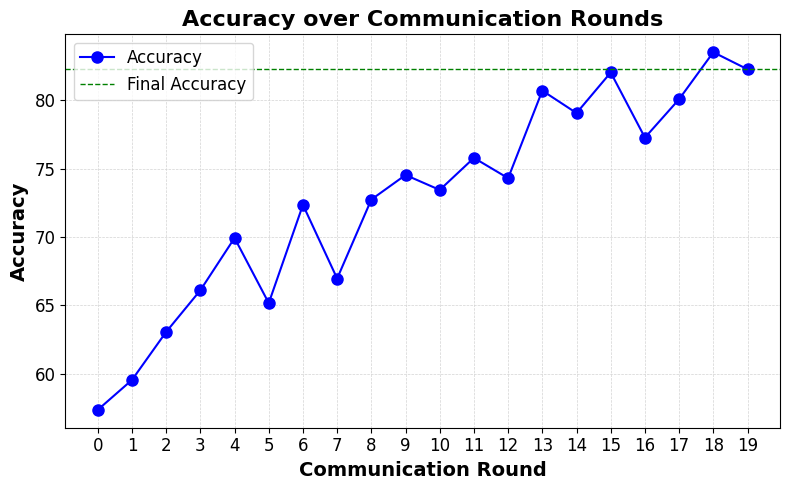

In [27]:
plt.figure(figsize=(8, 5)) 
plt.plot(range(len(accuracies)), accuracies, marker='o', markersize=8, linestyle='-', color='blue', label='Accuracy')  # Customize marker, size, line style, and color
plt.xticks(range(len(accuracies)), fontsize=12) 
plt.yticks(fontsize=12)  
plt.xlabel('Communication Round', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Accuracy over Communication Rounds', fontsize=16, fontweight='bold')

plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.axhline(y=accuracies[-1], color='green', linestyle='--', linewidth=1, label='Final Accuracy')  # Add a line for final accuracy
plt.legend(fontsize=12, loc='upper left')  # Adjust legend position
plt.tight_layout()
plt.savefig('accuracy_plot.png')
plt.show()